# Stock Price Indicator
                
## Project aims to predict adjusted close price of some stocks chosen previously.


## 1- Data Exploration
### A- get historical values
### B- plot Adjusted Close column
### C- check for null values


In [1]:
#A- get historical values

import pandas as pd
import pandas_datareader as pdr
import datetime

adjclose = 'Adj Close'

stock_list = ['AAPL', 'AMZN', 'AVGO', 'CSCO', 'MA', 'MSFT', 'NVDA', 'NVS', 'PFE', 'QCOM', 'TXN', 'V', 'WMT']

start=datetime.datetime(2010,3,20)

end=datetime.datetime(2019,3,19)

#for stock in stock_list:
    #history = pdr.get_data_yahoo(stock, start, end)
    #history.to_csv('./data1/'+stock+'.csv')

AMZN = pd.read_csv('data/AMZN.csv', header=0, parse_dates=['Date'])
AMZN.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-03-22,130.960007,128.639999,130.199997,130.470001,5383400,130.470001
1,2010-03-23,130.940002,128.070007,130.889999,129.259995,4213100,129.259995
2,2010-03-24,129.399994,127.199997,128.639999,128.039993,4696400,128.039993
3,2010-03-25,136.910004,128.039993,129.139999,134.729996,16209600,134.729996
4,2010-03-26,136.990005,133.759995,134.899994,135.059998,6565700,135.059998


In [2]:
# B- plot Adjusted Close column

import datetime
import matplotlib as plt

stock_data_list = []

for stock in stock_list:
    stock_data = pd.read_csv('data/'+stock+'.csv', header=0, parse_dates=['Date'])
    stock_data.set_index('Date',inplace=True)
    plott = stock_data[adjclose].plot(figsize=(16, 12), label=stock)
    plott.legend()
    stock_data['stock_name'] = stock
    stock_data_list.append(stock_data)



In [3]:
# C- check for null values

for stock_data in stock_data_list:
    print(stock_data.isnull().any().any())

False
False
False
False
False
False
False
False
False
False
False
False
False


## 2- Domain Research
### A- Add Key Feature Columns to Data
### B- Plot Examples for Key Features

In [4]:
#A- Add Key Feature Columns to Data
import numpy as np
#Add MACD 26, 12 day periods
def add_MACD(dataframe):
    macd26 = dataframe[adjclose].ewm(span=26, min_periods=26, adjust= True).mean()
    macd12 = dataframe[adjclose].ewm(span=12, min_periods=12, adjust= True).mean()
    dataframe["MACD"] = macd26-macd12
    return dataframe

#Add RSI Wilder's RSI
def add_RSI(df, column=adjclose, period=14):
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    
    return df.join(rsi.to_frame('RSI'))

#Add Bollinger Bands
def add_BollingerBand(df, column=adjclose, period=20):
    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

def get_weighted_average(dataframe,window,columnname_data,columnname_weights):
    processed_dataframe=dataframe.loc[:,(columnname_data,columnname_weights)].set_index(columnname_weights)   
    def get_mean_withweights(processed_dataframe_windowed):
        return np.average(a=processed_dataframe_windowed,weights=processed_dataframe_windowed.index)
    tmp_df = processed_dataframe.rolling(window=window).apply(func=get_mean_withweights,raw=False)
    tmp_df = tmp_df.reset_index()
    dataframe = dataframe.reset_index()
    tmp_df2 = dataframe.join(tmp_df[adjclose].to_frame('WMA'))
    tmp_df2.set_index('Date',inplace=True)
    #print(tmp_df2)
    return tmp_df2


for index, stock_data in enumerate(stock_data_list):
    stock_data = add_MACD(stock_data)
    stock_data = add_RSI(stock_data)
    stock_data = add_BollingerBand(stock_data)
    stock_data = get_weighted_average(stock_data,10,adjclose, 'Volume')
    #print(stock_data.columns)
    #print(stock_data)
    #stock_data['MACD'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['RSI'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDUP'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDLO'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['WMA'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    stock_data = stock_data[25:] #delete NaN values
    stock_data_list[index] = stock_data

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'stock_name',
       'MACD', 'RSI', 'BBANDUP', 'BBANDLO', 'WMA'],
      dtype='object')


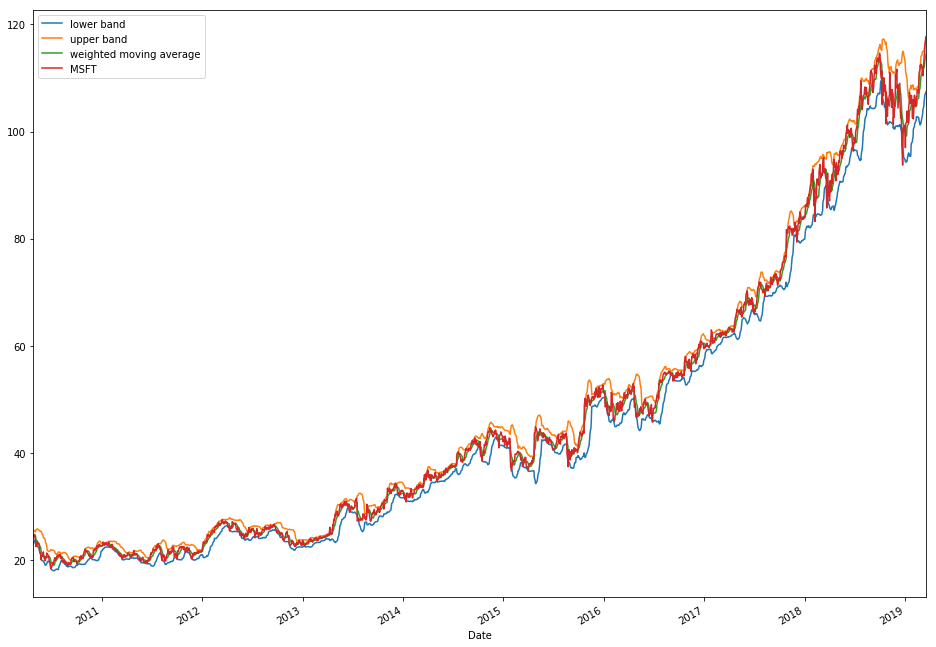

In [5]:
def plot_stock(index):
    stock_data = stock_data_list[index]
    print(stock_data.columns)

    #plot Bollinger Bands
    plt1 = stock_data['BBANDLO'].plot(figsize=(16, 12), label='lower band')
    stock_data['BBANDUP'].plot(label='upper band')
    stock_data['WMA'].plot(label='weighted moving average')
    stock_data[adjclose].plot(label=stock_data['stock_name'][0])
    plt1.legend()
    
plot_stock(5)



#plot RSI and MACD
#plot2 =  stock_data['RSI'].plot(figsize=(16, 12), label='RSI')

## 2- Data Normalization & Seperation

In [6]:
from sklearn import preprocessing

normalized_stock_list = []
y_adj_close_list = []
scaler = preprocessing.MinMaxScaler()


for stock_data in stock_data_list:
    stock_data = stock_data.drop(columns='stock_name')
    y_adj_close_list.append(stock_data[adjclose])
    stock_data = stock_data.drop(columns=adjclose)
    names = stock_data.columns
    scaled_df = scaler.fit_transform(stock_data)
    scaled_df = pd.DataFrame(scaled_df, columns=names)
    normalized_stock_list.append(scaled_df)

#since we want n+1 adj close price to be predicted with the n th day values
#we need to shift y values for 1 day 
for y_adj_close in y_adj_close_list:
    y_adj_close.shift(-1)




    
print(y_adj_close_list[5]) # our target list to predict  
print(normalized_stock_list[5]) # our input values for models  
   


Date
2010-04-27     24.651001
2010-04-28     24.698944
2010-04-29     24.770861
2010-04-30     24.403294
2010-05-03     24.658993
2010-05-04     24.075682
2010-05-05     23.851942
2010-05-06     23.156761
2010-05-07     22.541483
2010-05-10     23.124798
2010-05-11     23.076849
2010-05-12     23.524330
2010-05-13     23.364517
2010-05-14     23.116808
2010-05-17     23.124798
2010-05-18     22.956236
2010-05-19     22.667269
2010-05-20     21.760265
2010-05-21     21.543539
2010-05-24     21.086029
2010-05-25     20.925493
2010-05-26     20.074663
2010-05-27     20.869303
2010-05-28     20.708771
2010-06-01     20.781010
2010-06-02     21.238535
2010-06-03     21.559595
2010-06-04     20.700745
2010-06-07     20.299412
2010-06-08     20.154936
                 ...    
2019-02-05    106.764046
2019-02-06    105.579102
2019-02-07    104.822327
2019-02-08    105.220634
2019-02-11    104.802422
2019-02-12    106.435448
2019-02-13    106.355782
2019-02-14    106.445404
2019-02-15    107.75

/home/ai/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 3- Building:
### A: Benchmark Model
### B: RMSE and R2 Validation
### C: Solution Model
### D: Test Flow


In [7]:
# A- For Benchmark we will use standard linear regression
from keras.layers import Dense
from keras.models import Model, Sequential
from keras import initializers, optimizers
from sklearn.model_selection import train_test_split

from pylab import *


def create_benchmark_model():
   model = Sequential()
   model.add(Dense(1, activation = 'linear', input_dim = 10))
   sgd = optimizers.SGD(lr=0.2)
   model.compile(optimizer = sgd, loss = 'mean_squared_error', metrics = ['accuracy'])
   return model

# B - RMSE Score, R2 Score
from sklearn.metrics import mean_squared_error, r2_score


def RMSE_score(y, y_predicted, method_name):
    RMSE_score = np.sqrt(mean_squared_error(y, y_predicted))
    print(method_name + " RMSE Score: {0}".format(RMSE_score))
    return RMSE_score


def R2_score(y, y_predicted, method_name):
    R2_score = r2_score(y, y_predicted)
    print( method_name +" R2 Score: {0}".format(R2_score))
    return R2_score

def check_score(y, y_predicted, method_name):
    rmse = RMSE_score(y, y_predicted, method_name)
    r2 = R2_score(y, y_predicted, method_name)
    return rmse, r2


Using TensorFlow backend.


In [8]:
# C - Solution Models LSTM and SVM 
from sklearn import svm
from keras.layers.recurrent import LSTM
from keras.layers import Dropout, Activation, Flatten
import numpy 

def create_svm_linear_model():
    model = svm.SVR(kernel='linear', C=100)
    return model

def create_svm_polynomial_model():
    model = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
    return model

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(return_sequences=True, input_shape=(1, 10), units=100, dropout=0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model
       

In [9]:
#D -Test Flow

def drive_test(use_different_models):
    results_dataframe = pd.DataFrame()
    for index, normalized_stock in enumerate(normalized_stock_list):
        #create models
        if (use_different_models or index == 0):
            linear_regression_model = create_benchmark_model() 
            svm_linear = create_svm_linear_model()
            svm_polynomial = create_svm_polynomial_model()
            lstm_model = create_lstm_model()
        linear_regression_model = create_benchmark_model() 
        svm_linear = create_svm_linear_model()
        svm_polynomial = create_svm_polynomial_model()
        lstm_model = create_lstm_model()
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                                            y_adj_close_list[index], test_size=0.20, random_state=42)

        linear_regression_model.fit(X_train, y_train, epochs =100,batch_size = 32)
        linear_y_predict = linear_regression_model.predict(X_test)


        svm_linear.fit(X_train, y_train)
        svm_linear_y_predict = svm_linear.predict(X_test)


        svm_polynomial.fit(X_train, y_train)
        svm_polynomial_y_predict = svm_polynomial.predict(X_test)

        trainX = numpy.reshape(X_train.values, (X_train.shape[0],1, -1))
        testX = numpy.reshape(X_test.values, (X_test.shape[0],1, X_test.shape[1]))
        lstm_model.fit(trainX, y_train, batch_size =32,epochs = 1000)
        lstm_y_predict = lstm_model.predict(testX)


        rmse_1, r2_1 = check_score(y_test, linear_y_predict, "Linear Regression")
        rmse_2, r2_2 = check_score(y_test, svm_linear_y_predict, "SVM Linear Model")
        rmse_3, r2_3 = check_score(y_test, svm_polynomial_y_predict, "SVM Polynomial Model")
        rmse_4, r2_4 = check_score(y_test, lstm_y_predict, "LSTM Model")

        print(index )

        df = pd.DataFrame({"linear_rmse": rmse_1,  "linear_r2": r2_1, 
                                   "svm_linear_rmse":rmse_2, "svm_linear_r2":r2_2,
                                   "svm_polynomial_rmse":rmse_3, "svm_polynomial_r2":r2_3,
                                   "lstm_rmse":rmse_4, "lstm_r2":r2_4 }, index=[0])

        results_dataframe = results_dataframe.append(df)
    return results_dataframe

In [10]:
results_different_models = drive_test(True)
result_same_models = drive_test(False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1791/1791 [==============================] - 0s 80us/step - loss: 250.8628 - acc: 0.0000e+00
Epoch 2/100
1791/1791 [==============================] - 0s 12us/step - loss: 9.0600 - acc: 0.0000e+00
Epoch 3/100
1791/1791 [==============================] - 0s 11us/step - loss: 8.7742 - acc: 0.0000e+00
Epoch 4/100
1791/1791 [==============================] - 0s 12us/step - loss: 8.4371 - acc: 0.0000e+00
Epoch 5/100
1791/1791 [==============================] - 0s 11us/step - loss: 8.2075 - acc: 0.0000e+00
Epoch 6/100
1791/1791 [==============================] - 0s 12us/step - loss: 7.9944 - acc: 0.0000e+00
Epoch 7/100
1791/1791 [==============================] - 0s 11us/step - loss: 7.6772 - acc: 0.0000e+00
Epoch 8/100
1791/1791 [===================

1791/1791 [==============================] - 0s 11us/step - loss: 4.3195 - acc: 0.0000e+00
Epoch 71/100
1791/1791 [==============================] - 0s 12us/step - loss: 4.2066 - acc: 0.0000e+00
Epoch 72/100
1791/1791 [==============================] - 0s 11us/step - loss: 4.1723 - acc: 0.0000e+00
Epoch 73/100
1791/1791 [==============================] - 0s 11us/step - loss: 4.2053 - acc: 0.0000e+00
Epoch 74/100
1791/1791 [==============================] - 0s 11us/step - loss: 4.2243 - acc: 0.0000e+00
Epoch 75/100
1791/1791 [==============================] - 0s 11us/step - loss: 4.1536 - acc: 0.0000e+00
Epoch 76/100
1791/1791 [==============================] - 0s 11us/step - loss: 4.1984 - acc: 0.0000e+00
Epoch 77/100
1791/1791 [==============================] - 0s 11us/step - loss: 4.1604 - acc: 0.0000e+00
Epoch 78/100
1791/1791 [==============================] - 0s 11us/step - loss: 4.2540 - acc: 0.0000e+00
Epoch 79/100
1791/1791 [==============================] - 0s 11us/step - loss

1791/1791 [==============================] - 0s 34us/step - loss: 128.5792
Epoch 57/1000
1791/1791 [==============================] - 0s 33us/step - loss: 119.1048
Epoch 58/1000
1791/1791 [==============================] - 0s 33us/step - loss: 123.8402
Epoch 59/1000
1791/1791 [==============================] - 0s 33us/step - loss: 128.7274
Epoch 60/1000
1791/1791 [==============================] - 0s 33us/step - loss: 117.6244
Epoch 61/1000
1791/1791 [==============================] - 0s 32us/step - loss: 110.3959
Epoch 62/1000
1791/1791 [==============================] - 0s 33us/step - loss: 117.4470
Epoch 63/1000
1791/1791 [==============================] - 0s 33us/step - loss: 112.1166
Epoch 64/1000
1791/1791 [==============================] - 0s 33us/step - loss: 118.0043
Epoch 65/1000
1791/1791 [==============================] - 0s 33us/step - loss: 122.8088
Epoch 66/1000
1791/1791 [==============================] - 0s 34us/step - loss: 110.9446
Epoch 67/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 99.0509
Epoch 148/1000
1791/1791 [==============================] - 0s 33us/step - loss: 100.5875
Epoch 149/1000
1791/1791 [==============================] - 0s 33us/step - loss: 97.8538
Epoch 150/1000
1791/1791 [==============================] - 0s 33us/step - loss: 99.5352
Epoch 151/1000
1791/1791 [==============================] - 0s 33us/step - loss: 99.5223
Epoch 152/1000
1791/1791 [==============================] - 0s 33us/step - loss: 108.2264
Epoch 153/1000
1791/1791 [==============================] - 0s 33us/step - loss: 100.7878
Epoch 154/1000
1791/1791 [==============================] - 0s 33us/step - loss: 98.4302
Epoch 155/1000
1791/1791 [==============================] - 0s 33us/step - loss: 103.3224
Epoch 156/1000
1791/1791 [==============================] - 0s 32us/step - loss: 98.5099
Epoch 157/1000
1791/1791 [==============================] - 0s 34us/step - loss: 104.1829
Epoch 158/1000
1791/1791 [=====

1791/1791 [==============================] - 0s 33us/step - loss: 101.4490
Epoch 239/1000
1791/1791 [==============================] - 0s 33us/step - loss: 95.7132
Epoch 240/1000
1791/1791 [==============================] - 0s 33us/step - loss: 105.2561
Epoch 241/1000
1791/1791 [==============================] - 0s 33us/step - loss: 97.6068
Epoch 242/1000
1791/1791 [==============================] - 0s 33us/step - loss: 99.8948
Epoch 243/1000
1791/1791 [==============================] - 0s 32us/step - loss: 103.1114
Epoch 244/1000
1791/1791 [==============================] - 0s 33us/step - loss: 89.6394
Epoch 245/1000
1791/1791 [==============================] - 0s 32us/step - loss: 107.2429
Epoch 246/1000
1791/1791 [==============================] - 0s 33us/step - loss: 99.2896
Epoch 247/1000
1791/1791 [==============================] - 0s 32us/step - loss: 100.0200
Epoch 248/1000
1791/1791 [==============================] - 0s 33us/step - loss: 108.1376
Epoch 249/1000
1791/1791 [====

1791/1791 [==============================] - 0s 33us/step - loss: 96.7713
Epoch 330/1000
1791/1791 [==============================] - 0s 33us/step - loss: 97.6064
Epoch 331/1000
1791/1791 [==============================] - 0s 33us/step - loss: 98.1822
Epoch 332/1000
1791/1791 [==============================] - 0s 33us/step - loss: 103.2577
Epoch 333/1000
1791/1791 [==============================] - 0s 33us/step - loss: 91.7422
Epoch 334/1000
1791/1791 [==============================] - 0s 33us/step - loss: 90.8961
Epoch 335/1000
1791/1791 [==============================] - 0s 33us/step - loss: 97.5937
Epoch 336/1000
1791/1791 [==============================] - 0s 34us/step - loss: 97.9678
Epoch 337/1000
1791/1791 [==============================] - 0s 33us/step - loss: 102.0573
Epoch 338/1000
1791/1791 [==============================] - 0s 33us/step - loss: 101.7840
Epoch 339/1000
1791/1791 [==============================] - 0s 33us/step - loss: 104.7430
Epoch 340/1000
1791/1791 [======

1791/1791 [==============================] - 0s 33us/step - loss: 87.7972
Epoch 422/1000
1791/1791 [==============================] - 0s 33us/step - loss: 107.1661
Epoch 423/1000
1791/1791 [==============================] - 0s 33us/step - loss: 93.0507
Epoch 424/1000
1791/1791 [==============================] - 0s 33us/step - loss: 89.7703
Epoch 425/1000
1791/1791 [==============================] - 0s 33us/step - loss: 89.5842
Epoch 426/1000
1791/1791 [==============================] - 0s 33us/step - loss: 102.3239
Epoch 427/1000
1791/1791 [==============================] - 0s 33us/step - loss: 86.2644
Epoch 428/1000
1791/1791 [==============================] - 0s 33us/step - loss: 97.9366
Epoch 429/1000
1791/1791 [==============================] - 0s 33us/step - loss: 88.5872
Epoch 430/1000
1791/1791 [==============================] - 0s 33us/step - loss: 86.9189
Epoch 431/1000
1791/1791 [==============================] - 0s 34us/step - loss: 96.7974
Epoch 432/1000
1791/1791 [========

1791/1791 [==============================] - 0s 33us/step - loss: 81.0053
Epoch 514/1000
1791/1791 [==============================] - 0s 34us/step - loss: 83.6796
Epoch 515/1000
1791/1791 [==============================] - 0s 34us/step - loss: 85.2454
Epoch 516/1000
1791/1791 [==============================] - 0s 33us/step - loss: 90.6938
Epoch 517/1000
1791/1791 [==============================] - 0s 33us/step - loss: 87.8010
Epoch 518/1000
1791/1791 [==============================] - 0s 33us/step - loss: 90.1080
Epoch 519/1000
1791/1791 [==============================] - 0s 33us/step - loss: 84.2261
Epoch 520/1000
1791/1791 [==============================] - 0s 33us/step - loss: 87.1681
Epoch 521/1000
1791/1791 [==============================] - 0s 33us/step - loss: 82.2807
Epoch 522/1000
1791/1791 [==============================] - 0s 33us/step - loss: 88.2380
Epoch 523/1000
1791/1791 [==============================] - 0s 34us/step - loss: 89.7021
Epoch 524/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 80.0590
Epoch 606/1000
1791/1791 [==============================] - 0s 33us/step - loss: 86.3391
Epoch 607/1000
1791/1791 [==============================] - 0s 33us/step - loss: 74.0630
Epoch 608/1000
1791/1791 [==============================] - 0s 33us/step - loss: 87.7001
Epoch 609/1000
1791/1791 [==============================] - 0s 33us/step - loss: 87.9974
Epoch 610/1000
1791/1791 [==============================] - 0s 33us/step - loss: 85.2334
Epoch 611/1000
1791/1791 [==============================] - 0s 33us/step - loss: 81.1027
Epoch 612/1000
1791/1791 [==============================] - 0s 33us/step - loss: 81.5747
Epoch 613/1000
1791/1791 [==============================] - 0s 33us/step - loss: 82.6804
Epoch 614/1000
1791/1791 [==============================] - 0s 33us/step - loss: 82.9674
Epoch 615/1000
1791/1791 [==============================] - 0s 34us/step - loss: 92.6833
Epoch 616/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 71.3159
Epoch 698/1000
1791/1791 [==============================] - 0s 34us/step - loss: 77.2989
Epoch 699/1000
1791/1791 [==============================] - 0s 34us/step - loss: 70.8875
Epoch 700/1000
1791/1791 [==============================] - 0s 33us/step - loss: 79.1045
Epoch 701/1000
1791/1791 [==============================] - 0s 34us/step - loss: 72.1094
Epoch 702/1000
1791/1791 [==============================] - 0s 33us/step - loss: 80.6805
Epoch 703/1000
1791/1791 [==============================] - 0s 34us/step - loss: 74.7078
Epoch 704/1000
1791/1791 [==============================] - 0s 33us/step - loss: 70.4002
Epoch 705/1000
1791/1791 [==============================] - 0s 33us/step - loss: 74.9544
Epoch 706/1000
1791/1791 [==============================] - 0s 33us/step - loss: 64.3626
Epoch 707/1000
1791/1791 [==============================] - 0s 33us/step - loss: 62.5606
Epoch 708/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 62.3868
Epoch 790/1000
1791/1791 [==============================] - 0s 34us/step - loss: 64.8834
Epoch 791/1000
1791/1791 [==============================] - 0s 33us/step - loss: 65.8276
Epoch 792/1000
1791/1791 [==============================] - 0s 33us/step - loss: 63.8242
Epoch 793/1000
1791/1791 [==============================] - 0s 33us/step - loss: 55.1927
Epoch 794/1000
1791/1791 [==============================] - 0s 33us/step - loss: 58.6759
Epoch 795/1000
1791/1791 [==============================] - 0s 33us/step - loss: 60.6505
Epoch 796/1000
1791/1791 [==============================] - 0s 33us/step - loss: 65.1470
Epoch 797/1000
1791/1791 [==============================] - 0s 34us/step - loss: 63.6833
Epoch 798/1000
1791/1791 [==============================] - 0s 33us/step - loss: 57.8407
Epoch 799/1000
1791/1791 [==============================] - 0s 33us/step - loss: 63.7199
Epoch 800/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 53.5713
Epoch 882/1000
1791/1791 [==============================] - 0s 33us/step - loss: 48.8241
Epoch 883/1000
1791/1791 [==============================] - 0s 35us/step - loss: 57.8627
Epoch 884/1000
1791/1791 [==============================] - 0s 34us/step - loss: 50.7346
Epoch 885/1000
1791/1791 [==============================] - 0s 33us/step - loss: 56.4093
Epoch 886/1000
1791/1791 [==============================] - 0s 33us/step - loss: 58.4301
Epoch 887/1000
1791/1791 [==============================] - 0s 33us/step - loss: 55.7679
Epoch 888/1000
1791/1791 [==============================] - 0s 33us/step - loss: 60.3045
Epoch 889/1000
1791/1791 [==============================] - 0s 33us/step - loss: 55.4991
Epoch 890/1000
1791/1791 [==============================] - 0s 34us/step - loss: 50.9583
Epoch 891/1000
1791/1791 [==============================] - 0s 33us/step - loss: 58.9950
Epoch 892/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 41.1218
Epoch 974/1000
1791/1791 [==============================] - 0s 35us/step - loss: 44.8790
Epoch 975/1000
1791/1791 [==============================] - 0s 35us/step - loss: 42.0025
Epoch 976/1000
1791/1791 [==============================] - 0s 34us/step - loss: 47.1974
Epoch 977/1000
1791/1791 [==============================] - 0s 35us/step - loss: 42.5810
Epoch 978/1000
1791/1791 [==============================] - 0s 34us/step - loss: 48.8067
Epoch 979/1000
1791/1791 [==============================] - 0s 33us/step - loss: 55.7175
Epoch 980/1000
1791/1791 [==============================] - 0s 34us/step - loss: 41.2067
Epoch 981/1000
1791/1791 [==============================] - 0s 34us/step - loss: 41.3950
Epoch 982/1000
1791/1791 [==============================] - 0s 34us/step - loss: 43.5236
Epoch 983/1000
1791/1791 [==============================] - 0s 34us/step - loss: 47.3532
Epoch 984/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 12us/step - loss: 82.8464 - acc: 5.5835e-04
Epoch 54/100
1791/1791 [==============================] - 0s 12us/step - loss: 85.6029 - acc: 0.0017
Epoch 55/100
1791/1791 [==============================] - 0s 11us/step - loss: 85.1690 - acc: 0.0011
Epoch 56/100
1791/1791 [==============================] - 0s 11us/step - loss: 83.7761 - acc: 0.0022
Epoch 57/100
1791/1791 [==============================] - 0s 11us/step - loss: 80.5844 - acc: 0.0017
Epoch 58/100
1791/1791 [==============================] - 0s 12us/step - loss: 84.0620 - acc: 0.0022
Epoch 59/100
1791/1791 [==============================] - 0s 12us/step - loss: 83.6376 - acc: 0.0022
Epoch 60/100
1791/1791 [==============================] - 0s 12us/step - loss: 81.5282 - acc: 0.0017
Epoch 61/100
1791/1791 [==============================] - 0s 11us/step - loss: 85.4315 - acc: 0.0022
Epoch 62/100
1791/1791 [==============================] - 0s 12us/step - loss: 81.4095 - acc: 0.0017

1791/1791 [==============================] - 0s 34us/step - loss: 436665.4292
Epoch 38/1000
1791/1791 [==============================] - 0s 33us/step - loss: 432999.3258
Epoch 39/1000
1791/1791 [==============================] - 0s 34us/step - loss: 429355.8711
Epoch 40/1000
1791/1791 [==============================] - 0s 35us/step - loss: 425833.8089
Epoch 41/1000
1791/1791 [==============================] - 0s 33us/step - loss: 422223.1597
Epoch 42/1000
1791/1791 [==============================] - 0s 34us/step - loss: 418712.0749
Epoch 43/1000
1791/1791 [==============================] - 0s 34us/step - loss: 415302.2966
Epoch 44/1000
1791/1791 [==============================] - 0s 34us/step - loss: 411799.3985
Epoch 45/1000
1791/1791 [==============================] - 0s 33us/step - loss: 408396.0861
Epoch 46/1000
1791/1791 [==============================] - 0s 34us/step - loss: 404988.9218
Epoch 47/1000
1791/1791 [==============================] - 0s 34us/step - loss: 401692.3949
Ep

1791/1791 [==============================] - 0s 34us/step - loss: 205993.6530
Epoch 126/1000
1791/1791 [==============================] - 0s 34us/step - loss: 204063.3438
Epoch 127/1000
1791/1791 [==============================] - 0s 33us/step - loss: 202240.4929
Epoch 128/1000
1791/1791 [==============================] - 0s 34us/step - loss: 200443.9806
Epoch 129/1000
1791/1791 [==============================] - 0s 34us/step - loss: 198708.1842
Epoch 130/1000
1791/1791 [==============================] - 0s 34us/step - loss: 196783.5308
Epoch 131/1000
1791/1791 [==============================] - 0s 34us/step - loss: 194983.4173
Epoch 132/1000
1791/1791 [==============================] - 0s 34us/step - loss: 193269.0466
Epoch 133/1000
1791/1791 [==============================] - 0s 33us/step - loss: 191474.1371
Epoch 134/1000
1791/1791 [==============================] - 0s 34us/step - loss: 189786.8221
Epoch 135/1000
1791/1791 [==============================] - 0s 34us/step - loss: 1879

1791/1791 [==============================] - 0s 34us/step - loss: 88537.0340
Epoch 214/1000
1791/1791 [==============================] - 0s 34us/step - loss: 87596.8281
Epoch 215/1000
1791/1791 [==============================] - 0s 34us/step - loss: 87002.6925
Epoch 216/1000
1791/1791 [==============================] - 0s 33us/step - loss: 85828.7104
Epoch 217/1000
1791/1791 [==============================] - 0s 34us/step - loss: 85123.6769
Epoch 218/1000
1791/1791 [==============================] - 0s 35us/step - loss: 84329.4063
Epoch 219/1000
1791/1791 [==============================] - 0s 34us/step - loss: 83772.9483
Epoch 220/1000
1791/1791 [==============================] - 0s 34us/step - loss: 82627.5142
Epoch 221/1000
1791/1791 [==============================] - 0s 34us/step - loss: 81489.2114
Epoch 222/1000
1791/1791 [==============================] - 0s 34us/step - loss: 80998.0770
Epoch 223/1000
1791/1791 [==============================] - 0s 34us/step - loss: 79917.1439
Epo

1791/1791 [==============================] - 0s 35us/step - loss: 32598.6982
Epoch 303/1000
1791/1791 [==============================] - 0s 35us/step - loss: 31873.3167
Epoch 304/1000
1791/1791 [==============================] - 0s 35us/step - loss: 31586.2872
Epoch 305/1000
1791/1791 [==============================] - 0s 35us/step - loss: 30922.5904
Epoch 306/1000
1791/1791 [==============================] - 0s 34us/step - loss: 30347.2974
Epoch 307/1000
1791/1791 [==============================] - 0s 34us/step - loss: 30555.5893
Epoch 308/1000
1791/1791 [==============================] - 0s 34us/step - loss: 29908.0950
Epoch 309/1000
1791/1791 [==============================] - 0s 34us/step - loss: 28898.2378
Epoch 310/1000
1791/1791 [==============================] - 0s 34us/step - loss: 28639.1680
Epoch 311/1000
1791/1791 [==============================] - 0s 35us/step - loss: 28461.0587
Epoch 312/1000
1791/1791 [==============================] - 0s 35us/step - loss: 28512.0280
Epo

1791/1791 [==============================] - 0s 34us/step - loss: 10324.6851
Epoch 392/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9994.6865
Epoch 393/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9478.2936
Epoch 394/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9918.6097
Epoch 395/1000
1791/1791 [==============================] - 0s 35us/step - loss: 10175.4848
Epoch 396/1000
1791/1791 [==============================] - 0s 37us/step - loss: 9816.7534
Epoch 397/1000
1791/1791 [==============================] - 0s 38us/step - loss: 9399.8044
Epoch 398/1000
1791/1791 [==============================] - 0s 35us/step - loss: 9504.9156
Epoch 399/1000
1791/1791 [==============================] - 0s 33us/step - loss: 9438.0031
Epoch 400/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9565.1646
Epoch 401/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9066.8279
Epoch 402/10

1791/1791 [==============================] - 0s 35us/step - loss: 6930.8708
Epoch 482/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6307.9153
Epoch 483/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6848.2166
Epoch 484/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6388.9472
Epoch 485/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6032.8114
Epoch 486/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5950.0712
Epoch 487/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5987.8394
Epoch 488/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5709.8902
Epoch 489/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6521.1569
Epoch 490/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6245.9679
Epoch 491/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6201.1832
Epoch 492/1000

1791/1791 [==============================] - 0s 35us/step - loss: 5241.7641
Epoch 572/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5437.4071
Epoch 573/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5751.6581
Epoch 574/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5418.8278
Epoch 575/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5728.1605
Epoch 576/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5448.1233
Epoch 577/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5307.9932
Epoch 578/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5888.2662
Epoch 579/1000
1791/1791 [==============================] - 0s 35us/step - loss: 6052.5401
Epoch 580/1000
1791/1791 [==============================] - 0s 33us/step - loss: 5539.9776
Epoch 581/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6123.5773
Epoch 582/1000

1791/1791 [==============================] - 0s 34us/step - loss: 5694.1901
Epoch 662/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5167.3431
Epoch 663/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5536.3479
Epoch 664/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5624.1864
Epoch 665/1000
1791/1791 [==============================] - 0s 34us/step - loss: 4666.0630
Epoch 666/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5659.8417
Epoch 667/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6073.7383
Epoch 668/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5508.8458
Epoch 669/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6066.8448
Epoch 670/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5282.7992
Epoch 671/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5902.2215
Epoch 672/1000

1791/1791 [==============================] - 0s 34us/step - loss: 5154.4066
Epoch 752/1000
1791/1791 [==============================] - 0s 34us/step - loss: 6217.6187
Epoch 753/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5318.1140
Epoch 754/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5652.7418
Epoch 755/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5144.1504
Epoch 756/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5632.0515
Epoch 757/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5715.3538
Epoch 758/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5135.1715
Epoch 759/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4988.5646
Epoch 760/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5026.2022
Epoch 761/1000
1791/1791 [==============================] - 0s 35us/step - loss: 6321.2136
Epoch 762/1000

1791/1791 [==============================] - 0s 37us/step - loss: 5845.4481
Epoch 842/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5939.8381
Epoch 843/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5614.4315
Epoch 844/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5312.1197
Epoch 845/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5032.9731
Epoch 846/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5731.7578
Epoch 847/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4960.0244
Epoch 848/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5856.9981
Epoch 849/1000
1791/1791 [==============================] - 0s 36us/step - loss: 6058.0637
Epoch 850/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5254.3972
Epoch 851/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4842.1361
Epoch 852/1000

1791/1791 [==============================] - 0s 35us/step - loss: 5677.4013
Epoch 932/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4969.0798
Epoch 933/1000
1791/1791 [==============================] - 0s 36us/step - loss: 6087.2381
Epoch 934/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5404.7080
Epoch 935/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5527.4236
Epoch 936/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5346.3275
Epoch 937/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5395.0475
Epoch 938/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5542.0068
Epoch 939/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5459.1546
Epoch 940/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5262.9028
Epoch 941/1000
1791/1791 [==============================] - 0s 34us/step - loss: 5540.3831
Epoch 942/1000

1791/1791 [==============================] - 0s 12us/step - loss: 5.4013 - acc: 0.0000e+00
Epoch 16/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.3215 - acc: 0.0000e+00
Epoch 17/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.3953 - acc: 5.5835e-04
Epoch 18/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.2622 - acc: 0.0000e+00
Epoch 19/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.3373 - acc: 0.0000e+00
Epoch 20/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.3605 - acc: 0.0000e+00
Epoch 21/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.6295 - acc: 0.0000e+00
Epoch 22/100
1791/1791 [==============================] - 0s 13us/step - loss: 5.2604 - acc: 0.0000e+00
Epoch 23/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.1826 - acc: 0.0000e+00
Epoch 24/100
1791/1791 [==============================] - 0s 12us/step - loss

1791/1791 [==============================] - 0s 12us/step - loss: 5.1184 - acc: 0.0000e+00
Epoch 94/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.0978 - acc: 5.5835e-04
Epoch 95/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.2685 - acc: 0.0000e+00
Epoch 96/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.0517 - acc: 0.0000e+00
Epoch 97/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.0505 - acc: 0.0000e+00
Epoch 98/100
1791/1791 [==============================] - 0s 12us/step - loss: 4.9951 - acc: 0.0000e+00
Epoch 99/100
1791/1791 [==============================] - 0s 12us/step - loss: 4.9687 - acc: 0.0000e+00
Epoch 100/100
1791/1791 [==============================] - 0s 12us/step - loss: 5.0299 - acc: 0.0000e+00
Epoch 1/1000
1791/1791 [==============================] - 1s 287us/step - loss: 18646.5216
Epoch 2/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18011.0787

1791/1791 [==============================] - 0s 35us/step - loss: 181.3743
Epoch 84/1000
1791/1791 [==============================] - 0s 34us/step - loss: 198.4582
Epoch 85/1000
1791/1791 [==============================] - 0s 34us/step - loss: 186.4561
Epoch 86/1000
1791/1791 [==============================] - 0s 34us/step - loss: 195.5977
Epoch 87/1000
1791/1791 [==============================] - 0s 36us/step - loss: 177.1948
Epoch 88/1000
1791/1791 [==============================] - 0s 34us/step - loss: 202.3474
Epoch 89/1000
1791/1791 [==============================] - 0s 34us/step - loss: 194.9375
Epoch 90/1000
1791/1791 [==============================] - 0s 34us/step - loss: 195.2483
Epoch 91/1000
1791/1791 [==============================] - 0s 34us/step - loss: 179.7848
Epoch 92/1000
1791/1791 [==============================] - 0s 34us/step - loss: 216.6912
Epoch 93/1000
1791/1791 [==============================] - 0s 35us/step - loss: 187.7033
Epoch 94/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 182.3855
Epoch 175/1000
1791/1791 [==============================] - 0s 34us/step - loss: 169.2688
Epoch 176/1000
1791/1791 [==============================] - 0s 34us/step - loss: 168.8758
Epoch 177/1000
1791/1791 [==============================] - 0s 35us/step - loss: 175.0237
Epoch 178/1000
1791/1791 [==============================] - 0s 34us/step - loss: 169.9061
Epoch 179/1000
1791/1791 [==============================] - 0s 34us/step - loss: 184.3924
Epoch 180/1000
1791/1791 [==============================] - 0s 33us/step - loss: 197.0618
Epoch 181/1000
1791/1791 [==============================] - 0s 34us/step - loss: 170.5488
Epoch 182/1000
1791/1791 [==============================] - 0s 34us/step - loss: 167.2400
Epoch 183/1000
1791/1791 [==============================] - 0s 34us/step - loss: 158.8510
Epoch 184/1000
1791/1791 [==============================] - 0s 34us/step - loss: 188.4948
Epoch 185/1000
1791/1791 

1791/1791 [==============================] - 0s 34us/step - loss: 165.1527
Epoch 266/1000
1791/1791 [==============================] - 0s 34us/step - loss: 189.0212
Epoch 267/1000
1791/1791 [==============================] - 0s 35us/step - loss: 190.7403
Epoch 268/1000
1791/1791 [==============================] - 0s 34us/step - loss: 164.2831
Epoch 269/1000
1791/1791 [==============================] - 0s 34us/step - loss: 179.0244
Epoch 270/1000
1791/1791 [==============================] - 0s 34us/step - loss: 177.4851
Epoch 271/1000
1791/1791 [==============================] - 0s 34us/step - loss: 161.9324
Epoch 272/1000
1791/1791 [==============================] - 0s 34us/step - loss: 180.4591
Epoch 273/1000
1791/1791 [==============================] - 0s 34us/step - loss: 172.9618
Epoch 274/1000
1791/1791 [==============================] - 0s 34us/step - loss: 179.5307
Epoch 275/1000
1791/1791 [==============================] - 0s 34us/step - loss: 189.6604
Epoch 276/1000
1791/1791 

1791/1791 [==============================] - 0s 34us/step - loss: 181.1204
Epoch 357/1000
1791/1791 [==============================] - 0s 34us/step - loss: 178.6400
Epoch 358/1000
1791/1791 [==============================] - 0s 34us/step - loss: 185.4268
Epoch 359/1000
1791/1791 [==============================] - 0s 34us/step - loss: 169.3198
Epoch 360/1000
1791/1791 [==============================] - 0s 34us/step - loss: 173.1042
Epoch 361/1000
1791/1791 [==============================] - 0s 34us/step - loss: 175.1305
Epoch 362/1000
1791/1791 [==============================] - 0s 34us/step - loss: 185.8218
Epoch 363/1000
1791/1791 [==============================] - 0s 34us/step - loss: 171.4081
Epoch 364/1000
1791/1791 [==============================] - 0s 34us/step - loss: 185.9313
Epoch 365/1000
1791/1791 [==============================] - 0s 34us/step - loss: 179.1510
Epoch 366/1000
1791/1791 [==============================] - 0s 34us/step - loss: 166.4334
Epoch 367/1000
1791/1791 

1791/1791 [==============================] - 0s 34us/step - loss: 185.4084
Epoch 448/1000
1791/1791 [==============================] - 0s 36us/step - loss: 154.0450
Epoch 449/1000
1791/1791 [==============================] - 0s 34us/step - loss: 169.7415
Epoch 450/1000
1791/1791 [==============================] - 0s 34us/step - loss: 154.1486
Epoch 451/1000
1791/1791 [==============================] - 0s 35us/step - loss: 170.2081
Epoch 452/1000
1791/1791 [==============================] - 0s 34us/step - loss: 186.4135
Epoch 453/1000
1791/1791 [==============================] - 0s 34us/step - loss: 157.0414
Epoch 454/1000
1791/1791 [==============================] - 0s 34us/step - loss: 179.6983
Epoch 455/1000
1791/1791 [==============================] - 0s 34us/step - loss: 167.8116
Epoch 456/1000
1791/1791 [==============================] - 0s 34us/step - loss: 152.3274
Epoch 457/1000
1791/1791 [==============================] - 0s 34us/step - loss: 167.8706
Epoch 458/1000
1791/1791 

1791/1791 [==============================] - 0s 34us/step - loss: 166.7162
Epoch 539/1000
1791/1791 [==============================] - 0s 34us/step - loss: 152.7300
Epoch 540/1000
1791/1791 [==============================] - 0s 34us/step - loss: 154.6677
Epoch 541/1000
1791/1791 [==============================] - 0s 34us/step - loss: 167.9906
Epoch 542/1000
1791/1791 [==============================] - 0s 34us/step - loss: 170.3187
Epoch 543/1000
1791/1791 [==============================] - 0s 35us/step - loss: 177.2375
Epoch 544/1000
1791/1791 [==============================] - 0s 34us/step - loss: 165.1739
Epoch 545/1000
1791/1791 [==============================] - 0s 34us/step - loss: 160.2402
Epoch 546/1000
1791/1791 [==============================] - 0s 33us/step - loss: 171.8801
Epoch 547/1000
1791/1791 [==============================] - 0s 34us/step - loss: 166.6384
Epoch 548/1000
1791/1791 [==============================] - 0s 34us/step - loss: 162.0089
Epoch 549/1000
1791/1791 

1791/1791 [==============================] - 0s 35us/step - loss: 175.4137
Epoch 630/1000
1791/1791 [==============================] - 0s 34us/step - loss: 164.4982
Epoch 631/1000
1791/1791 [==============================] - 0s 34us/step - loss: 158.3372
Epoch 632/1000
1791/1791 [==============================] - 0s 34us/step - loss: 172.7489
Epoch 633/1000
1791/1791 [==============================] - 0s 34us/step - loss: 162.4038
Epoch 634/1000
1791/1791 [==============================] - 0s 34us/step - loss: 166.5478
Epoch 635/1000
1791/1791 [==============================] - 0s 34us/step - loss: 163.7146
Epoch 636/1000
1791/1791 [==============================] - 0s 35us/step - loss: 153.3935
Epoch 637/1000
1791/1791 [==============================] - 0s 34us/step - loss: 145.4344
Epoch 638/1000
1791/1791 [==============================] - 0s 34us/step - loss: 156.5056
Epoch 639/1000
1791/1791 [==============================] - 0s 34us/step - loss: 163.5363
Epoch 640/1000
1791/1791 

1791/1791 [==============================] - 0s 34us/step - loss: 142.4140
Epoch 721/1000
1791/1791 [==============================] - 0s 35us/step - loss: 158.3609
Epoch 722/1000
1791/1791 [==============================] - 0s 36us/step - loss: 155.9071
Epoch 723/1000
1791/1791 [==============================] - 0s 34us/step - loss: 152.2095
Epoch 724/1000
1791/1791 [==============================] - 0s 34us/step - loss: 136.7120
Epoch 725/1000
1791/1791 [==============================] - 0s 34us/step - loss: 154.3551
Epoch 726/1000
1791/1791 [==============================] - 0s 34us/step - loss: 154.4152
Epoch 727/1000
1791/1791 [==============================] - 0s 34us/step - loss: 163.1528
Epoch 728/1000
1791/1791 [==============================] - 0s 34us/step - loss: 174.7144
Epoch 729/1000
1791/1791 [==============================] - 0s 34us/step - loss: 162.2903
Epoch 730/1000
1791/1791 [==============================] - 0s 34us/step - loss: 148.7951
Epoch 731/1000
1791/1791 

1791/1791 [==============================] - 0s 34us/step - loss: 146.3928
Epoch 812/1000
1791/1791 [==============================] - 0s 34us/step - loss: 143.2288
Epoch 813/1000
1791/1791 [==============================] - 0s 34us/step - loss: 147.7359
Epoch 814/1000
1791/1791 [==============================] - 0s 34us/step - loss: 144.8261
Epoch 815/1000
1791/1791 [==============================] - 0s 34us/step - loss: 172.2445
Epoch 816/1000
1791/1791 [==============================] - 0s 34us/step - loss: 141.1165
Epoch 817/1000
1791/1791 [==============================] - 0s 34us/step - loss: 136.1891
Epoch 818/1000
1791/1791 [==============================] - 0s 34us/step - loss: 136.7893
Epoch 819/1000
1791/1791 [==============================] - 0s 34us/step - loss: 158.1033
Epoch 820/1000
1791/1791 [==============================] - 0s 34us/step - loss: 158.7768
Epoch 821/1000
1791/1791 [==============================] - 0s 35us/step - loss: 153.9365
Epoch 822/1000
1791/1791 

1791/1791 [==============================] - 0s 35us/step - loss: 156.4034
Epoch 903/1000
1791/1791 [==============================] - 0s 34us/step - loss: 157.5065
Epoch 904/1000
1791/1791 [==============================] - 0s 34us/step - loss: 157.5124
Epoch 905/1000
1791/1791 [==============================] - 0s 34us/step - loss: 150.2185
Epoch 906/1000
1791/1791 [==============================] - 0s 34us/step - loss: 137.8361
Epoch 907/1000
1791/1791 [==============================] - 0s 34us/step - loss: 152.6461
Epoch 908/1000
1791/1791 [==============================] - 0s 34us/step - loss: 142.0824
Epoch 909/1000
1791/1791 [==============================] - 0s 34us/step - loss: 152.3371
Epoch 910/1000
1791/1791 [==============================] - 0s 34us/step - loss: 144.2248
Epoch 911/1000
1791/1791 [==============================] - 0s 34us/step - loss: 149.6186
Epoch 912/1000
1791/1791 [==============================] - 0s 34us/step - loss: 154.2074
Epoch 913/1000
1791/1791 

1791/1791 [==============================] - 0s 35us/step - loss: 152.9687
Epoch 994/1000
1791/1791 [==============================] - 0s 35us/step - loss: 151.5043
Epoch 995/1000
1791/1791 [==============================] - 0s 34us/step - loss: 139.5737
Epoch 996/1000
1791/1791 [==============================] - 0s 34us/step - loss: 131.8460
Epoch 997/1000
1791/1791 [==============================] - 0s 35us/step - loss: 133.3694
Epoch 998/1000
1791/1791 [==============================] - 0s 34us/step - loss: 131.9390
Epoch 999/1000
1791/1791 [==============================] - 0s 34us/step - loss: 133.4460
Epoch 1000/1000
1791/1791 [==============================] - 0s 34us/step - loss: 141.0380
Linear Regression RMSE Score: 2.165323101175574
Linear Regression R2 Score: 0.9993141714952465
SVM Linear Model RMSE Score: 1.8780475065627336
SVM Linear Model R2 Score: 0.9994840789346887
SVM Polynomial Model RMSE Score: 1.0249148148573541
SVM Polynomial Model R2 Score: 0.99984634536881
LSTM 

1791/1791 [==============================] - 0s 12us/step - loss: 0.1660 - acc: 0.0000e+00
Epoch 70/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.1677 - acc: 0.0000e+00
Epoch 71/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.1690 - acc: 0.0000e+00
Epoch 72/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.1651 - acc: 0.0000e+00
Epoch 73/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.1703 - acc: 0.0000e+00
Epoch 74/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.1650 - acc: 0.0000e+00
Epoch 75/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.1648 - acc: 0.0000e+00
Epoch 76/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.1643 - acc: 0.0000e+00
Epoch 77/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.1647 - acc: 0.0000e+00
Epoch 78/100
1791/1791 [==============================] - 0s 13us/step - loss

Epoch 57/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.5857
Epoch 58/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.3040
Epoch 59/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.8633
Epoch 60/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.9821
Epoch 61/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.6918
Epoch 62/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.5871
Epoch 63/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.5240
Epoch 64/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.2228
Epoch 65/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.7222
Epoch 66/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.6260
Epoch 67/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.6499
Epoch 68/1000
1791/1791 [==================

1791/1791 [==============================] - 0s 34us/step - loss: 3.2823
Epoch 151/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.5079
Epoch 152/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.2060
Epoch 153/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.7926
Epoch 154/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.3287
Epoch 155/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.3816
Epoch 156/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.5927
Epoch 157/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.5622
Epoch 158/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.2705
Epoch 159/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.3846
Epoch 160/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.4170
Epoch 161/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 35us/step - loss: 2.9601
Epoch 244/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.4232
Epoch 245/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.6984
Epoch 246/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.5434
Epoch 247/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.4163
Epoch 248/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.7900
Epoch 249/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.5766
Epoch 250/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.3851
Epoch 251/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.6441
Epoch 252/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.5655
Epoch 253/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.2015
Epoch 254/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 35us/step - loss: 3.3908
Epoch 337/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.2501
Epoch 338/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.2516
Epoch 339/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.5057
Epoch 340/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.2482
Epoch 341/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.3586
Epoch 342/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.1265
Epoch 343/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.9681
Epoch 344/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.5262
Epoch 345/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.6029
Epoch 346/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.1522
Epoch 347/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 35us/step - loss: 3.5237
Epoch 430/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.3841
Epoch 431/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.6364
Epoch 432/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.6921
Epoch 433/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.1988
Epoch 434/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.2195
Epoch 435/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.3369
Epoch 436/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.1999
Epoch 437/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.5032
Epoch 438/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.6246
Epoch 439/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.4452
Epoch 440/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 33us/step - loss: 3.2017
Epoch 523/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.1802
Epoch 524/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.3434
Epoch 525/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.2799
Epoch 526/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.5697
Epoch 527/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.4894
Epoch 528/1000
1791/1791 [==============================] - 0s 34us/step - loss: 2.9782
Epoch 529/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.3563
Epoch 530/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.4056
Epoch 531/1000
1791/1791 [==============================] - 0s 34us/step - loss: 2.9469
Epoch 532/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.3841
Epoch 533/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 33us/step - loss: 3.2800
Epoch 616/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.2866
Epoch 617/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.0705
Epoch 618/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.1172
Epoch 619/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.0862
Epoch 620/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.1969
Epoch 621/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.2242
Epoch 622/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.3391
Epoch 623/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.0145
Epoch 624/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.0180
Epoch 625/1000
1791/1791 [==============================] - 0s 34us/step - loss: 3.1762
Epoch 626/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 33us/step - loss: 3.5975
Epoch 709/1000
1791/1791 [==============================] - 0s 34us/step - loss: 2.8790
Epoch 710/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.0735
Epoch 711/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.9648
Epoch 712/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.9777
Epoch 713/1000
1791/1791 [==============================] - 0s 35us/step - loss: 2.8493
Epoch 714/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.0258
Epoch 715/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.1775
Epoch 716/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.0822
Epoch 717/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.9379
Epoch 718/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.8903
Epoch 719/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 33us/step - loss: 2.7028
Epoch 802/1000
1791/1791 [==============================] - 0s 34us/step - loss: 2.7771
Epoch 803/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.2250
Epoch 804/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.8917
Epoch 805/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.7167
Epoch 806/1000
1791/1791 [==============================] - 0s 33us/step - loss: 3.1930
Epoch 807/1000
1791/1791 [==============================] - 0s 34us/step - loss: 2.7529
Epoch 808/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.5797
Epoch 809/1000
1791/1791 [==============================] - 0s 34us/step - loss: 2.7064
Epoch 810/1000
1791/1791 [==============================] - 0s 34us/step - loss: 2.7495
Epoch 811/1000
1791/1791 [==============================] - 0s 34us/step - loss: 2.7375
Epoch 812/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 33us/step - loss: 2.2303
Epoch 895/1000
1791/1791 [==============================] - 0s 33us/step - loss: 1.9396
Epoch 896/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.2048
Epoch 897/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.3019
Epoch 898/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.2496
Epoch 899/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.1532
Epoch 900/1000
1791/1791 [==============================] - 0s 34us/step - loss: 1.8866
Epoch 901/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.4291
Epoch 902/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.5266
Epoch 903/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.1148
Epoch 904/1000
1791/1791 [==============================] - 0s 33us/step - loss: 2.0409
Epoch 905/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 33us/step - loss: 1.7172
Epoch 988/1000
1791/1791 [==============================] - 0s 33us/step - loss: 1.4277
Epoch 989/1000
1791/1791 [==============================] - 0s 35us/step - loss: 1.5170
Epoch 990/1000
1791/1791 [==============================] - 0s 35us/step - loss: 1.8259
Epoch 991/1000
1791/1791 [==============================] - 0s 35us/step - loss: 1.6494
Epoch 992/1000
1791/1791 [==============================] - 0s 35us/step - loss: 1.5937
Epoch 993/1000
1791/1791 [==============================] - 0s 35us/step - loss: 1.5311
Epoch 994/1000
1791/1791 [==============================] - 0s 35us/step - loss: 1.4891
Epoch 995/1000
1791/1791 [==============================] - 0s 35us/step - loss: 1.4393
Epoch 996/1000
1791/1791 [==============================] - 0s 35us/step - loss: 1.6661
Epoch 997/1000
1791/1791 [==============================] - 0s 35us/step - loss: 1.3938
Epoch 998/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 15us/step - loss: 0.9935 - acc: 5.5835e-04
Epoch 65/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.9961 - acc: 5.5835e-04
Epoch 66/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.9762 - acc: 5.5835e-04
Epoch 67/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.9806 - acc: 5.5835e-04
Epoch 68/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.9961 - acc: 0.0000e+00
Epoch 69/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.9741 - acc: 5.5835e-04
Epoch 70/100
1791/1791 [==============================] - 0s 21us/step - loss: 0.9792 - acc: 0.0000e+00
Epoch 71/100
1791/1791 [==============================] - 0s 24us/step - loss: 0.9824 - acc: 0.0000e+00
Epoch 72/100
1791/1791 [==============================] - 0s 25us/step - loss: 0.9933 - acc: 5.5835e-04
Epoch 73/100
1791/1791 [==============================] - 0s 24us/step - loss

1791/1791 [==============================] - 0s 36us/step - loss: 135.6102
Epoch 50/1000
1791/1791 [==============================] - 0s 34us/step - loss: 120.6162
Epoch 51/1000
1791/1791 [==============================] - 0s 34us/step - loss: 129.8184
Epoch 52/1000
1791/1791 [==============================] - 0s 35us/step - loss: 116.6563
Epoch 53/1000
1791/1791 [==============================] - 0s 36us/step - loss: 113.7878
Epoch 54/1000
1791/1791 [==============================] - 0s 34us/step - loss: 114.1017
Epoch 55/1000
1791/1791 [==============================] - 0s 34us/step - loss: 110.4892
Epoch 56/1000
1791/1791 [==============================] - 0s 34us/step - loss: 108.8665
Epoch 57/1000
1791/1791 [==============================] - 0s 34us/step - loss: 118.3304
Epoch 58/1000
1791/1791 [==============================] - 0s 34us/step - loss: 111.1350
Epoch 59/1000
1791/1791 [==============================] - 0s 35us/step - loss: 103.6036
Epoch 60/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 88.6011
Epoch 142/1000
1791/1791 [==============================] - 0s 36us/step - loss: 89.8234
Epoch 143/1000
1791/1791 [==============================] - 0s 35us/step - loss: 96.4117
Epoch 144/1000
1791/1791 [==============================] - 0s 36us/step - loss: 95.7554
Epoch 145/1000
1791/1791 [==============================] - 0s 39us/step - loss: 95.8667
Epoch 146/1000
1791/1791 [==============================] - 0s 36us/step - loss: 104.0663
Epoch 147/1000
1791/1791 [==============================] - 0s 36us/step - loss: 94.2418
Epoch 148/1000
1791/1791 [==============================] - 0s 36us/step - loss: 87.0200
Epoch 149/1000
1791/1791 [==============================] - 0s 36us/step - loss: 94.1934
Epoch 150/1000
1791/1791 [==============================] - 0s 36us/step - loss: 88.8441
Epoch 151/1000
1791/1791 [==============================] - 0s 35us/step - loss: 89.7625
Epoch 152/1000
1791/1791 [=========

1791/1791 [==============================] - 0s 34us/step - loss: 85.3576
Epoch 234/1000
1791/1791 [==============================] - 0s 34us/step - loss: 89.3015
Epoch 235/1000
1791/1791 [==============================] - 0s 35us/step - loss: 87.0702
Epoch 236/1000
1791/1791 [==============================] - 0s 35us/step - loss: 81.0785
Epoch 237/1000
1791/1791 [==============================] - 0s 35us/step - loss: 95.0929
Epoch 238/1000
1791/1791 [==============================] - 0s 34us/step - loss: 89.3928
Epoch 239/1000
1791/1791 [==============================] - 0s 34us/step - loss: 88.9517
Epoch 240/1000
1791/1791 [==============================] - 0s 35us/step - loss: 79.0404
Epoch 241/1000
1791/1791 [==============================] - 0s 35us/step - loss: 93.0889
Epoch 242/1000
1791/1791 [==============================] - 0s 35us/step - loss: 84.4135
Epoch 243/1000
1791/1791 [==============================] - 0s 34us/step - loss: 87.2072
Epoch 244/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 90.1715
Epoch 326/1000
1791/1791 [==============================] - 0s 34us/step - loss: 89.8972
Epoch 327/1000
1791/1791 [==============================] - 0s 34us/step - loss: 89.3858
Epoch 328/1000
1791/1791 [==============================] - 0s 34us/step - loss: 96.8203
Epoch 329/1000
1791/1791 [==============================] - 0s 34us/step - loss: 84.1491
Epoch 330/1000
1791/1791 [==============================] - 0s 34us/step - loss: 91.2334
Epoch 331/1000
1791/1791 [==============================] - 0s 34us/step - loss: 83.3941
Epoch 332/1000
1791/1791 [==============================] - 0s 35us/step - loss: 98.1628
Epoch 333/1000
1791/1791 [==============================] - 0s 35us/step - loss: 87.5313
Epoch 334/1000
1791/1791 [==============================] - 0s 34us/step - loss: 96.3089
Epoch 335/1000
1791/1791 [==============================] - 0s 34us/step - loss: 86.2608
Epoch 336/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 77.0301
Epoch 418/1000
1791/1791 [==============================] - 0s 35us/step - loss: 92.4827
Epoch 419/1000
1791/1791 [==============================] - 0s 34us/step - loss: 86.3677
Epoch 420/1000
1791/1791 [==============================] - 0s 34us/step - loss: 92.1576
Epoch 421/1000
1791/1791 [==============================] - 0s 34us/step - loss: 92.7716
Epoch 422/1000
1791/1791 [==============================] - 0s 34us/step - loss: 85.0985
Epoch 423/1000
1791/1791 [==============================] - 0s 34us/step - loss: 90.7167
Epoch 424/1000
1791/1791 [==============================] - 0s 34us/step - loss: 88.4848
Epoch 425/1000
1791/1791 [==============================] - 0s 34us/step - loss: 86.7078
Epoch 426/1000
1791/1791 [==============================] - 0s 34us/step - loss: 87.8863
Epoch 427/1000
1791/1791 [==============================] - 0s 34us/step - loss: 79.6681
Epoch 428/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 80.7818
Epoch 510/1000
1791/1791 [==============================] - 0s 40us/step - loss: 89.1736
Epoch 511/1000
1791/1791 [==============================] - 0s 38us/step - loss: 86.9133
Epoch 512/1000
1791/1791 [==============================] - 0s 38us/step - loss: 82.5160
Epoch 513/1000
1791/1791 [==============================] - 0s 36us/step - loss: 82.4742
Epoch 514/1000
1791/1791 [==============================] - 0s 36us/step - loss: 77.8415
Epoch 515/1000
1791/1791 [==============================] - 0s 35us/step - loss: 94.4616
Epoch 516/1000
1791/1791 [==============================] - 0s 36us/step - loss: 82.3839
Epoch 517/1000
1791/1791 [==============================] - 0s 35us/step - loss: 81.7392
Epoch 518/1000
1791/1791 [==============================] - 0s 35us/step - loss: 87.7865
Epoch 519/1000
1791/1791 [==============================] - 0s 35us/step - loss: 90.1366
Epoch 520/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 87.9659
Epoch 602/1000
1791/1791 [==============================] - 0s 35us/step - loss: 82.8313
Epoch 603/1000
1791/1791 [==============================] - 0s 34us/step - loss: 85.1369
Epoch 604/1000
1791/1791 [==============================] - 0s 35us/step - loss: 88.4467
Epoch 605/1000
1791/1791 [==============================] - 0s 35us/step - loss: 78.7813
Epoch 606/1000
1791/1791 [==============================] - 0s 35us/step - loss: 78.9345
Epoch 607/1000
1791/1791 [==============================] - 0s 35us/step - loss: 76.7232
Epoch 608/1000
1791/1791 [==============================] - 0s 34us/step - loss: 84.3484
Epoch 609/1000
1791/1791 [==============================] - 0s 35us/step - loss: 83.9624
Epoch 610/1000
1791/1791 [==============================] - 0s 35us/step - loss: 78.0867
Epoch 611/1000
1791/1791 [==============================] - 0s 36us/step - loss: 85.7423
Epoch 612/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 82.2308
Epoch 694/1000
1791/1791 [==============================] - 0s 34us/step - loss: 74.4819
Epoch 695/1000
1791/1791 [==============================] - 0s 34us/step - loss: 85.4715
Epoch 696/1000
1791/1791 [==============================] - 0s 34us/step - loss: 82.5462
Epoch 697/1000
1791/1791 [==============================] - 0s 34us/step - loss: 80.9265
Epoch 698/1000
1791/1791 [==============================] - 0s 38us/step - loss: 81.7926
Epoch 699/1000
1791/1791 [==============================] - 0s 38us/step - loss: 76.5190
Epoch 700/1000
1791/1791 [==============================] - 0s 37us/step - loss: 85.4862
Epoch 701/1000
1791/1791 [==============================] - 0s 40us/step - loss: 84.8040
Epoch 702/1000
1791/1791 [==============================] - 0s 37us/step - loss: 86.8605
Epoch 703/1000
1791/1791 [==============================] - 0s 34us/step - loss: 84.2177
Epoch 704/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 76.2706
Epoch 786/1000
1791/1791 [==============================] - 0s 35us/step - loss: 76.1340
Epoch 787/1000
1791/1791 [==============================] - 0s 35us/step - loss: 78.9098
Epoch 788/1000
1791/1791 [==============================] - 0s 35us/step - loss: 77.7929
Epoch 789/1000
1791/1791 [==============================] - 0s 35us/step - loss: 81.3945
Epoch 790/1000
1791/1791 [==============================] - 0s 34us/step - loss: 83.4852
Epoch 791/1000
1791/1791 [==============================] - 0s 35us/step - loss: 75.9893
Epoch 792/1000
1791/1791 [==============================] - 0s 35us/step - loss: 83.7669
Epoch 793/1000
1791/1791 [==============================] - 0s 35us/step - loss: 79.3378
Epoch 794/1000
1791/1791 [==============================] - 0s 35us/step - loss: 82.4306
Epoch 795/1000
1791/1791 [==============================] - 0s 35us/step - loss: 93.8364
Epoch 796/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 80.9346
Epoch 878/1000
1791/1791 [==============================] - 0s 38us/step - loss: 77.8363
Epoch 879/1000
1791/1791 [==============================] - 0s 37us/step - loss: 81.2100
Epoch 880/1000
1791/1791 [==============================] - 0s 37us/step - loss: 85.1114
Epoch 881/1000
1791/1791 [==============================] - 0s 38us/step - loss: 77.3014
Epoch 882/1000
1791/1791 [==============================] - 0s 35us/step - loss: 76.3246
Epoch 883/1000
1791/1791 [==============================] - 0s 35us/step - loss: 75.9926
Epoch 884/1000
1791/1791 [==============================] - 0s 34us/step - loss: 78.5693
Epoch 885/1000
1791/1791 [==============================] - 0s 35us/step - loss: 79.2085
Epoch 886/1000
1791/1791 [==============================] - 0s 34us/step - loss: 87.1680
Epoch 887/1000
1791/1791 [==============================] - 0s 35us/step - loss: 84.2550
Epoch 888/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 84.9866
Epoch 970/1000
1791/1791 [==============================] - 0s 35us/step - loss: 84.1039
Epoch 971/1000
1791/1791 [==============================] - 0s 34us/step - loss: 82.5837
Epoch 972/1000
1791/1791 [==============================] - 0s 34us/step - loss: 69.1184
Epoch 973/1000
1791/1791 [==============================] - 0s 34us/step - loss: 84.6538
Epoch 974/1000
1791/1791 [==============================] - 0s 34us/step - loss: 67.2983
Epoch 975/1000
1791/1791 [==============================] - 0s 34us/step - loss: 82.0979
Epoch 976/1000
1791/1791 [==============================] - 0s 34us/step - loss: 80.1426
Epoch 977/1000
1791/1791 [==============================] - 0s 34us/step - loss: 77.0071
Epoch 978/1000
1791/1791 [==============================] - 0s 34us/step - loss: 74.2103
Epoch 979/1000
1791/1791 [==============================] - 0s 34us/step - loss: 87.7469
Epoch 980/1000
1791/1791 [==========

Epoch 49/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2846 - acc: 0.0000e+00
Epoch 50/100
1791/1791 [==============================] - 0s 38us/step - loss: 0.2864 - acc: 0.0000e+00
Epoch 51/100
1791/1791 [==============================] - 0s 38us/step - loss: 0.2862 - acc: 0.0000e+00
Epoch 52/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2929 - acc: 0.0000e+00
Epoch 53/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2870 - acc: 0.0000e+00
Epoch 54/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.2817 - acc: 0.0000e+00
Epoch 55/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2892 - acc: 0.0000e+00
Epoch 56/100
1791/1791 [==============================] - 0s 45us/step - loss: 0.2876 - acc: 0.0000e+00
Epoch 57/100
1791/1791 [==============================] - 0s 48us/step - loss: 0.2808 - acc: 0.0000e+00
Epoch 58/100
1791/1791 [==============================] - 0s 49u

1791/1791 [==============================] - 0s 35us/step - loss: 19.8379
Epoch 33/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.9145
Epoch 34/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.8192
Epoch 35/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.7302
Epoch 36/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.4774
Epoch 37/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.1304
Epoch 38/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.8158
Epoch 39/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.3530
Epoch 40/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.8854
Epoch 41/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.0487
Epoch 42/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.3230
Epoch 43/1000
1791/1791 [=====================

Epoch 125/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.0650
Epoch 126/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.1836
Epoch 127/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.6475
Epoch 128/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.0787
Epoch 129/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.5992
Epoch 130/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.1037
Epoch 131/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.3852
Epoch 132/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.2126
Epoch 133/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.6400
Epoch 134/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.4672
Epoch 135/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.1317
Epoch 136/1000
1791/1

1791/1791 [==============================] - 0s 36us/step - loss: 18.0440
Epoch 218/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.6949
Epoch 219/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.0507
Epoch 220/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.0479
Epoch 221/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.0577
Epoch 222/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.7849
Epoch 223/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.3394
Epoch 224/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.9020
Epoch 225/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.6860
Epoch 226/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.2128
Epoch 227/1000
1791/1791 [==============================] - 0s 42us/step - loss: 17.4187
Epoch 228/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 18.2610
Epoch 310/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.3210
Epoch 311/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.2232
Epoch 312/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.4295
Epoch 313/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.5223
Epoch 314/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.6899
Epoch 315/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.9159
Epoch 316/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.5474
Epoch 317/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.4057
Epoch 318/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.8545
Epoch 319/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.5049
Epoch 320/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 16.7344
Epoch 402/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1113
Epoch 403/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1798
Epoch 404/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.3320
Epoch 405/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8390
Epoch 406/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.3534
Epoch 407/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.3222
Epoch 408/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.5932
Epoch 409/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.0581
Epoch 410/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.9834
Epoch 411/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.2168
Epoch 412/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 16.2450
Epoch 494/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.3220
Epoch 495/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.3143
Epoch 496/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.2381
Epoch 497/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.4643
Epoch 498/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.8648
Epoch 499/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.1065
Epoch 500/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.9952
Epoch 501/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.0476
Epoch 502/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.1031
Epoch 503/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.7702
Epoch 504/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 17.9624
Epoch 586/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.2163
Epoch 587/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.6013
Epoch 588/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.2849
Epoch 589/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.0217
Epoch 590/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.8812
Epoch 591/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.9769
Epoch 592/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.5268
Epoch 593/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.6938
Epoch 594/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.5248
Epoch 595/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.2602
Epoch 596/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 17.1818
Epoch 678/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1590
Epoch 679/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.3721
Epoch 680/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.8728
Epoch 681/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.6428
Epoch 682/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.2973
Epoch 683/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.1404
Epoch 684/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.8469
Epoch 685/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.0773
Epoch 686/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.4518
Epoch 687/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.7484
Epoch 688/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 16.9375
Epoch 770/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8953
Epoch 771/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8198
Epoch 772/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.2333
Epoch 773/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.4384
Epoch 774/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.7545
Epoch 775/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.5225
Epoch 776/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.3119
Epoch 777/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.8950
Epoch 778/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.3083
Epoch 779/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.8224
Epoch 780/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 14.3301
Epoch 862/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.4745
Epoch 863/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8146
Epoch 864/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.2954
Epoch 865/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.0057
Epoch 866/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8654
Epoch 867/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.4291
Epoch 868/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.3643
Epoch 869/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.0617
Epoch 870/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.8567
Epoch 871/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.5755
Epoch 872/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 17.3274
Epoch 954/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.5681
Epoch 955/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.8567
Epoch 956/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.3058
Epoch 957/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.0428
Epoch 958/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.8719
Epoch 959/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.0603
Epoch 960/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.3783
Epoch 961/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.7636
Epoch 962/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.4930
Epoch 963/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1747
Epoch 964/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 22us/step - loss: 3.0832 - acc: 0.0000e+00
Epoch 36/100
1791/1791 [==============================] - 0s 23us/step - loss: 3.0238 - acc: 0.0000e+00
Epoch 37/100
1791/1791 [==============================] - 0s 23us/step - loss: 3.0283 - acc: 0.0000e+00
Epoch 38/100
1791/1791 [==============================] - 0s 23us/step - loss: 2.9872 - acc: 0.0000e+00
Epoch 39/100
1791/1791 [==============================] - 0s 23us/step - loss: 3.0179 - acc: 0.0000e+00
Epoch 40/100
1791/1791 [==============================] - 0s 23us/step - loss: 2.9468 - acc: 0.0000e+00
Epoch 41/100
1791/1791 [==============================] - 0s 23us/step - loss: 2.9929 - acc: 0.0000e+00
Epoch 42/100
1791/1791 [==============================] - 0s 23us/step - loss: 2.8851 - acc: 0.0000e+00
Epoch 43/100
1791/1791 [==============================] - 0s 23us/step - loss: 2.9101 - acc: 0.0000e+00
Epoch 44/100
1791/1791 [==============================] - 0s 23us/step - loss

Epoch 16/1000
1791/1791 [==============================] - 0s 34us/step - loss: 4006.7632
Epoch 17/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3766.9349
Epoch 18/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3535.9296
Epoch 19/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3323.5169
Epoch 20/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3122.9707
Epoch 21/1000
1791/1791 [==============================] - 0s 39us/step - loss: 2938.0135
Epoch 22/1000
1791/1791 [==============================] - 0s 35us/step - loss: 2753.6268
Epoch 23/1000
1791/1791 [==============================] - 0s 35us/step - loss: 2576.5050
Epoch 24/1000
1791/1791 [==============================] - 0s 35us/step - loss: 2416.5905
Epoch 25/1000
1791/1791 [==============================] - 0s 36us/step - loss: 2257.1583
Epoch 26/1000
1791/1791 [==============================] - 0s 35us/step - loss: 2113.9525
Epoch 27/1

1791/1791 [==============================] - 0s 35us/step - loss: 121.8113
Epoch 108/1000
1791/1791 [==============================] - 0s 36us/step - loss: 116.9549
Epoch 109/1000
1791/1791 [==============================] - 0s 34us/step - loss: 120.9837
Epoch 110/1000
1791/1791 [==============================] - 0s 36us/step - loss: 120.6787
Epoch 111/1000
1791/1791 [==============================] - 0s 35us/step - loss: 123.7749
Epoch 112/1000
1791/1791 [==============================] - 0s 35us/step - loss: 135.6206
Epoch 113/1000
1791/1791 [==============================] - 0s 34us/step - loss: 117.4487
Epoch 114/1000
1791/1791 [==============================] - 0s 38us/step - loss: 126.1049
Epoch 115/1000
1791/1791 [==============================] - 0s 37us/step - loss: 121.0857
Epoch 116/1000
1791/1791 [==============================] - 0s 37us/step - loss: 122.9374
Epoch 117/1000
1791/1791 [==============================] - 0s 37us/step - loss: 115.1148
Epoch 118/1000
1791/1791 

1791/1791 [==============================] - 0s 34us/step - loss: 107.4980
Epoch 199/1000
1791/1791 [==============================] - 0s 35us/step - loss: 105.9232
Epoch 200/1000
1791/1791 [==============================] - 0s 35us/step - loss: 105.4454
Epoch 201/1000
1791/1791 [==============================] - 0s 35us/step - loss: 107.1909
Epoch 202/1000
1791/1791 [==============================] - 0s 34us/step - loss: 95.6375
Epoch 203/1000
1791/1791 [==============================] - 0s 34us/step - loss: 117.2720
Epoch 204/1000
1791/1791 [==============================] - 0s 35us/step - loss: 107.9532
Epoch 205/1000
1791/1791 [==============================] - 0s 35us/step - loss: 122.4903
Epoch 206/1000
1791/1791 [==============================] - 0s 35us/step - loss: 103.4736
Epoch 207/1000
1791/1791 [==============================] - 0s 35us/step - loss: 110.0841
Epoch 208/1000
1791/1791 [==============================] - 0s 35us/step - loss: 99.7192
Epoch 209/1000
1791/1791 [=

1791/1791 [==============================] - 0s 37us/step - loss: 114.1048
Epoch 290/1000
1791/1791 [==============================] - 0s 36us/step - loss: 113.5710
Epoch 291/1000
1791/1791 [==============================] - 0s 35us/step - loss: 106.2592
Epoch 292/1000
1791/1791 [==============================] - 0s 36us/step - loss: 104.2567
Epoch 293/1000
1791/1791 [==============================] - 0s 36us/step - loss: 117.8679
Epoch 294/1000
1791/1791 [==============================] - 0s 36us/step - loss: 102.7402
Epoch 295/1000
1791/1791 [==============================] - 0s 44us/step - loss: 93.3663
Epoch 296/1000
1791/1791 [==============================] - 0s 37us/step - loss: 101.2567
Epoch 297/1000
1791/1791 [==============================] - 0s 37us/step - loss: 104.8197
Epoch 298/1000
1791/1791 [==============================] - 0s 36us/step - loss: 107.7546
Epoch 299/1000
1791/1791 [==============================] - 0s 35us/step - loss: 100.3903
Epoch 300/1000
1791/1791 [

1791/1791 [==============================] - 0s 35us/step - loss: 104.2030
Epoch 381/1000
1791/1791 [==============================] - 0s 34us/step - loss: 97.1400
Epoch 382/1000
1791/1791 [==============================] - 0s 34us/step - loss: 118.8253
Epoch 383/1000
1791/1791 [==============================] - 0s 36us/step - loss: 98.7115
Epoch 384/1000
1791/1791 [==============================] - 0s 35us/step - loss: 95.3342
Epoch 385/1000
1791/1791 [==============================] - 0s 35us/step - loss: 87.7109
Epoch 386/1000
1791/1791 [==============================] - 0s 35us/step - loss: 108.0235
Epoch 387/1000
1791/1791 [==============================] - 0s 37us/step - loss: 106.4425
Epoch 388/1000
1791/1791 [==============================] - 0s 36us/step - loss: 109.8122
Epoch 389/1000
1791/1791 [==============================] - 0s 35us/step - loss: 91.5592
Epoch 390/1000
1791/1791 [==============================] - 0s 34us/step - loss: 94.1672
Epoch 391/1000
1791/1791 [=====

1791/1791 [==============================] - 0s 34us/step - loss: 102.2219
Epoch 472/1000
1791/1791 [==============================] - 0s 34us/step - loss: 97.4222
Epoch 473/1000
1791/1791 [==============================] - 0s 35us/step - loss: 92.8692
Epoch 474/1000
1791/1791 [==============================] - 0s 37us/step - loss: 104.1848
Epoch 475/1000
1791/1791 [==============================] - 0s 35us/step - loss: 89.2601
Epoch 476/1000
1791/1791 [==============================] - 0s 35us/step - loss: 91.8037
Epoch 477/1000
1791/1791 [==============================] - 0s 35us/step - loss: 92.9090
Epoch 478/1000
1791/1791 [==============================] - 0s 38us/step - loss: 89.7637
Epoch 479/1000
1791/1791 [==============================] - 0s 44us/step - loss: 94.4811
Epoch 480/1000
1791/1791 [==============================] - 0s 38us/step - loss: 100.9255
Epoch 481/1000
1791/1791 [==============================] - 0s 38us/step - loss: 97.9716
Epoch 482/1000
1791/1791 [=======

1791/1791 [==============================] - 0s 36us/step - loss: 90.2812
Epoch 563/1000
1791/1791 [==============================] - 0s 36us/step - loss: 90.1416
Epoch 564/1000
1791/1791 [==============================] - 0s 36us/step - loss: 95.3214
Epoch 565/1000
1791/1791 [==============================] - 0s 35us/step - loss: 101.2718
Epoch 566/1000
1791/1791 [==============================] - 0s 35us/step - loss: 85.4203
Epoch 567/1000
1791/1791 [==============================] - 0s 34us/step - loss: 95.3999
Epoch 568/1000
1791/1791 [==============================] - 0s 34us/step - loss: 101.9816
Epoch 569/1000
1791/1791 [==============================] - 0s 35us/step - loss: 91.9931
Epoch 570/1000
1791/1791 [==============================] - 0s 35us/step - loss: 101.5654
Epoch 571/1000
1791/1791 [==============================] - 0s 35us/step - loss: 97.7369
Epoch 572/1000
1791/1791 [==============================] - 0s 35us/step - loss: 86.5825
Epoch 573/1000
1791/1791 [=======

1791/1791 [==============================] - 0s 36us/step - loss: 92.9250
Epoch 655/1000
1791/1791 [==============================] - 0s 35us/step - loss: 82.4439
Epoch 656/1000
1791/1791 [==============================] - 0s 35us/step - loss: 99.8350
Epoch 657/1000
1791/1791 [==============================] - 0s 34us/step - loss: 103.6534
Epoch 658/1000
1791/1791 [==============================] - 0s 34us/step - loss: 103.6979
Epoch 659/1000
1791/1791 [==============================] - 0s 36us/step - loss: 95.3570
Epoch 660/1000
1791/1791 [==============================] - 0s 36us/step - loss: 82.6129
Epoch 661/1000
1791/1791 [==============================] - 0s 35us/step - loss: 107.8505
Epoch 662/1000
1791/1791 [==============================] - 0s 36us/step - loss: 85.6660
Epoch 663/1000
1791/1791 [==============================] - 0s 37us/step - loss: 90.2021
Epoch 664/1000
1791/1791 [==============================] - 0s 36us/step - loss: 95.3297
Epoch 665/1000
1791/1791 [=======

1791/1791 [==============================] - 0s 35us/step - loss: 101.1537
Epoch 747/1000
1791/1791 [==============================] - 0s 36us/step - loss: 86.6089
Epoch 748/1000
1791/1791 [==============================] - 0s 34us/step - loss: 90.7921
Epoch 749/1000
1791/1791 [==============================] - 0s 35us/step - loss: 90.8618
Epoch 750/1000
1791/1791 [==============================] - 0s 35us/step - loss: 97.5315
Epoch 751/1000
1791/1791 [==============================] - 0s 34us/step - loss: 98.3096
Epoch 752/1000
1791/1791 [==============================] - 0s 34us/step - loss: 91.9550
Epoch 753/1000
1791/1791 [==============================] - 0s 35us/step - loss: 91.2945
Epoch 754/1000
1791/1791 [==============================] - 0s 35us/step - loss: 90.6294
Epoch 755/1000
1791/1791 [==============================] - 0s 35us/step - loss: 91.4291
Epoch 756/1000
1791/1791 [==============================] - 0s 35us/step - loss: 86.4435
Epoch 757/1000
1791/1791 [=========

1791/1791 [==============================] - 0s 36us/step - loss: 87.7703
Epoch 839/1000
1791/1791 [==============================] - 0s 37us/step - loss: 94.7341
Epoch 840/1000
1791/1791 [==============================] - 0s 37us/step - loss: 78.8426
Epoch 841/1000
1791/1791 [==============================] - 0s 37us/step - loss: 90.0282
Epoch 842/1000
1791/1791 [==============================] - 0s 38us/step - loss: 77.6983
Epoch 843/1000
1791/1791 [==============================] - 0s 37us/step - loss: 82.2755
Epoch 844/1000
1791/1791 [==============================] - 0s 38us/step - loss: 82.0092
Epoch 845/1000
1791/1791 [==============================] - 0s 38us/step - loss: 82.3139
Epoch 846/1000
1791/1791 [==============================] - 0s 37us/step - loss: 82.5053
Epoch 847/1000
1791/1791 [==============================] - 0s 38us/step - loss: 97.1651
Epoch 848/1000
1791/1791 [==============================] - 0s 37us/step - loss: 91.5605
Epoch 849/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 85.9864
Epoch 931/1000
1791/1791 [==============================] - 0s 34us/step - loss: 95.2122
Epoch 932/1000
1791/1791 [==============================] - 0s 34us/step - loss: 106.7109
Epoch 933/1000
1791/1791 [==============================] - 0s 34us/step - loss: 76.2666
Epoch 934/1000
1791/1791 [==============================] - 0s 37us/step - loss: 71.9620
Epoch 935/1000
1791/1791 [==============================] - 0s 37us/step - loss: 81.7650
Epoch 936/1000
1791/1791 [==============================] - 0s 37us/step - loss: 92.0345
Epoch 937/1000
1791/1791 [==============================] - 0s 37us/step - loss: 89.7136
Epoch 938/1000
1791/1791 [==============================] - 0s 35us/step - loss: 83.1780
Epoch 939/1000
1791/1791 [==============================] - 0s 35us/step - loss: 83.1538
Epoch 940/1000
1791/1791 [==============================] - 0s 35us/step - loss: 96.1215
Epoch 941/1000
1791/1791 [=========

1791/1791 [==============================] - 0s 14us/step - loss: 0.5100 - acc: 0.0000e+00
Epoch 16/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.4830 - acc: 0.0000e+00
Epoch 17/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.4622 - acc: 0.0000e+00
Epoch 18/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.4445 - acc: 0.0000e+00
Epoch 19/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.4617 - acc: 0.0000e+00
Epoch 20/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.4290 - acc: 0.0000e+00
Epoch 21/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.4418 - acc: 0.0000e+00
Epoch 22/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.4420 - acc: 0.0000e+00
Epoch 23/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.4450 - acc: 0.0000e+00
Epoch 24/100
1791/1791 [==============================] - 0s 15us/step - loss

1791/1791 [==============================] - 0s 28us/step - loss: 0.4258 - acc: 0.0000e+00
Epoch 94/100
1791/1791 [==============================] - 0s 28us/step - loss: 0.4189 - acc: 0.0000e+00
Epoch 95/100
1791/1791 [==============================] - 0s 28us/step - loss: 0.4082 - acc: 0.0000e+00
Epoch 96/100
1791/1791 [==============================] - 0s 27us/step - loss: 0.4335 - acc: 0.0000e+00
Epoch 97/100
1791/1791 [==============================] - 0s 28us/step - loss: 0.4192 - acc: 0.0000e+00
Epoch 98/100
1791/1791 [==============================] - 0s 28us/step - loss: 0.4151 - acc: 0.0000e+00
Epoch 99/100
1791/1791 [==============================] - 0s 27us/step - loss: 0.4403 - acc: 0.0000e+00
Epoch 100/100
1791/1791 [==============================] - 0s 29us/step - loss: 0.4100 - acc: 0.0000e+00
Epoch 1/1000
1791/1791 [==============================] - 1s 620us/step - loss: 4314.7354
Epoch 2/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3933.8193
E

1791/1791 [==============================] - 0s 38us/step - loss: 17.3917
Epoch 85/1000
1791/1791 [==============================] - 0s 43us/step - loss: 17.9951
Epoch 86/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.1960
Epoch 87/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.5949
Epoch 88/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.6447
Epoch 89/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.1824
Epoch 90/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.8395
Epoch 91/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.8397
Epoch 92/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.2594
Epoch 93/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.3675
Epoch 94/1000
1791/1791 [==============================] - 0s 41us/step - loss: 16.3840
Epoch 95/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 16.4515
Epoch 177/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.8814
Epoch 178/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.4783
Epoch 179/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.0999
Epoch 180/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.6122
Epoch 181/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.3784
Epoch 182/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.5324
Epoch 183/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.6857
Epoch 184/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.7989
Epoch 185/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.0395
Epoch 186/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.9234
Epoch 187/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 17.3112
Epoch 269/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.6012
Epoch 270/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.2598
Epoch 271/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.6204
Epoch 272/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.6107
Epoch 273/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.0561
Epoch 274/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.8536
Epoch 275/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.1773
Epoch 276/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.7711
Epoch 277/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.5605
Epoch 278/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.1515
Epoch 279/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 15.8060
Epoch 361/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.2966
Epoch 362/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.1421
Epoch 363/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.0173
Epoch 364/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.4426
Epoch 365/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.0980
Epoch 366/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.7411
Epoch 367/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.8216
Epoch 368/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.1833
Epoch 369/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.7012
Epoch 370/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.8176
Epoch 371/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 17.2658
Epoch 453/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2186
Epoch 454/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.3235
Epoch 455/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.5001
Epoch 456/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.7611
Epoch 457/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.9615
Epoch 458/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.0198
Epoch 459/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.3540
Epoch 460/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7096
Epoch 461/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.7442
Epoch 462/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.7595
Epoch 463/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 15.5815
Epoch 545/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.5984
Epoch 546/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.8384
Epoch 547/1000
1791/1791 [==============================] - 0s 40us/step - loss: 15.8492
Epoch 548/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.4944
Epoch 549/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.6110
Epoch 550/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.8164
Epoch 551/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.2747
Epoch 552/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.6501
Epoch 553/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.8444
Epoch 554/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.3278
Epoch 555/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 14.3275
Epoch 637/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.5920
Epoch 638/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.2304
Epoch 639/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.8703
Epoch 640/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.5454
Epoch 641/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.1082
Epoch 642/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.8912
Epoch 643/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.2169
Epoch 644/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.5815
Epoch 645/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.0019
Epoch 646/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.0681
Epoch 647/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 8.7709
Epoch 729/1000
1791/1791 [==============================] - 0s 37us/step - loss: 9.0080
Epoch 730/1000
1791/1791 [==============================] - 0s 37us/step - loss: 9.3618
Epoch 731/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.5906
Epoch 732/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.7149
Epoch 733/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.4152
Epoch 734/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.8217
Epoch 735/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.3362
Epoch 736/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.0361
Epoch 737/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.5916
Epoch 738/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.7012
Epoch 739/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 5.9097
Epoch 822/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.3735
Epoch 823/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5.7200
Epoch 824/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.2576
Epoch 825/1000
1791/1791 [==============================] - 0s 38us/step - loss: 6.1438
Epoch 826/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.4456
Epoch 827/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.9767
Epoch 828/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5.2409
Epoch 829/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5.1850
Epoch 830/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5.1253
Epoch 831/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5.7397
Epoch 832/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 4.1249
Epoch 915/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.4059
Epoch 916/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.3743
Epoch 917/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.3573
Epoch 918/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.0490
Epoch 919/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.8078
Epoch 920/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.0422
Epoch 921/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.8904
Epoch 922/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.7769
Epoch 923/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.0461
Epoch 924/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.0372
Epoch 925/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 14us/step - loss: 0.4017 - acc: 0.0000e+00
Epoch 3/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.3836 - acc: 0.0000e+00
Epoch 4/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.3542 - acc: 0.0000e+00
Epoch 5/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.3390 - acc: 0.0000e+00
Epoch 6/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.3097 - acc: 0.0000e+00
Epoch 7/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.3122 - acc: 0.0000e+00
Epoch 8/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.2836 - acc: 0.0000e+00
Epoch 9/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.2614 - acc: 0.0000e+00
Epoch 10/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.2603 - acc: 0.0000e+00
Epoch 11/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.240

Epoch 81/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.0831 - acc: 0.0000e+00
Epoch 82/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.0832 - acc: 0.0000e+00
Epoch 83/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.0866 - acc: 0.0000e+00
Epoch 84/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.0840 - acc: 0.0000e+00
Epoch 85/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.0832 - acc: 0.0000e+00
Epoch 86/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.0835 - acc: 0.0000e+00
Epoch 87/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.0819 - acc: 0.0000e+00
Epoch 88/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.0814 - acc: 0.0000e+00
Epoch 89/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.0859 - acc: 0.0000e+00
Epoch 90/100
1791/1791 [==============================] - 0s 14u

1791/1791 [==============================] - 0s 36us/step - loss: 4.6134
Epoch 72/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.6116
Epoch 73/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.2171
Epoch 74/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.5682
Epoch 75/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.7010
Epoch 76/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.6829
Epoch 77/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.8270
Epoch 78/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.7835
Epoch 79/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.7068
Epoch 80/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.5715
Epoch 81/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.6345
Epoch 82/1000
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 37us/step - loss: 4.5614
Epoch 165/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.5852
Epoch 166/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.4500
Epoch 167/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.5601
Epoch 168/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.6789
Epoch 169/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5.1153
Epoch 170/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5.0462
Epoch 171/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.7065
Epoch 172/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.6192
Epoch 173/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.4999
Epoch 174/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.3880
Epoch 175/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 36us/step - loss: 4.3670
Epoch 258/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.6651
Epoch 259/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.4458
Epoch 260/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.5932
Epoch 261/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.5851
Epoch 262/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.6911
Epoch 263/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.3604
Epoch 264/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.4079
Epoch 265/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.4874
Epoch 266/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.5909
Epoch 267/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.5266
Epoch 268/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 4.3615
Epoch 351/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.9054
Epoch 352/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.3367
Epoch 353/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.3166
Epoch 354/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.7386
Epoch 355/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.1194
Epoch 356/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.2667
Epoch 357/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.3190
Epoch 358/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.1088
Epoch 359/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.3775
Epoch 360/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.2940
Epoch 361/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 4.2996
Epoch 444/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.3676
Epoch 445/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.3489
Epoch 446/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.1478
Epoch 447/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.0276
Epoch 448/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.3140
Epoch 449/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.8948
Epoch 450/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.0179
Epoch 451/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.2554
Epoch 452/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.1760
Epoch 453/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.1979
Epoch 454/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 4.0986
Epoch 537/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.9958
Epoch 538/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.8750
Epoch 539/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.5130
Epoch 540/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.8728
Epoch 541/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.9635
Epoch 542/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.7310
Epoch 543/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.1889
Epoch 544/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.2225
Epoch 545/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.7897
Epoch 546/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.8948
Epoch 547/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 36us/step - loss: 3.6059
Epoch 630/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.7103
Epoch 631/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.4593
Epoch 632/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.5744
Epoch 633/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.4061
Epoch 634/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.6139
Epoch 635/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.4559
Epoch 636/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.7731
Epoch 637/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.5188
Epoch 638/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.5128
Epoch 639/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.7480
Epoch 640/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 36us/step - loss: 2.9499
Epoch 723/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.2736
Epoch 724/1000
1791/1791 [==============================] - 0s 36us/step - loss: 2.8996
Epoch 725/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.1212
Epoch 726/1000
1791/1791 [==============================] - 0s 36us/step - loss: 2.8816
Epoch 727/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.3314
Epoch 728/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.0779
Epoch 729/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.3666
Epoch 730/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.0318
Epoch 731/1000
1791/1791 [==============================] - 0s 36us/step - loss: 2.8534
Epoch 732/1000
1791/1791 [==============================] - 0s 37us/step - loss: 2.9165
Epoch 733/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 1.8674
Epoch 816/1000
1791/1791 [==============================] - 0s 37us/step - loss: 2.0220
Epoch 817/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.9507
Epoch 818/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.8711
Epoch 819/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.9429
Epoch 820/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.7936
Epoch 821/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.8007
Epoch 822/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.9433
Epoch 823/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.8514
Epoch 824/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.8482
Epoch 825/1000
1791/1791 [==============================] - 0s 36us/step - loss: 2.0200
Epoch 826/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 36us/step - loss: 1.4820
Epoch 909/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.6989
Epoch 910/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.3456
Epoch 911/1000
1791/1791 [==============================] - 0s 37us/step - loss: 1.4292
Epoch 912/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.3634
Epoch 913/1000
1791/1791 [==============================] - 0s 37us/step - loss: 1.3238
Epoch 914/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.3935
Epoch 915/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.3245
Epoch 916/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.2750
Epoch 917/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.3234
Epoch 918/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1.4316
Epoch 919/1000
1791/1791 [=====================

Epoch 1/100
1791/1791 [==============================] - 1s 553us/step - loss: 57.6627 - acc: 0.0000e+00
Epoch 2/100
1791/1791 [==============================] - 0s 15us/step - loss: 2.8345 - acc: 0.0000e+00
Epoch 3/100
1791/1791 [==============================] - 0s 15us/step - loss: 2.0875 - acc: 0.0000e+00
Epoch 4/100
1791/1791 [==============================] - 0s 15us/step - loss: 1.5969 - acc: 0.0000e+00
Epoch 5/100
1791/1791 [==============================] - 0s 14us/step - loss: 1.3909 - acc: 0.0000e+00
Epoch 6/100
1791/1791 [==============================] - 0s 15us/step - loss: 1.1200 - acc: 0.0000e+00
Epoch 7/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.9283 - acc: 0.0000e+00
Epoch 8/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.8073 - acc: 0.0000e+00
Epoch 9/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.7710 - acc: 0.0000e+00
Epoch 10/100
1791/1791 [==============================] - 0s 14us/step 

1791/1791 [==============================] - 0s 14us/step - loss: 0.5947 - acc: 0.0000e+00
Epoch 80/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.5991 - acc: 0.0000e+00
Epoch 81/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.5943 - acc: 0.0000e+00
Epoch 82/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.5794 - acc: 0.0000e+00
Epoch 83/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.5989 - acc: 0.0000e+00
Epoch 84/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.5635 - acc: 0.0000e+00
Epoch 85/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.5810 - acc: 0.0000e+00
Epoch 86/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.5898 - acc: 0.0000e+00
Epoch 87/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.6005 - acc: 0.0000e+00
Epoch 88/100
1791/1791 [==============================] - 0s 15us/step - loss

1791/1791 [==============================] - 0s 37us/step - loss: 11.7438
Epoch 69/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.7891
Epoch 70/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.4256
Epoch 71/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.5164
Epoch 72/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.3476
Epoch 73/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.2766
Epoch 74/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.3700
Epoch 75/1000
1791/1791 [==============================] - 0s 41us/step - loss: 11.1378
Epoch 76/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.0504
Epoch 77/1000
1791/1791 [==============================] - 0s 44us/step - loss: 11.0014
Epoch 78/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.2314
Epoch 79/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 10.1854
Epoch 161/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.7425
Epoch 162/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.0062
Epoch 163/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.1631
Epoch 164/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.2471
Epoch 165/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.3294
Epoch 166/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.4728
Epoch 167/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.6483
Epoch 168/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.8356
Epoch 169/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.8076
Epoch 170/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.9074
Epoch 171/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 10.7587
Epoch 253/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.4656
Epoch 254/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.7296
Epoch 255/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.0184
Epoch 256/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.2860
Epoch 257/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.0895
Epoch 258/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.7754
Epoch 259/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.5821
Epoch 260/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.4762
Epoch 261/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.4270
Epoch 262/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.3236
Epoch 263/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 10.5616
Epoch 345/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.6132
Epoch 346/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.1764
Epoch 347/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.6041
Epoch 348/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.6473
Epoch 349/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.7292
Epoch 350/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.1460
Epoch 351/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.5459
Epoch 352/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.9230
Epoch 353/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.8171
Epoch 354/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.7132
Epoch 355/1000
1791/1791 [===========

1791/1791 [==============================] - 0s 38us/step - loss: 10.0322
Epoch 437/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.1301
Epoch 438/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.2749
Epoch 439/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.3579
Epoch 440/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.5177
Epoch 441/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.0012
Epoch 442/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.2487
Epoch 443/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.4488
Epoch 444/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.0129
Epoch 445/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.0408
Epoch 446/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.1187
Epoch 447/1000
1791/1791 [===========

1791/1791 [==============================] - 0s 35us/step - loss: 8.3302
Epoch 530/1000
1791/1791 [==============================] - 0s 35us/step - loss: 9.0879
Epoch 531/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.6768
Epoch 532/1000
1791/1791 [==============================] - 0s 35us/step - loss: 8.2811
Epoch 533/1000
1791/1791 [==============================] - 0s 35us/step - loss: 7.9735
Epoch 534/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.0710
Epoch 535/1000
1791/1791 [==============================] - 0s 35us/step - loss: 8.3181
Epoch 536/1000
1791/1791 [==============================] - 0s 35us/step - loss: 8.0370
Epoch 537/1000
1791/1791 [==============================] - 0s 35us/step - loss: 8.0215
Epoch 538/1000
1791/1791 [==============================] - 0s 35us/step - loss: 7.8613
Epoch 539/1000
1791/1791 [==============================] - 0s 35us/step - loss: 7.5432
Epoch 540/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 36us/step - loss: 5.4046
Epoch 623/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5.2804
Epoch 624/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5.6225
Epoch 625/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5.7055
Epoch 626/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5.1954
Epoch 627/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5.4147
Epoch 628/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5.5333
Epoch 629/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5.3853
Epoch 630/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5.2323
Epoch 631/1000
1791/1791 [==============================] - 0s 35us/step - loss: 5.0245
Epoch 632/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5.0994
Epoch 633/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 36us/step - loss: 4.4010
Epoch 716/1000
1791/1791 [==============================] - 0s 35us/step - loss: 4.6873
Epoch 717/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.5164
Epoch 718/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.4329
Epoch 719/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.9115
Epoch 720/1000
1791/1791 [==============================] - 0s 36us/step - loss: 4.4758
Epoch 721/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.3284
Epoch 722/1000
1791/1791 [==============================] - 0s 41us/step - loss: 4.4528
Epoch 723/1000
1791/1791 [==============================] - 0s 49us/step - loss: 4.3965
Epoch 724/1000
1791/1791 [==============================] - 0s 43us/step - loss: 4.6352
Epoch 725/1000
1791/1791 [==============================] - 0s 43us/step - loss: 5.0313
Epoch 726/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 3.6380
Epoch 809/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.9116
Epoch 810/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.8966
Epoch 811/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.0010
Epoch 812/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.9243
Epoch 813/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.7781
Epoch 814/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4.2859
Epoch 815/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.7984
Epoch 816/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.4493
Epoch 817/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.2046
Epoch 818/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.9025
Epoch 819/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 3.6096
Epoch 902/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.8694
Epoch 903/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.6547
Epoch 904/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.4542
Epoch 905/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.6545
Epoch 906/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.7949
Epoch 907/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.5943
Epoch 908/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.6559
Epoch 909/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.4357
Epoch 910/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.5178
Epoch 911/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.4255
Epoch 912/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 36us/step - loss: 3.1399
Epoch 995/1000
1791/1791 [==============================] - 0s 35us/step - loss: 3.3698
Epoch 996/1000
1791/1791 [==============================] - 0s 36us/step - loss: 3.2272
Epoch 997/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.0925
Epoch 998/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.1318
Epoch 999/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.1007
Epoch 1000/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.0532
Linear Regression RMSE Score: 0.7981983617796107
Linear Regression R2 Score: 0.9922568142132367
SVM Linear Model RMSE Score: 0.7291499287211478
SVM Linear Model R2 Score: 0.9935385246656954
SVM Polynomial Model RMSE Score: 0.48346554911004314
SVM Polynomial Model R2 Score: 0.997159275738604
LSTM Model RMSE Score: 4.4875617305678865
LSTM Model R2 Score: 0.7552521491255875
9
Epoch 1/100
1791/1791 

1791/1791 [==============================] - 0s 14us/step - loss: 0.5726 - acc: 0.0000e+00
Epoch 71/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.5669 - acc: 0.0000e+00
Epoch 72/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.5780 - acc: 0.0000e+00
Epoch 73/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.5790 - acc: 0.0000e+00
Epoch 74/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.5842 - acc: 0.0000e+00
Epoch 75/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.5712 - acc: 0.0000e+00
Epoch 76/100
1791/1791 [==============================] - 0s 16us/step - loss: 0.5645 - acc: 0.0000e+00
Epoch 77/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.5768 - acc: 0.0000e+00
Epoch 78/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.5613 - acc: 0.0000e+00
Epoch 79/100
1791/1791 [==============================] - 0s 15us/step - loss

1791/1791 [==============================] - 0s 37us/step - loss: 22.0789
Epoch 58/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.6840
Epoch 59/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.7103
Epoch 60/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.0732
Epoch 61/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.9160
Epoch 62/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.3129
Epoch 63/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.4867
Epoch 64/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.1773
Epoch 65/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.5413
Epoch 66/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.8398
Epoch 67/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.7284
Epoch 68/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 22.1669
Epoch 150/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.2492
Epoch 151/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.1920
Epoch 152/1000
1791/1791 [==============================] - 0s 37us/step - loss: 24.4076
Epoch 153/1000
1791/1791 [==============================] - 0s 37us/step - loss: 24.5646
Epoch 154/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.7877
Epoch 155/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.8299
Epoch 156/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.1869
Epoch 157/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.8173
Epoch 158/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.5601
Epoch 159/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.1430
Epoch 160/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 22.7865
Epoch 242/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.9632
Epoch 243/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.4778
Epoch 244/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.2316
Epoch 245/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6119
Epoch 246/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.8187
Epoch 247/1000
1791/1791 [==============================] - 0s 37us/step - loss: 24.5707
Epoch 248/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.0429
Epoch 249/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.4367
Epoch 250/1000
1791/1791 [==============================] - 0s 41us/step - loss: 21.9786
Epoch 251/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.6623
Epoch 252/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 20.8632
Epoch 334/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.7497
Epoch 335/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.6550
Epoch 336/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.6539
Epoch 337/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.5425
Epoch 338/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.5328
Epoch 339/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.4754
Epoch 340/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.6650
Epoch 341/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.8899
Epoch 342/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.9244
Epoch 343/1000
1791/1791 [==============================] - 0s 37us/step - loss: 25.4108
Epoch 344/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 21.6140
Epoch 426/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.1908
Epoch 427/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.9775
Epoch 428/1000
1791/1791 [==============================] - 0s 35us/step - loss: 22.6351
Epoch 429/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.6158
Epoch 430/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.9623
Epoch 431/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.7754
Epoch 432/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.2700
Epoch 433/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.5967
Epoch 434/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.8542
Epoch 435/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.6887
Epoch 436/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 22.0273
Epoch 518/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.6836
Epoch 519/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.8109
Epoch 520/1000
1791/1791 [==============================] - 0s 35us/step - loss: 22.8771
Epoch 521/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.8610
Epoch 522/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.2181
Epoch 523/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.6422
Epoch 524/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.2088
Epoch 525/1000
1791/1791 [==============================] - 0s 35us/step - loss: 22.6939
Epoch 526/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.3934
Epoch 527/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.2504
Epoch 528/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 20.5586
Epoch 610/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.6117
Epoch 611/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.8348
Epoch 612/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.9181
Epoch 613/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.1398
Epoch 614/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.2874
Epoch 615/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.1962
Epoch 616/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.8635
Epoch 617/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.3910
Epoch 618/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.8087
Epoch 619/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.6376
Epoch 620/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 19.1852
Epoch 702/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.2904
Epoch 703/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.6879
Epoch 704/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.9663
Epoch 705/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.2430
Epoch 706/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.6673
Epoch 707/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.0896
Epoch 708/1000
1791/1791 [==============================] - 0s 35us/step - loss: 22.2692
Epoch 709/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.1991
Epoch 710/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.1419
Epoch 711/1000
1791/1791 [==============================] - 0s 35us/step - loss: 22.0521
Epoch 712/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 18.6424
Epoch 794/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.4719
Epoch 795/1000
1791/1791 [==============================] - 0s 35us/step - loss: 22.2718
Epoch 796/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.8279
Epoch 797/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.9966
Epoch 798/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.4855
Epoch 799/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.3783
Epoch 800/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.4880
Epoch 801/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.2675
Epoch 802/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.5316
Epoch 803/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.9472
Epoch 804/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 20.7272
Epoch 886/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.9503
Epoch 887/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.7838
Epoch 888/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.0462
Epoch 889/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.2408
Epoch 890/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.2277
Epoch 891/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.1853
Epoch 892/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.8472
Epoch 893/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.6842
Epoch 894/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.4369
Epoch 895/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.7444
Epoch 896/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 42us/step - loss: 21.0012
Epoch 978/1000
1791/1791 [==============================] - 0s 42us/step - loss: 19.1168
Epoch 979/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.0198
Epoch 980/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.8960
Epoch 981/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.7866
Epoch 982/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.0087
Epoch 983/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.2962
Epoch 984/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.7881
Epoch 985/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.8323
Epoch 986/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.3739
Epoch 987/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.1831
Epoch 988/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 0.4402 - acc: 5.5835e-04
Epoch 56/100
1791/1791 [==============================] - 0s 33us/step - loss: 0.4701 - acc: 5.5835e-04
Epoch 57/100
1791/1791 [==============================] - 0s 34us/step - loss: 0.4228 - acc: 0.0000e+00
Epoch 58/100
1791/1791 [==============================] - 0s 33us/step - loss: 0.4351 - acc: 0.0000e+00
Epoch 59/100
1791/1791 [==============================] - 0s 34us/step - loss: 0.4336 - acc: 5.5835e-04
Epoch 60/100
1791/1791 [==============================] - 0s 33us/step - loss: 0.4364 - acc: 5.5835e-04
Epoch 61/100
1791/1791 [==============================] - 0s 33us/step - loss: 0.4497 - acc: 5.5835e-04
Epoch 62/100
1791/1791 [==============================] - 0s 33us/step - loss: 0.4272 - acc: 0.0000e+00
Epoch 63/100
1791/1791 [==============================] - 0s 33us/step - loss: 0.4425 - acc: 5.5835e-04
Epoch 64/100
1791/1791 [==============================] - 0s 33us/step - loss

1791/1791 [==============================] - 0s 40us/step - loss: 52.3494
Epoch 40/1000
1791/1791 [==============================] - 0s 40us/step - loss: 54.7084
Epoch 41/1000
1791/1791 [==============================] - 0s 37us/step - loss: 52.8613
Epoch 42/1000
1791/1791 [==============================] - 0s 37us/step - loss: 53.5140
Epoch 43/1000
1791/1791 [==============================] - 0s 39us/step - loss: 54.9935
Epoch 44/1000
1791/1791 [==============================] - 0s 39us/step - loss: 58.2607
Epoch 45/1000
1791/1791 [==============================] - 0s 37us/step - loss: 46.9581
Epoch 46/1000
1791/1791 [==============================] - 0s 38us/step - loss: 44.8065
Epoch 47/1000
1791/1791 [==============================] - 0s 38us/step - loss: 51.3697
Epoch 48/1000
1791/1791 [==============================] - 0s 38us/step - loss: 52.9283
Epoch 49/1000
1791/1791 [==============================] - 0s 39us/step - loss: 53.4340
Epoch 50/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 47.8728
Epoch 132/1000
1791/1791 [==============================] - 0s 38us/step - loss: 48.5293
Epoch 133/1000
1791/1791 [==============================] - 0s 37us/step - loss: 47.8959
Epoch 134/1000
1791/1791 [==============================] - 0s 37us/step - loss: 48.5867
Epoch 135/1000
1791/1791 [==============================] - 0s 38us/step - loss: 49.6176
Epoch 136/1000
1791/1791 [==============================] - 0s 38us/step - loss: 46.7104
Epoch 137/1000
1791/1791 [==============================] - 0s 40us/step - loss: 48.5900
Epoch 138/1000
1791/1791 [==============================] - 0s 38us/step - loss: 46.6364
Epoch 139/1000
1791/1791 [==============================] - 0s 37us/step - loss: 44.5997
Epoch 140/1000
1791/1791 [==============================] - 0s 38us/step - loss: 55.9245
Epoch 141/1000
1791/1791 [==============================] - 0s 39us/step - loss: 46.0586
Epoch 142/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 45.7652
Epoch 224/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.5220
Epoch 225/1000
1791/1791 [==============================] - 0s 40us/step - loss: 43.6236
Epoch 226/1000
1791/1791 [==============================] - 0s 40us/step - loss: 50.6813
Epoch 227/1000
1791/1791 [==============================] - 0s 39us/step - loss: 42.5598
Epoch 228/1000
1791/1791 [==============================] - 0s 39us/step - loss: 48.7803
Epoch 229/1000
1791/1791 [==============================] - 0s 37us/step - loss: 52.6342
Epoch 230/1000
1791/1791 [==============================] - 0s 40us/step - loss: 46.5812
Epoch 231/1000
1791/1791 [==============================] - 0s 39us/step - loss: 45.9481
Epoch 232/1000
1791/1791 [==============================] - 0s 39us/step - loss: 50.7986
Epoch 233/1000
1791/1791 [==============================] - 0s 38us/step - loss: 44.9459
Epoch 234/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 44.3010
Epoch 316/1000
1791/1791 [==============================] - 0s 37us/step - loss: 44.0742
Epoch 317/1000
1791/1791 [==============================] - 0s 44us/step - loss: 42.6012
Epoch 318/1000
1791/1791 [==============================] - 0s 40us/step - loss: 43.5990
Epoch 319/1000
1791/1791 [==============================] - 0s 40us/step - loss: 41.9229
Epoch 320/1000
1791/1791 [==============================] - 0s 41us/step - loss: 44.9750
Epoch 321/1000
1791/1791 [==============================] - 0s 38us/step - loss: 45.4232
Epoch 322/1000
1791/1791 [==============================] - 0s 39us/step - loss: 44.4156
Epoch 323/1000
1791/1791 [==============================] - 0s 38us/step - loss: 42.8386
Epoch 324/1000
1791/1791 [==============================] - 0s 38us/step - loss: 51.5449
Epoch 325/1000
1791/1791 [==============================] - 0s 38us/step - loss: 48.7633
Epoch 326/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 43.9982
Epoch 408/1000
1791/1791 [==============================] - 0s 39us/step - loss: 45.1168
Epoch 409/1000
1791/1791 [==============================] - 0s 37us/step - loss: 45.5971
Epoch 410/1000
1791/1791 [==============================] - 0s 39us/step - loss: 40.8369
Epoch 411/1000
1791/1791 [==============================] - 0s 37us/step - loss: 38.9938
Epoch 412/1000
1791/1791 [==============================] - 0s 37us/step - loss: 43.0600
Epoch 413/1000
1791/1791 [==============================] - 0s 37us/step - loss: 47.5273
Epoch 414/1000
1791/1791 [==============================] - 0s 37us/step - loss: 43.8258
Epoch 415/1000
1791/1791 [==============================] - 0s 38us/step - loss: 50.2090
Epoch 416/1000
1791/1791 [==============================] - 0s 38us/step - loss: 45.2007
Epoch 417/1000
1791/1791 [==============================] - 0s 38us/step - loss: 46.3831
Epoch 418/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 39.1066
Epoch 500/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.9875
Epoch 501/1000
1791/1791 [==============================] - 0s 37us/step - loss: 46.5781
Epoch 502/1000
1791/1791 [==============================] - 0s 37us/step - loss: 42.6828
Epoch 503/1000
1791/1791 [==============================] - 0s 38us/step - loss: 43.0385
Epoch 504/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.6324
Epoch 505/1000
1791/1791 [==============================] - 0s 37us/step - loss: 39.1432
Epoch 506/1000
1791/1791 [==============================] - 0s 38us/step - loss: 43.0633
Epoch 507/1000
1791/1791 [==============================] - 0s 37us/step - loss: 46.0291
Epoch 508/1000
1791/1791 [==============================] - 0s 38us/step - loss: 43.0728
Epoch 509/1000
1791/1791 [==============================] - 0s 37us/step - loss: 48.3633
Epoch 510/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 44.4543
Epoch 592/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.9369
Epoch 593/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.7322
Epoch 594/1000
1791/1791 [==============================] - 0s 38us/step - loss: 39.3186
Epoch 595/1000
1791/1791 [==============================] - 0s 38us/step - loss: 39.3378
Epoch 596/1000
1791/1791 [==============================] - 0s 39us/step - loss: 41.9875
Epoch 597/1000
1791/1791 [==============================] - 0s 40us/step - loss: 42.0718
Epoch 598/1000
1791/1791 [==============================] - 0s 38us/step - loss: 35.9177
Epoch 599/1000
1791/1791 [==============================] - 0s 38us/step - loss: 40.6021
Epoch 600/1000
1791/1791 [==============================] - 0s 40us/step - loss: 44.8138
Epoch 601/1000
1791/1791 [==============================] - 0s 38us/step - loss: 38.4826
Epoch 602/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 43.6764
Epoch 684/1000
1791/1791 [==============================] - 0s 39us/step - loss: 40.4890
Epoch 685/1000
1791/1791 [==============================] - 0s 38us/step - loss: 39.1456
Epoch 686/1000
1791/1791 [==============================] - 0s 38us/step - loss: 44.0328
Epoch 687/1000
1791/1791 [==============================] - 0s 38us/step - loss: 36.4084
Epoch 688/1000
1791/1791 [==============================] - 0s 37us/step - loss: 40.0897
Epoch 689/1000
1791/1791 [==============================] - 0s 36us/step - loss: 42.6379
Epoch 690/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.9788
Epoch 691/1000
1791/1791 [==============================] - 0s 38us/step - loss: 44.6451
Epoch 692/1000
1791/1791 [==============================] - 0s 38us/step - loss: 38.1385
Epoch 693/1000
1791/1791 [==============================] - 0s 38us/step - loss: 39.3100
Epoch 694/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 43.6935
Epoch 776/1000
1791/1791 [==============================] - 0s 36us/step - loss: 43.2307
Epoch 777/1000
1791/1791 [==============================] - 0s 36us/step - loss: 39.2801
Epoch 778/1000
1791/1791 [==============================] - 0s 36us/step - loss: 40.7852
Epoch 779/1000
1791/1791 [==============================] - 0s 36us/step - loss: 43.2059
Epoch 780/1000
1791/1791 [==============================] - 0s 36us/step - loss: 37.3257
Epoch 781/1000
1791/1791 [==============================] - 0s 36us/step - loss: 37.9187
Epoch 782/1000
1791/1791 [==============================] - 0s 36us/step - loss: 39.6252
Epoch 783/1000
1791/1791 [==============================] - 0s 36us/step - loss: 39.3082
Epoch 784/1000
1791/1791 [==============================] - 0s 36us/step - loss: 39.2885
Epoch 785/1000
1791/1791 [==============================] - 0s 37us/step - loss: 38.8818
Epoch 786/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 42.8447
Epoch 868/1000
1791/1791 [==============================] - 0s 37us/step - loss: 37.9966
Epoch 869/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.6793
Epoch 870/1000
1791/1791 [==============================] - 0s 36us/step - loss: 42.7334
Epoch 871/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.0662
Epoch 872/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.8331
Epoch 873/1000
1791/1791 [==============================] - 0s 36us/step - loss: 36.0212
Epoch 874/1000
1791/1791 [==============================] - 0s 36us/step - loss: 42.6596
Epoch 875/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.9117
Epoch 876/1000
1791/1791 [==============================] - 0s 36us/step - loss: 39.5081
Epoch 877/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.2151
Epoch 878/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 40.3883
Epoch 960/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.8786
Epoch 961/1000
1791/1791 [==============================] - 0s 36us/step - loss: 37.7817
Epoch 962/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.0729
Epoch 963/1000
1791/1791 [==============================] - 0s 36us/step - loss: 38.3500
Epoch 964/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.7402
Epoch 965/1000
1791/1791 [==============================] - 0s 36us/step - loss: 39.5421
Epoch 966/1000
1791/1791 [==============================] - 0s 36us/step - loss: 35.6868
Epoch 967/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.3677
Epoch 968/1000
1791/1791 [==============================] - 0s 36us/step - loss: 39.8365
Epoch 969/1000
1791/1791 [==============================] - 0s 36us/step - loss: 37.6619
Epoch 970/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 44us/step - loss: 0.6220 - acc: 0.0000e+00
Epoch 41/100
1791/1791 [==============================] - 0s 54us/step - loss: 0.6050 - acc: 0.0000e+00
Epoch 42/100
1791/1791 [==============================] - 0s 54us/step - loss: 0.6166 - acc: 0.0000e+00
Epoch 43/100
1791/1791 [==============================] - 0s 54us/step - loss: 0.5993 - acc: 0.0000e+00
Epoch 44/100
1791/1791 [==============================] - 0s 28us/step - loss: 0.6123 - acc: 0.0000e+00
Epoch 45/100
1791/1791 [==============================] - 0s 27us/step - loss: 0.6035 - acc: 0.0000e+00
Epoch 46/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.6049 - acc: 0.0000e+00
Epoch 47/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.6061 - acc: 0.0000e+00
Epoch 48/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.5875 - acc: 0.0000e+00
Epoch 49/100
1791/1791 [==============================] - 0s 27us/step - loss

Epoch 22/1000
1791/1791 [==============================] - 0s 36us/step - loss: 28.1037
Epoch 23/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.3010
Epoch 24/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.4922
Epoch 25/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.1038
Epoch 26/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.0379
Epoch 27/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.6539
Epoch 28/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.9484
Epoch 29/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.9439
Epoch 30/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.7631
Epoch 31/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.1226
Epoch 32/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.0361
Epoch 33/1000
1791/1791 [=======

1791/1791 [==============================] - 0s 37us/step - loss: 14.4711
Epoch 115/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.1842
Epoch 116/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.9492
Epoch 117/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.2636
Epoch 118/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.2340
Epoch 119/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.7636
Epoch 120/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.2831
Epoch 121/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.2593
Epoch 122/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.5484
Epoch 123/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.4804
Epoch 124/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.8251
Epoch 125/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 13.8761
Epoch 207/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.7323
Epoch 208/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.3418
Epoch 209/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.1973
Epoch 210/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.4068
Epoch 211/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.5222
Epoch 212/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.4130
Epoch 213/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.9186
Epoch 214/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.9111
Epoch 215/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.5267
Epoch 216/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.5823
Epoch 217/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 13.3064
Epoch 299/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.2902
Epoch 300/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.2255
Epoch 301/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.2184
Epoch 302/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.2177
Epoch 303/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.2778
Epoch 304/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.1141
Epoch 305/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.5840
Epoch 306/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.0034
Epoch 307/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.7206
Epoch 308/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.4550
Epoch 309/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 14.3020
Epoch 391/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.7953
Epoch 392/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.7336
Epoch 393/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.3831
Epoch 394/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.1995
Epoch 395/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.1907
Epoch 396/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.5022
Epoch 397/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.5213
Epoch 398/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.7158
Epoch 399/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.2498
Epoch 400/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.7804
Epoch 401/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 13.3633
Epoch 483/1000
1791/1791 [==============================] - 0s 46us/step - loss: 13.2046
Epoch 484/1000
1791/1791 [==============================] - 0s 45us/step - loss: 13.1677
Epoch 485/1000
1791/1791 [==============================] - 0s 42us/step - loss: 13.4372
Epoch 486/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.7114
Epoch 487/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.5752
Epoch 488/1000
1791/1791 [==============================] - 0s 42us/step - loss: 13.3352
Epoch 489/1000
1791/1791 [==============================] - 0s 43us/step - loss: 14.1196
Epoch 490/1000
1791/1791 [==============================] - 0s 41us/step - loss: 12.4502
Epoch 491/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.5762
Epoch 492/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.3583
Epoch 493/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 13.0806
Epoch 575/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.4264
Epoch 576/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.5952
Epoch 577/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.8387
Epoch 578/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.2237
Epoch 579/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.2269
Epoch 580/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.3055
Epoch 581/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.6727
Epoch 582/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.1416
Epoch 583/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.9517
Epoch 584/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.8376
Epoch 585/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 14.0477
Epoch 667/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.2687
Epoch 668/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.6526
Epoch 669/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.9321
Epoch 670/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.5144
Epoch 671/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.4400
Epoch 672/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.4076
Epoch 673/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.5311
Epoch 674/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.9447
Epoch 675/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.7047
Epoch 676/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.8021
Epoch 677/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 13.8548
Epoch 759/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.6312
Epoch 760/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.7513
Epoch 761/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.0355
Epoch 762/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.0826
Epoch 763/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.8770
Epoch 764/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.5413
Epoch 765/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.0754
Epoch 766/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.5429
Epoch 767/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.2193
Epoch 768/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.0137
Epoch 769/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 12.0307
Epoch 851/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.0756
Epoch 852/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.3866
Epoch 853/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.2973
Epoch 854/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.1106
Epoch 855/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.0441
Epoch 856/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.5170
Epoch 857/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.6638
Epoch 858/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.8113
Epoch 859/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.3212
Epoch 860/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.6825
Epoch 861/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 41us/step - loss: 9.4973
Epoch 943/1000
1791/1791 [==============================] - 0s 40us/step - loss: 9.5490
Epoch 944/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.6476
Epoch 945/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.4060
Epoch 946/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.7746
Epoch 947/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.9840
Epoch 948/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.3662
Epoch 949/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.0826
Epoch 950/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.0943
Epoch 951/1000
1791/1791 [==============================] - 0s 40us/step - loss: 8.7067
Epoch 952/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.0073
Epoch 953/1000
1791/1791 [=============

1791/1791 [==============================] - 0s 16us/step - loss: 5.4039 - acc: 0.0000e+00
Epoch 27/100
1791/1791 [==============================] - 0s 15us/step - loss: 5.3909 - acc: 0.0000e+00
Epoch 28/100
1791/1791 [==============================] - 0s 15us/step - loss: 5.2653 - acc: 0.0000e+00
Epoch 29/100
1791/1791 [==============================] - 0s 16us/step - loss: 5.1766 - acc: 0.0000e+00
Epoch 30/100
1791/1791 [==============================] - 0s 16us/step - loss: 5.2415 - acc: 0.0000e+00
Epoch 31/100
1791/1791 [==============================] - 0s 16us/step - loss: 5.1296 - acc: 0.0000e+00
Epoch 32/100
1791/1791 [==============================] - 0s 16us/step - loss: 5.1015 - acc: 0.0000e+00
Epoch 33/100
1791/1791 [==============================] - 0s 16us/step - loss: 5.1329 - acc: 0.0000e+00
Epoch 34/100
1791/1791 [==============================] - 0s 15us/step - loss: 5.1431 - acc: 0.0000e+00
Epoch 35/100
1791/1791 [==============================] - 0s 15us/step - loss

1791/1791 [==============================] - 0s 40us/step - loss: 9205.4036
Epoch 5/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8276.2233
Epoch 6/1000
1791/1791 [==============================] - 0s 38us/step - loss: 7377.3136
Epoch 7/1000
1791/1791 [==============================] - 0s 38us/step - loss: 6535.2555
Epoch 8/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5800.7251
Epoch 9/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5139.8236
Epoch 10/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4597.5580
Epoch 11/1000
1791/1791 [==============================] - 0s 40us/step - loss: 4131.9532
Epoch 12/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3749.2614
Epoch 13/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3417.0734
Epoch 14/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3125.4925
Epoch 15/1000
1791/1791 [====

1791/1791 [==============================] - 0s 39us/step - loss: 105.1317
Epoch 97/1000
1791/1791 [==============================] - 0s 39us/step - loss: 113.0408
Epoch 98/1000
1791/1791 [==============================] - 0s 39us/step - loss: 106.3163
Epoch 99/1000
1791/1791 [==============================] - 0s 38us/step - loss: 106.8053
Epoch 100/1000
1791/1791 [==============================] - 0s 38us/step - loss: 104.2609
Epoch 101/1000
1791/1791 [==============================] - 0s 39us/step - loss: 104.9047
Epoch 102/1000
1791/1791 [==============================] - 0s 39us/step - loss: 102.6909
Epoch 103/1000
1791/1791 [==============================] - 0s 39us/step - loss: 106.6723
Epoch 104/1000
1791/1791 [==============================] - 0s 38us/step - loss: 106.0096
Epoch 105/1000
1791/1791 [==============================] - 0s 38us/step - loss: 117.7288
Epoch 106/1000
1791/1791 [==============================] - 0s 38us/step - loss: 114.8675
Epoch 107/1000
1791/1791 [==

1791/1791 [==============================] - 0s 41us/step - loss: 97.8860
Epoch 188/1000
1791/1791 [==============================] - 0s 38us/step - loss: 95.7911
Epoch 189/1000
1791/1791 [==============================] - 0s 38us/step - loss: 97.7130
Epoch 190/1000
1791/1791 [==============================] - 0s 39us/step - loss: 111.9555
Epoch 191/1000
1791/1791 [==============================] - 0s 38us/step - loss: 95.4165
Epoch 192/1000
1791/1791 [==============================] - 0s 39us/step - loss: 103.9228
Epoch 193/1000
1791/1791 [==============================] - 0s 39us/step - loss: 98.3308
Epoch 194/1000
1791/1791 [==============================] - 0s 38us/step - loss: 99.3124
Epoch 195/1000
1791/1791 [==============================] - 0s 38us/step - loss: 94.1560
Epoch 196/1000
1791/1791 [==============================] - 0s 38us/step - loss: 102.0901
Epoch 197/1000
1791/1791 [==============================] - 0s 39us/step - loss: 100.9549
Epoch 198/1000
1791/1791 [======

1791/1791 [==============================] - 0s 39us/step - loss: 97.4182
Epoch 279/1000
1791/1791 [==============================] - 0s 40us/step - loss: 96.0055
Epoch 280/1000
1791/1791 [==============================] - 0s 38us/step - loss: 93.0150
Epoch 281/1000
1791/1791 [==============================] - 0s 38us/step - loss: 95.1251
Epoch 282/1000
1791/1791 [==============================] - 0s 39us/step - loss: 89.0999
Epoch 283/1000
1791/1791 [==============================] - 0s 40us/step - loss: 99.0375
Epoch 284/1000
1791/1791 [==============================] - 0s 39us/step - loss: 106.3645
Epoch 285/1000
1791/1791 [==============================] - 0s 39us/step - loss: 94.0281
Epoch 286/1000
1791/1791 [==============================] - 0s 40us/step - loss: 99.4425
Epoch 287/1000
1791/1791 [==============================] - 0s 41us/step - loss: 95.4559
Epoch 288/1000
1791/1791 [==============================] - 0s 37us/step - loss: 93.5432
Epoch 289/1000
1791/1791 [=========

1791/1791 [==============================] - 0s 39us/step - loss: 88.9336
Epoch 371/1000
1791/1791 [==============================] - 0s 41us/step - loss: 95.1807
Epoch 372/1000
1791/1791 [==============================] - 0s 39us/step - loss: 95.5908
Epoch 373/1000
1791/1791 [==============================] - 0s 38us/step - loss: 95.3559
Epoch 374/1000
1791/1791 [==============================] - 0s 39us/step - loss: 98.9431
Epoch 375/1000
1791/1791 [==============================] - 0s 38us/step - loss: 89.6431
Epoch 376/1000
1791/1791 [==============================] - 0s 39us/step - loss: 91.1763
Epoch 377/1000
1791/1791 [==============================] - 0s 40us/step - loss: 96.3774
Epoch 378/1000
1791/1791 [==============================] - 0s 42us/step - loss: 90.1971
Epoch 379/1000
1791/1791 [==============================] - 0s 39us/step - loss: 94.0707
Epoch 380/1000
1791/1791 [==============================] - 0s 39us/step - loss: 95.4073
Epoch 381/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 88.6696
Epoch 463/1000
1791/1791 [==============================] - 0s 37us/step - loss: 88.4323
Epoch 464/1000
1791/1791 [==============================] - 0s 37us/step - loss: 89.4182
Epoch 465/1000
1791/1791 [==============================] - 0s 37us/step - loss: 96.3730
Epoch 466/1000
1791/1791 [==============================] - 0s 37us/step - loss: 90.3809
Epoch 467/1000
1791/1791 [==============================] - 0s 37us/step - loss: 87.3455
Epoch 468/1000
1791/1791 [==============================] - 0s 37us/step - loss: 86.9107
Epoch 469/1000
1791/1791 [==============================] - 0s 37us/step - loss: 96.9316
Epoch 470/1000
1791/1791 [==============================] - 0s 37us/step - loss: 92.9209
Epoch 471/1000
1791/1791 [==============================] - 0s 37us/step - loss: 89.8937
Epoch 472/1000
1791/1791 [==============================] - 0s 37us/step - loss: 93.7499
Epoch 473/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 42us/step - loss: 92.9929
Epoch 555/1000
1791/1791 [==============================] - 0s 41us/step - loss: 79.2073
Epoch 556/1000
1791/1791 [==============================] - 0s 40us/step - loss: 81.3585
Epoch 557/1000
1791/1791 [==============================] - 0s 40us/step - loss: 82.6066
Epoch 558/1000
1791/1791 [==============================] - 0s 40us/step - loss: 92.7057
Epoch 559/1000
1791/1791 [==============================] - 0s 39us/step - loss: 86.5432
Epoch 560/1000
1791/1791 [==============================] - 0s 41us/step - loss: 83.5869
Epoch 561/1000
1791/1791 [==============================] - 0s 40us/step - loss: 87.6407
Epoch 562/1000
1791/1791 [==============================] - 0s 41us/step - loss: 87.4002
Epoch 563/1000
1791/1791 [==============================] - 0s 42us/step - loss: 83.1582
Epoch 564/1000
1791/1791 [==============================] - 0s 40us/step - loss: 89.2102
Epoch 565/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 78.3750
Epoch 647/1000
1791/1791 [==============================] - 0s 39us/step - loss: 87.8725
Epoch 648/1000
1791/1791 [==============================] - 0s 40us/step - loss: 85.6553
Epoch 649/1000
1791/1791 [==============================] - 0s 39us/step - loss: 80.0861
Epoch 650/1000
1791/1791 [==============================] - 0s 41us/step - loss: 78.8556
Epoch 651/1000
1791/1791 [==============================] - 0s 44us/step - loss: 84.3068
Epoch 652/1000
1791/1791 [==============================] - 0s 39us/step - loss: 83.3458
Epoch 653/1000
1791/1791 [==============================] - 0s 39us/step - loss: 85.7402
Epoch 654/1000
1791/1791 [==============================] - 0s 40us/step - loss: 84.1010
Epoch 655/1000
1791/1791 [==============================] - 0s 40us/step - loss: 76.9412
Epoch 656/1000
1791/1791 [==============================] - 0s 39us/step - loss: 83.4664
Epoch 657/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 77.0626
Epoch 739/1000
1791/1791 [==============================] - 0s 39us/step - loss: 77.6493
Epoch 740/1000
1791/1791 [==============================] - 0s 38us/step - loss: 78.6166
Epoch 741/1000
1791/1791 [==============================] - 0s 38us/step - loss: 81.3987
Epoch 742/1000
1791/1791 [==============================] - 0s 40us/step - loss: 74.0050
Epoch 743/1000
1791/1791 [==============================] - 0s 39us/step - loss: 79.1646
Epoch 744/1000
1791/1791 [==============================] - 0s 38us/step - loss: 74.3585
Epoch 745/1000
1791/1791 [==============================] - 0s 39us/step - loss: 78.0535
Epoch 746/1000
1791/1791 [==============================] - 0s 38us/step - loss: 75.3875
Epoch 747/1000
1791/1791 [==============================] - 0s 38us/step - loss: 76.9481
Epoch 748/1000
1791/1791 [==============================] - 0s 41us/step - loss: 79.1561
Epoch 749/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 66.4179
Epoch 831/1000
1791/1791 [==============================] - 0s 39us/step - loss: 68.0172
Epoch 832/1000
1791/1791 [==============================] - 0s 38us/step - loss: 80.0937
Epoch 833/1000
1791/1791 [==============================] - 0s 40us/step - loss: 81.0462
Epoch 834/1000
1791/1791 [==============================] - 0s 39us/step - loss: 67.2349
Epoch 835/1000
1791/1791 [==============================] - 0s 38us/step - loss: 72.6750
Epoch 836/1000
1791/1791 [==============================] - 0s 40us/step - loss: 75.5783
Epoch 837/1000
1791/1791 [==============================] - 0s 40us/step - loss: 68.8494
Epoch 838/1000
1791/1791 [==============================] - 0s 38us/step - loss: 67.1488
Epoch 839/1000
1791/1791 [==============================] - 0s 39us/step - loss: 72.5054
Epoch 840/1000
1791/1791 [==============================] - 0s 39us/step - loss: 71.5526
Epoch 841/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 61.5657
Epoch 923/1000
1791/1791 [==============================] - 0s 39us/step - loss: 67.9612
Epoch 924/1000
1791/1791 [==============================] - 0s 39us/step - loss: 68.8155
Epoch 925/1000
1791/1791 [==============================] - 0s 38us/step - loss: 65.2971
Epoch 926/1000
1791/1791 [==============================] - 0s 39us/step - loss: 68.5019
Epoch 927/1000
1791/1791 [==============================] - 0s 39us/step - loss: 66.5754
Epoch 928/1000
1791/1791 [==============================] - 0s 39us/step - loss: 66.0032
Epoch 929/1000
1791/1791 [==============================] - 0s 39us/step - loss: 65.1781
Epoch 930/1000
1791/1791 [==============================] - 0s 38us/step - loss: 65.5559
Epoch 931/1000
1791/1791 [==============================] - 0s 38us/step - loss: 64.3947
Epoch 932/1000
1791/1791 [==============================] - 0s 39us/step - loss: 68.1520
Epoch 933/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 16us/step - loss: 107.0150 - acc: 0.0022
Epoch 9/100
1791/1791 [==============================] - 0s 17us/step - loss: 104.9124 - acc: 0.0017
Epoch 10/100
1791/1791 [==============================] - 0s 17us/step - loss: 103.6546 - acc: 0.0034
Epoch 11/100
1791/1791 [==============================] - 0s 16us/step - loss: 106.2079 - acc: 0.0028
Epoch 12/100
1791/1791 [==============================] - 0s 16us/step - loss: 100.6192 - acc: 5.5835e-04
Epoch 13/100
1791/1791 [==============================] - 0s 16us/step - loss: 103.5926 - acc: 0.0000e+00
Epoch 14/100
1791/1791 [==============================] - 0s 16us/step - loss: 104.6660 - acc: 0.0017
Epoch 15/100
1791/1791 [==============================] - 0s 16us/step - loss: 102.9728 - acc: 0.0022
Epoch 16/100
1791/1791 [==============================] - 0s 16us/step - loss: 101.6336 - acc: 0.0011
Epoch 17/100
1791/1791 [==============================] - 0s 16us/step - loss: 100.5884 

1791/1791 [==============================] - 0s 16us/step - loss: 73.0482 - acc: 0.0017
Epoch 89/100
1791/1791 [==============================] - 0s 16us/step - loss: 73.8213 - acc: 0.0028
Epoch 90/100
1791/1791 [==============================] - 0s 16us/step - loss: 71.7927 - acc: 0.0022
Epoch 91/100
1791/1791 [==============================] - 0s 16us/step - loss: 75.2092 - acc: 0.0017
Epoch 92/100
1791/1791 [==============================] - 0s 16us/step - loss: 70.9846 - acc: 0.0011
Epoch 93/100
1791/1791 [==============================] - 0s 16us/step - loss: 72.1229 - acc: 0.0017
Epoch 94/100
1791/1791 [==============================] - 0s 16us/step - loss: 71.6345 - acc: 0.0017
Epoch 95/100
1791/1791 [==============================] - 0s 16us/step - loss: 74.7943 - acc: 0.0022
Epoch 96/100
1791/1791 [==============================] - 0s 16us/step - loss: 69.9861 - acc: 0.0022
Epoch 97/100
1791/1791 [==============================] - 0s 16us/step - loss: 73.2771 - acc: 0.0011
Epo

1791/1791 [==============================] - 0s 40us/step - loss: 318487.4924
Epoch 76/1000
1791/1791 [==============================] - 0s 40us/step - loss: 315786.5917
Epoch 77/1000
1791/1791 [==============================] - 0s 41us/step - loss: 313124.4757
Epoch 78/1000
1791/1791 [==============================] - 0s 41us/step - loss: 310452.5829
Epoch 79/1000
1791/1791 [==============================] - 0s 42us/step - loss: 307868.1626
Epoch 80/1000
1791/1791 [==============================] - 0s 41us/step - loss: 305205.8148
Epoch 81/1000
1791/1791 [==============================] - 0s 41us/step - loss: 302656.0629
Epoch 82/1000
1791/1791 [==============================] - 0s 40us/step - loss: 300156.5551
Epoch 83/1000
1791/1791 [==============================] - 0s 40us/step - loss: 297557.3847
Epoch 84/1000
1791/1791 [==============================] - 0s 42us/step - loss: 295091.0463
Epoch 85/1000
1791/1791 [==============================] - 0s 43us/step - loss: 292563.2624
Ep

1791/1791 [==============================] - 0s 38us/step - loss: 145005.8349
Epoch 164/1000
1791/1791 [==============================] - 0s 39us/step - loss: 143703.4414
Epoch 165/1000
1791/1791 [==============================] - 0s 39us/step - loss: 142576.4295
Epoch 166/1000
1791/1791 [==============================] - 0s 38us/step - loss: 140887.4410
Epoch 167/1000
1791/1791 [==============================] - 0s 38us/step - loss: 139602.6589
Epoch 168/1000
1791/1791 [==============================] - 0s 38us/step - loss: 138385.5989
Epoch 169/1000
1791/1791 [==============================] - 0s 38us/step - loss: 136973.7406
Epoch 170/1000
1791/1791 [==============================] - 0s 38us/step - loss: 136050.0258
Epoch 171/1000
1791/1791 [==============================] - 0s 38us/step - loss: 134370.1290
Epoch 172/1000
1791/1791 [==============================] - 0s 40us/step - loss: 132780.8825
Epoch 173/1000
1791/1791 [==============================] - 0s 40us/step - loss: 1318

1791/1791 [==============================] - 0s 39us/step - loss: 59323.5743
Epoch 252/1000
1791/1791 [==============================] - 0s 38us/step - loss: 58742.8333
Epoch 253/1000
1791/1791 [==============================] - 0s 38us/step - loss: 58260.9070
Epoch 254/1000
1791/1791 [==============================] - 0s 38us/step - loss: 57723.2631
Epoch 255/1000
1791/1791 [==============================] - 0s 39us/step - loss: 56903.7248
Epoch 256/1000
1791/1791 [==============================] - 0s 38us/step - loss: 55839.5337
Epoch 257/1000
1791/1791 [==============================] - 0s 38us/step - loss: 55429.8455
Epoch 258/1000
1791/1791 [==============================] - 0s 39us/step - loss: 54724.2402
Epoch 259/1000
1791/1791 [==============================] - 0s 38us/step - loss: 53937.0314
Epoch 260/1000
1791/1791 [==============================] - 0s 38us/step - loss: 53690.2577
Epoch 261/1000
1791/1791 [==============================] - 0s 39us/step - loss: 53070.5060
Epo

1791/1791 [==============================] - 0s 38us/step - loss: 19372.4114
Epoch 341/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19152.3569
Epoch 342/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19226.7820
Epoch 343/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18440.7962
Epoch 344/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17778.8786
Epoch 345/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18364.3433
Epoch 346/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18001.3477
Epoch 347/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17887.1647
Epoch 348/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17838.2105
Epoch 349/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17560.8773
Epoch 350/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16469.9907
Epo

1791/1791 [==============================] - 0s 38us/step - loss: 7710.3211
Epoch 430/1000
1791/1791 [==============================] - 0s 42us/step - loss: 7095.5216
Epoch 431/1000
1791/1791 [==============================] - 0s 42us/step - loss: 7636.0206
Epoch 432/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7308.8850
Epoch 433/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7992.9911
Epoch 434/1000
1791/1791 [==============================] - 0s 38us/step - loss: 6932.3946
Epoch 435/1000
1791/1791 [==============================] - 0s 37us/step - loss: 7549.0429
Epoch 436/1000
1791/1791 [==============================] - 0s 37us/step - loss: 7133.0313
Epoch 437/1000
1791/1791 [==============================] - 0s 37us/step - loss: 7047.6747
Epoch 438/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7040.5536
Epoch 439/1000
1791/1791 [==============================] - 0s 39us/step - loss: 6978.0808
Epoch 440/1000

1791/1791 [==============================] - 0s 36us/step - loss: 5498.2507
Epoch 520/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5822.4534
Epoch 521/1000
1791/1791 [==============================] - 0s 37us/step - loss: 6230.6681
Epoch 522/1000
1791/1791 [==============================] - 0s 37us/step - loss: 6208.0925
Epoch 523/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5717.6997
Epoch 524/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5845.9025
Epoch 525/1000
1791/1791 [==============================] - 0s 36us/step - loss: 6487.8777
Epoch 526/1000
1791/1791 [==============================] - 0s 37us/step - loss: 6043.5558
Epoch 527/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5283.8486
Epoch 528/1000
1791/1791 [==============================] - 0s 37us/step - loss: 6207.9569
Epoch 529/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5587.7853
Epoch 530/1000

1791/1791 [==============================] - 0s 36us/step - loss: 5008.2972
Epoch 610/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5243.0698
Epoch 611/1000
1791/1791 [==============================] - 0s 37us/step - loss: 6437.9165
Epoch 612/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5777.7135
Epoch 613/1000
1791/1791 [==============================] - 0s 37us/step - loss: 6117.1610
Epoch 614/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5451.1500
Epoch 615/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5867.8280
Epoch 616/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5715.3534
Epoch 617/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5509.4913
Epoch 618/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5226.6081
Epoch 619/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5463.7164
Epoch 620/1000

1791/1791 [==============================] - 0s 37us/step - loss: 4976.7143
Epoch 700/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5415.8614
Epoch 701/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5726.1695
Epoch 702/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5372.5938
Epoch 703/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5597.9511
Epoch 704/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5925.5439
Epoch 705/1000
1791/1791 [==============================] - 0s 45us/step - loss: 5678.6355
Epoch 706/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5390.3953
Epoch 707/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5788.9265
Epoch 708/1000
1791/1791 [==============================] - 0s 40us/step - loss: 5087.6320
Epoch 709/1000
1791/1791 [==============================] - 0s 38us/step - loss: 6085.4148
Epoch 710/1000

1791/1791 [==============================] - 0s 36us/step - loss: 6174.8199
Epoch 790/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5207.3980
Epoch 791/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5387.3921
Epoch 792/1000
1791/1791 [==============================] - 0s 37us/step - loss: 6065.9281
Epoch 793/1000
1791/1791 [==============================] - 0s 40us/step - loss: 5474.6357
Epoch 794/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5424.3083
Epoch 795/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5510.1249
Epoch 796/1000
1791/1791 [==============================] - 0s 40us/step - loss: 5218.5544
Epoch 797/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5255.3157
Epoch 798/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5380.8959
Epoch 799/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5344.1234
Epoch 800/1000

1791/1791 [==============================] - 0s 39us/step - loss: 5571.1192
Epoch 880/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5119.5820
Epoch 881/1000
1791/1791 [==============================] - 0s 38us/step - loss: 6290.9613
Epoch 882/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5006.2364
Epoch 883/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4982.4473
Epoch 884/1000
1791/1791 [==============================] - 0s 41us/step - loss: 5498.5292
Epoch 885/1000
1791/1791 [==============================] - 0s 40us/step - loss: 5482.6999
Epoch 886/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4872.5862
Epoch 887/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5232.0450
Epoch 888/1000
1791/1791 [==============================] - 0s 40us/step - loss: 5360.7317
Epoch 889/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5249.5198
Epoch 890/1000

1791/1791 [==============================] - 0s 37us/step - loss: 5143.1436
Epoch 970/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5587.2773
Epoch 971/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5500.6817
Epoch 972/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5778.4335
Epoch 973/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5254.8699
Epoch 974/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5306.7277
Epoch 975/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4966.2527
Epoch 976/1000
1791/1791 [==============================] - 0s 36us/step - loss: 5571.5679
Epoch 977/1000
1791/1791 [==============================] - 0s 37us/step - loss: 4884.9650
Epoch 978/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5474.0130
Epoch 979/1000
1791/1791 [==============================] - 0s 37us/step - loss: 5949.2546
Epoch 980/1000

1791/1791 [==============================] - 0s 16us/step - loss: 5.1686 - acc: 0.0000e+00
Epoch 49/100
1791/1791 [==============================] - 0s 16us/step - loss: 5.3479 - acc: 0.0000e+00
Epoch 50/100
1791/1791 [==============================] - 0s 17us/step - loss: 5.5242 - acc: 0.0000e+00
Epoch 51/100
1791/1791 [==============================] - 0s 20us/step - loss: 5.1650 - acc: 0.0000e+00
Epoch 52/100
1791/1791 [==============================] - 0s 26us/step - loss: 5.2050 - acc: 0.0000e+00
Epoch 53/100
1791/1791 [==============================] - 0s 31us/step - loss: 5.1738 - acc: 0.0000e+00
Epoch 54/100
1791/1791 [==============================] - 0s 38us/step - loss: 5.1948 - acc: 0.0000e+00
Epoch 55/100
1791/1791 [==============================] - 0s 41us/step - loss: 5.2958 - acc: 0.0000e+00
Epoch 56/100
1791/1791 [==============================] - 0s 39us/step - loss: 5.1375 - acc: 0.0000e+00
Epoch 57/100
1791/1791 [==============================] - 0s 26us/step - loss

1791/1791 [==============================] - 0s 37us/step - loss: 2713.0339
Epoch 31/1000
1791/1791 [==============================] - 0s 37us/step - loss: 2496.6868
Epoch 32/1000
1791/1791 [==============================] - 0s 37us/step - loss: 2311.4354
Epoch 33/1000
1791/1791 [==============================] - 0s 36us/step - loss: 2112.9612
Epoch 34/1000
1791/1791 [==============================] - 0s 37us/step - loss: 1956.1938
Epoch 35/1000
1791/1791 [==============================] - 0s 37us/step - loss: 1777.3186
Epoch 36/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1643.8955
Epoch 37/1000
1791/1791 [==============================] - 0s 37us/step - loss: 1485.2848
Epoch 38/1000
1791/1791 [==============================] - 0s 37us/step - loss: 1353.6213
Epoch 39/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1225.5730
Epoch 40/1000
1791/1791 [==============================] - 0s 37us/step - loss: 1121.4629
Epoch 41/1000
1791/1791 

1791/1791 [==============================] - 0s 37us/step - loss: 201.9251
Epoch 122/1000
1791/1791 [==============================] - 0s 37us/step - loss: 180.1982
Epoch 123/1000
1791/1791 [==============================] - 0s 37us/step - loss: 183.6549
Epoch 124/1000
1791/1791 [==============================] - 0s 36us/step - loss: 178.6639
Epoch 125/1000
1791/1791 [==============================] - 0s 37us/step - loss: 182.4874
Epoch 126/1000
1791/1791 [==============================] - 0s 37us/step - loss: 192.3773
Epoch 127/1000
1791/1791 [==============================] - 0s 37us/step - loss: 178.3446
Epoch 128/1000
1791/1791 [==============================] - 0s 37us/step - loss: 192.9786
Epoch 129/1000
1791/1791 [==============================] - 0s 37us/step - loss: 184.3566
Epoch 130/1000
1791/1791 [==============================] - 0s 37us/step - loss: 206.0133
Epoch 131/1000
1791/1791 [==============================] - 0s 37us/step - loss: 181.1862
Epoch 132/1000
1791/1791 

1791/1791 [==============================] - 0s 37us/step - loss: 182.7978
Epoch 213/1000
1791/1791 [==============================] - 0s 36us/step - loss: 177.9768
Epoch 214/1000
1791/1791 [==============================] - 0s 36us/step - loss: 176.8922
Epoch 215/1000
1791/1791 [==============================] - 0s 37us/step - loss: 179.1948
Epoch 216/1000
1791/1791 [==============================] - 0s 37us/step - loss: 174.1702
Epoch 217/1000
1791/1791 [==============================] - 0s 37us/step - loss: 180.6486
Epoch 218/1000
1791/1791 [==============================] - 0s 37us/step - loss: 189.9026
Epoch 219/1000
1791/1791 [==============================] - 0s 37us/step - loss: 186.6078
Epoch 220/1000
1791/1791 [==============================] - 0s 37us/step - loss: 186.0751
Epoch 221/1000
1791/1791 [==============================] - 0s 37us/step - loss: 181.8219
Epoch 222/1000
1791/1791 [==============================] - 0s 37us/step - loss: 180.4805
Epoch 223/1000
1791/1791 

1791/1791 [==============================] - 0s 37us/step - loss: 174.6801
Epoch 304/1000
1791/1791 [==============================] - 0s 37us/step - loss: 170.9923
Epoch 305/1000
1791/1791 [==============================] - 0s 37us/step - loss: 190.2381
Epoch 306/1000
1791/1791 [==============================] - 0s 37us/step - loss: 161.6970
Epoch 307/1000
1791/1791 [==============================] - 0s 37us/step - loss: 162.8605
Epoch 308/1000
1791/1791 [==============================] - 0s 37us/step - loss: 170.8857
Epoch 309/1000
1791/1791 [==============================] - 0s 37us/step - loss: 167.4567
Epoch 310/1000
1791/1791 [==============================] - 0s 37us/step - loss: 158.1843
Epoch 311/1000
1791/1791 [==============================] - 0s 37us/step - loss: 161.2449
Epoch 312/1000
1791/1791 [==============================] - 0s 37us/step - loss: 159.6219
Epoch 313/1000
1791/1791 [==============================] - 0s 37us/step - loss: 175.9525
Epoch 314/1000
1791/1791 

1791/1791 [==============================] - 0s 37us/step - loss: 165.4846
Epoch 395/1000
1791/1791 [==============================] - 0s 37us/step - loss: 183.5887
Epoch 396/1000
1791/1791 [==============================] - 0s 39us/step - loss: 149.3162
Epoch 397/1000
1791/1791 [==============================] - 0s 39us/step - loss: 181.4931
Epoch 398/1000
1791/1791 [==============================] - 0s 39us/step - loss: 168.8592
Epoch 399/1000
1791/1791 [==============================] - 0s 37us/step - loss: 158.8574
Epoch 400/1000
1791/1791 [==============================] - 0s 37us/step - loss: 176.3341
Epoch 401/1000
1791/1791 [==============================] - 0s 37us/step - loss: 164.1078
Epoch 402/1000
1791/1791 [==============================] - 0s 37us/step - loss: 169.5538
Epoch 403/1000
1791/1791 [==============================] - 0s 37us/step - loss: 197.0363
Epoch 404/1000
1791/1791 [==============================] - 0s 37us/step - loss: 161.9083
Epoch 405/1000
1791/1791 

1791/1791 [==============================] - 0s 37us/step - loss: 173.4709
Epoch 486/1000
1791/1791 [==============================] - 0s 36us/step - loss: 162.0032
Epoch 487/1000
1791/1791 [==============================] - 0s 37us/step - loss: 179.8634
Epoch 488/1000
1791/1791 [==============================] - 0s 37us/step - loss: 173.0054
Epoch 489/1000
1791/1791 [==============================] - 0s 37us/step - loss: 163.7568
Epoch 490/1000
1791/1791 [==============================] - 0s 37us/step - loss: 155.7493
Epoch 491/1000
1791/1791 [==============================] - 0s 37us/step - loss: 158.9519
Epoch 492/1000
1791/1791 [==============================] - 0s 37us/step - loss: 168.7226
Epoch 493/1000
1791/1791 [==============================] - 0s 37us/step - loss: 159.6145
Epoch 494/1000
1791/1791 [==============================] - 0s 37us/step - loss: 184.2107
Epoch 495/1000
1791/1791 [==============================] - 0s 37us/step - loss: 179.0229
Epoch 496/1000
1791/1791 

1791/1791 [==============================] - 0s 39us/step - loss: 148.1452
Epoch 577/1000
1791/1791 [==============================] - 0s 40us/step - loss: 166.5947
Epoch 578/1000
1791/1791 [==============================] - 0s 43us/step - loss: 158.5241
Epoch 579/1000
1791/1791 [==============================] - 0s 39us/step - loss: 163.7612
Epoch 580/1000
1791/1791 [==============================] - 0s 38us/step - loss: 152.1066
Epoch 581/1000
1791/1791 [==============================] - 0s 41us/step - loss: 143.9732
Epoch 582/1000
1791/1791 [==============================] - 0s 42us/step - loss: 144.6480
Epoch 583/1000
1791/1791 [==============================] - 0s 41us/step - loss: 172.9146
Epoch 584/1000
1791/1791 [==============================] - 0s 39us/step - loss: 155.7641
Epoch 585/1000
1791/1791 [==============================] - 0s 38us/step - loss: 155.4373
Epoch 586/1000
1791/1791 [==============================] - 0s 40us/step - loss: 177.0401
Epoch 587/1000
1791/1791 

1791/1791 [==============================] - 0s 37us/step - loss: 162.0062
Epoch 668/1000
1791/1791 [==============================] - 0s 37us/step - loss: 167.9373
Epoch 669/1000
1791/1791 [==============================] - 0s 37us/step - loss: 166.8532
Epoch 670/1000
1791/1791 [==============================] - 0s 37us/step - loss: 156.9547
Epoch 671/1000
1791/1791 [==============================] - 0s 38us/step - loss: 154.5382
Epoch 672/1000
1791/1791 [==============================] - 0s 37us/step - loss: 154.7003
Epoch 673/1000
1791/1791 [==============================] - 0s 37us/step - loss: 165.3019
Epoch 674/1000
1791/1791 [==============================] - 0s 39us/step - loss: 157.9657
Epoch 675/1000
1791/1791 [==============================] - 0s 40us/step - loss: 169.5585
Epoch 676/1000
1791/1791 [==============================] - 0s 39us/step - loss: 147.8250
Epoch 677/1000
1791/1791 [==============================] - 0s 37us/step - loss: 153.4857
Epoch 678/1000
1791/1791 

1791/1791 [==============================] - 0s 37us/step - loss: 152.6873
Epoch 759/1000
1791/1791 [==============================] - 0s 37us/step - loss: 150.6060
Epoch 760/1000
1791/1791 [==============================] - 0s 37us/step - loss: 149.0625
Epoch 761/1000
1791/1791 [==============================] - 0s 37us/step - loss: 152.9321
Epoch 762/1000
1791/1791 [==============================] - 0s 37us/step - loss: 154.1767
Epoch 763/1000
1791/1791 [==============================] - 0s 37us/step - loss: 156.5904
Epoch 764/1000
1791/1791 [==============================] - 0s 37us/step - loss: 165.5489
Epoch 765/1000
1791/1791 [==============================] - 0s 37us/step - loss: 156.9524
Epoch 766/1000
1791/1791 [==============================] - 0s 37us/step - loss: 147.7475
Epoch 767/1000
1791/1791 [==============================] - 0s 37us/step - loss: 166.1897
Epoch 768/1000
1791/1791 [==============================] - 0s 38us/step - loss: 142.9477
Epoch 769/1000
1791/1791 

1791/1791 [==============================] - 0s 37us/step - loss: 154.1926
Epoch 850/1000
1791/1791 [==============================] - 0s 37us/step - loss: 141.2487
Epoch 851/1000
1791/1791 [==============================] - 0s 37us/step - loss: 141.0991
Epoch 852/1000
1791/1791 [==============================] - 0s 37us/step - loss: 152.5467
Epoch 853/1000
1791/1791 [==============================] - 0s 37us/step - loss: 154.9083
Epoch 854/1000
1791/1791 [==============================] - 0s 37us/step - loss: 137.6075
Epoch 855/1000
1791/1791 [==============================] - 0s 37us/step - loss: 145.1703
Epoch 856/1000
1791/1791 [==============================] - 0s 37us/step - loss: 154.7409
Epoch 857/1000
1791/1791 [==============================] - 0s 37us/step - loss: 137.8403
Epoch 858/1000
1791/1791 [==============================] - 0s 41us/step - loss: 146.4709
Epoch 859/1000
1791/1791 [==============================] - 0s 39us/step - loss: 151.2325
Epoch 860/1000
1791/1791 

1791/1791 [==============================] - 0s 37us/step - loss: 137.1884
Epoch 941/1000
1791/1791 [==============================] - 0s 37us/step - loss: 130.5214
Epoch 942/1000
1791/1791 [==============================] - 0s 37us/step - loss: 137.7932
Epoch 943/1000
1791/1791 [==============================] - 0s 37us/step - loss: 130.7733
Epoch 944/1000
1791/1791 [==============================] - 0s 37us/step - loss: 123.6578
Epoch 945/1000
1791/1791 [==============================] - 0s 37us/step - loss: 135.6479
Epoch 946/1000
1791/1791 [==============================] - 0s 37us/step - loss: 146.0212
Epoch 947/1000
1791/1791 [==============================] - 0s 37us/step - loss: 137.1535
Epoch 948/1000
1791/1791 [==============================] - 0s 37us/step - loss: 138.5228
Epoch 949/1000
1791/1791 [==============================] - 0s 37us/step - loss: 150.5691
Epoch 950/1000
1791/1791 [==============================] - 0s 37us/step - loss: 137.6376
Epoch 951/1000
1791/1791 

1791/1791 [==============================] - 0s 70us/step - loss: 0.1865 - acc: 0.0000e+00
Epoch 24/100
1791/1791 [==============================] - 0s 70us/step - loss: 0.1890 - acc: 0.0000e+00
Epoch 25/100
1791/1791 [==============================] - 0s 74us/step - loss: 0.1834 - acc: 0.0000e+00
Epoch 26/100
1791/1791 [==============================] - 0s 91us/step - loss: 0.1822 - acc: 0.0000e+00
Epoch 27/100
1791/1791 [==============================] - 0s 66us/step - loss: 0.1831 - acc: 0.0000e+00
Epoch 28/100
1791/1791 [==============================] - 0s 63us/step - loss: 0.1810 - acc: 0.0000e+00
Epoch 29/100
1791/1791 [==============================] - 0s 63us/step - loss: 0.1815 - acc: 0.0000e+00
Epoch 30/100
1791/1791 [==============================] - 0s 77us/step - loss: 0.1816 - acc: 0.0000e+00
Epoch 31/100
1791/1791 [==============================] - 0s 70us/step - loss: 0.1829 - acc: 0.0000e+00
Epoch 32/100
1791/1791 [==============================] - 0s 57us/step - loss

1791/1791 [==============================] - 0s 37us/step - loss: 537.1541
Epoch 3/1000
1791/1791 [==============================] - 0s 38us/step - loss: 392.8980
Epoch 4/1000
1791/1791 [==============================] - 0s 38us/step - loss: 246.9533
Epoch 5/1000
1791/1791 [==============================] - 0s 37us/step - loss: 123.7087
Epoch 6/1000
1791/1791 [==============================] - 0s 37us/step - loss: 46.0265
Epoch 7/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.9820
Epoch 8/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.2552
Epoch 9/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.5441
Epoch 10/1000
1791/1791 [==============================] - 0s 37us/step - loss: 7.3262
Epoch 11/1000
1791/1791 [==============================] - 0s 37us/step - loss: 6.0156
Epoch 12/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.6776
Epoch 13/1000
1791/1791 [============================

1791/1791 [==============================] - 0s 38us/step - loss: 3.7720
Epoch 97/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.5880
Epoch 98/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.3424
Epoch 99/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.3949
Epoch 100/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.3689
Epoch 101/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.8467
Epoch 102/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.6858
Epoch 103/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.4862
Epoch 104/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.4071
Epoch 105/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.4599
Epoch 106/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.4455
Epoch 107/1000
1791/1791 [========================

1791/1791 [==============================] - 0s 37us/step - loss: 3.4148
Epoch 190/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.2388
Epoch 191/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.4944
Epoch 192/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.6075
Epoch 193/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.3964
Epoch 194/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.1751
Epoch 195/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.7997
Epoch 196/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.5221
Epoch 197/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.3626
Epoch 198/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.5074
Epoch 199/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.6233
Epoch 200/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 41us/step - loss: 3.6039
Epoch 283/1000
1791/1791 [==============================] - 0s 40us/step - loss: 3.4529
Epoch 284/1000
1791/1791 [==============================] - 0s 40us/step - loss: 3.4908
Epoch 285/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.8330
Epoch 286/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.4191
Epoch 287/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.5981
Epoch 288/1000
1791/1791 [==============================] - 0s 42us/step - loss: 3.4755
Epoch 289/1000
1791/1791 [==============================] - 0s 42us/step - loss: 3.4690
Epoch 290/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.4435
Epoch 291/1000
1791/1791 [==============================] - 0s 40us/step - loss: 3.8596
Epoch 292/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.5005
Epoch 293/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 43us/step - loss: 3.6210
Epoch 376/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.5125
Epoch 377/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.4324
Epoch 378/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.1239
Epoch 379/1000
1791/1791 [==============================] - 0s 40us/step - loss: 3.1042
Epoch 380/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.2982
Epoch 381/1000
1791/1791 [==============================] - 0s 42us/step - loss: 3.4612
Epoch 382/1000
1791/1791 [==============================] - 0s 42us/step - loss: 3.3264
Epoch 383/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.1296
Epoch 384/1000
1791/1791 [==============================] - 0s 42us/step - loss: 3.6310
Epoch 385/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.3854
Epoch 386/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 41us/step - loss: 3.4213
Epoch 469/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.4493
Epoch 470/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.2897
Epoch 471/1000
1791/1791 [==============================] - 0s 40us/step - loss: 3.2190
Epoch 472/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.4771
Epoch 473/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.1303
Epoch 474/1000
1791/1791 [==============================] - 0s 42us/step - loss: 3.4219
Epoch 475/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.2231
Epoch 476/1000
1791/1791 [==============================] - 0s 40us/step - loss: 3.2749
Epoch 477/1000
1791/1791 [==============================] - 0s 41us/step - loss: 3.3542
Epoch 478/1000
1791/1791 [==============================] - 0s 42us/step - loss: 3.5901
Epoch 479/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 3.0902
Epoch 562/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.4729
Epoch 563/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.4091
Epoch 564/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.3931
Epoch 565/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.0768
Epoch 566/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.1519
Epoch 567/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.0856
Epoch 568/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.3036
Epoch 569/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.2492
Epoch 570/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.2337
Epoch 571/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.5406
Epoch 572/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 3.1624
Epoch 655/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.3579
Epoch 656/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.0613
Epoch 657/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.1818
Epoch 658/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.2560
Epoch 659/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.2291
Epoch 660/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.2388
Epoch 661/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.1543
Epoch 662/1000
1791/1791 [==============================] - 0s 40us/step - loss: 3.1489
Epoch 663/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.4865
Epoch 664/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.0940
Epoch 665/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 40us/step - loss: 2.7146
Epoch 748/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.1334
Epoch 749/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.2782
Epoch 750/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.0414
Epoch 751/1000
1791/1791 [==============================] - 0s 39us/step - loss: 2.8976
Epoch 752/1000
1791/1791 [==============================] - 0s 40us/step - loss: 2.8546
Epoch 753/1000
1791/1791 [==============================] - 0s 39us/step - loss: 2.9458
Epoch 754/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.7306
Epoch 755/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.2192
Epoch 756/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.7968
Epoch 757/1000
1791/1791 [==============================] - 0s 37us/step - loss: 3.0103
Epoch 758/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 2.6276
Epoch 841/1000
1791/1791 [==============================] - 0s 39us/step - loss: 2.7599
Epoch 842/1000
1791/1791 [==============================] - 0s 37us/step - loss: 2.6140
Epoch 843/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.7503
Epoch 844/1000
1791/1791 [==============================] - 0s 37us/step - loss: 2.3726
Epoch 845/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.6057
Epoch 846/1000
1791/1791 [==============================] - 0s 39us/step - loss: 2.5088
Epoch 847/1000
1791/1791 [==============================] - 0s 41us/step - loss: 2.3770
Epoch 848/1000
1791/1791 [==============================] - 0s 41us/step - loss: 2.6536
Epoch 849/1000
1791/1791 [==============================] - 0s 39us/step - loss: 2.4445
Epoch 850/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.6930
Epoch 851/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 1.9506
Epoch 934/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.8484
Epoch 935/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.9749
Epoch 936/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.7933
Epoch 937/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.9728
Epoch 938/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.9734
Epoch 939/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.0125
Epoch 940/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.9688
Epoch 941/1000
1791/1791 [==============================] - 0s 39us/step - loss: 1.9184
Epoch 942/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.8662
Epoch 943/1000
1791/1791 [==============================] - 0s 39us/step - loss: 1.8591
Epoch 944/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 18us/step - loss: 1.0905 - acc: 0.0000e+00
Epoch 19/100
1791/1791 [==============================] - 0s 17us/step - loss: 1.0775 - acc: 0.0000e+00
Epoch 20/100
1791/1791 [==============================] - 0s 17us/step - loss: 1.0883 - acc: 0.0000e+00
Epoch 21/100
1791/1791 [==============================] - 0s 17us/step - loss: 1.1123 - acc: 0.0000e+00
Epoch 22/100
1791/1791 [==============================] - 0s 17us/step - loss: 1.0541 - acc: 5.5835e-04
Epoch 23/100
1791/1791 [==============================] - 0s 16us/step - loss: 1.0654 - acc: 0.0000e+00
Epoch 24/100
1791/1791 [==============================] - 0s 17us/step - loss: 1.0997 - acc: 5.5835e-04
Epoch 25/100
1791/1791 [==============================] - 0s 16us/step - loss: 1.0880 - acc: 0.0000e+00
Epoch 26/100
1791/1791 [==============================] - 0s 16us/step - loss: 1.0585 - acc: 5.5835e-04
Epoch 27/100
1791/1791 [==============================] - 0s 17us/step - loss

1791/1791 [==============================] - 0s 16us/step - loss: 0.9250 - acc: 0.0000e+00
Epoch 97/100
1791/1791 [==============================] - 0s 16us/step - loss: 0.9303 - acc: 5.5835e-04
Epoch 98/100
1791/1791 [==============================] - 0s 16us/step - loss: 0.9424 - acc: 5.5835e-04
Epoch 99/100
1791/1791 [==============================] - 0s 16us/step - loss: 0.9388 - acc: 5.5835e-04
Epoch 100/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.9285 - acc: 5.5835e-04
Epoch 1/1000
1791/1791 [==============================] - 2s 1ms/step - loss: 10243.1490
Epoch 2/1000
1791/1791 [==============================] - 0s 42us/step - loss: 9777.4143
Epoch 3/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9139.8703
Epoch 4/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8380.9297
Epoch 5/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7567.1097
Epoch 6/1000
1791/1791 [=======================

1791/1791 [==============================] - 0s 39us/step - loss: 96.3616
Epoch 88/1000
1791/1791 [==============================] - 0s 40us/step - loss: 97.1864
Epoch 89/1000
1791/1791 [==============================] - 0s 39us/step - loss: 100.4832
Epoch 90/1000
1791/1791 [==============================] - 0s 42us/step - loss: 104.5045
Epoch 91/1000
1791/1791 [==============================] - 0s 39us/step - loss: 103.2384
Epoch 92/1000
1791/1791 [==============================] - 0s 39us/step - loss: 100.0483
Epoch 93/1000
1791/1791 [==============================] - 0s 41us/step - loss: 85.3085
Epoch 94/1000
1791/1791 [==============================] - 0s 40us/step - loss: 106.0835
Epoch 95/1000
1791/1791 [==============================] - 0s 39us/step - loss: 103.8515
Epoch 96/1000
1791/1791 [==============================] - 0s 41us/step - loss: 95.9174
Epoch 97/1000
1791/1791 [==============================] - 0s 43us/step - loss: 104.8651
Epoch 98/1000
1791/1791 [==============

1791/1791 [==============================] - 0s 40us/step - loss: 101.8596
Epoch 180/1000
1791/1791 [==============================] - 0s 39us/step - loss: 90.2382
Epoch 181/1000
1791/1791 [==============================] - 0s 41us/step - loss: 99.0613
Epoch 182/1000
1791/1791 [==============================] - 0s 40us/step - loss: 92.0977
Epoch 183/1000
1791/1791 [==============================] - 0s 40us/step - loss: 89.7067
Epoch 184/1000
1791/1791 [==============================] - 0s 39us/step - loss: 106.9752
Epoch 185/1000
1791/1791 [==============================] - 0s 40us/step - loss: 87.5143
Epoch 186/1000
1791/1791 [==============================] - 0s 40us/step - loss: 92.6270
Epoch 187/1000
1791/1791 [==============================] - 0s 39us/step - loss: 95.2436
Epoch 188/1000
1791/1791 [==============================] - 0s 38us/step - loss: 87.1770
Epoch 189/1000
1791/1791 [==============================] - 0s 39us/step - loss: 102.7688
Epoch 190/1000
1791/1791 [=======

1791/1791 [==============================] - 0s 40us/step - loss: 95.3368
Epoch 272/1000
1791/1791 [==============================] - 0s 42us/step - loss: 84.5380
Epoch 273/1000
1791/1791 [==============================] - 0s 40us/step - loss: 89.7289
Epoch 274/1000
1791/1791 [==============================] - 0s 41us/step - loss: 86.1677
Epoch 275/1000
1791/1791 [==============================] - 0s 40us/step - loss: 88.8192
Epoch 276/1000
1791/1791 [==============================] - 0s 40us/step - loss: 82.5641
Epoch 277/1000
1791/1791 [==============================] - 0s 40us/step - loss: 94.4607
Epoch 278/1000
1791/1791 [==============================] - 0s 40us/step - loss: 96.2647
Epoch 279/1000
1791/1791 [==============================] - 0s 41us/step - loss: 93.2588
Epoch 280/1000
1791/1791 [==============================] - 0s 40us/step - loss: 97.5044
Epoch 281/1000
1791/1791 [==============================] - 0s 41us/step - loss: 86.6760
Epoch 282/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 90.4523
Epoch 364/1000
1791/1791 [==============================] - 0s 42us/step - loss: 100.4702
Epoch 365/1000
1791/1791 [==============================] - 0s 40us/step - loss: 87.4086 0s - loss: 92.30
Epoch 366/1000
1791/1791 [==============================] - 0s 39us/step - loss: 85.7472
Epoch 367/1000
1791/1791 [==============================] - 0s 40us/step - loss: 84.4030
Epoch 368/1000
1791/1791 [==============================] - 0s 40us/step - loss: 85.0550
Epoch 369/1000
1791/1791 [==============================] - 0s 39us/step - loss: 87.5101
Epoch 370/1000
1791/1791 [==============================] - 0s 40us/step - loss: 87.4128
Epoch 371/1000
1791/1791 [==============================] - 0s 40us/step - loss: 92.5863
Epoch 372/1000
1791/1791 [==============================] - 0s 40us/step - loss: 100.6312
Epoch 373/1000
1791/1791 [==============================] - 0s 40us/step - loss: 82.7446
Epoch 374/1000
17

Epoch 455/1000
1791/1791 [==============================] - 0s 40us/step - loss: 86.3760
Epoch 456/1000
1791/1791 [==============================] - 0s 39us/step - loss: 86.3490
Epoch 457/1000
1791/1791 [==============================] - 0s 39us/step - loss: 87.9730
Epoch 458/1000
1791/1791 [==============================] - 0s 40us/step - loss: 92.3705
Epoch 459/1000
1791/1791 [==============================] - 0s 39us/step - loss: 83.1581
Epoch 460/1000
1791/1791 [==============================] - 0s 39us/step - loss: 85.4931
Epoch 461/1000
1791/1791 [==============================] - 0s 40us/step - loss: 82.8309
Epoch 462/1000
1791/1791 [==============================] - 0s 41us/step - loss: 88.4056
Epoch 463/1000
1791/1791 [==============================] - 0s 42us/step - loss: 83.6242
Epoch 464/1000
1791/1791 [==============================] - 0s 40us/step - loss: 87.0416
Epoch 465/1000
1791/1791 [==============================] - 0s 39us/step - loss: 86.7652
Epoch 466/1000
1791/1

1791/1791 [==============================] - 0s 39us/step - loss: 74.4311
Epoch 548/1000
1791/1791 [==============================] - 0s 40us/step - loss: 84.8208
Epoch 549/1000
1791/1791 [==============================] - 0s 40us/step - loss: 83.4037
Epoch 550/1000
1791/1791 [==============================] - 0s 39us/step - loss: 91.9495
Epoch 551/1000
1791/1791 [==============================] - 0s 40us/step - loss: 87.6957
Epoch 552/1000
1791/1791 [==============================] - 0s 41us/step - loss: 92.9922
Epoch 553/1000
1791/1791 [==============================] - 0s 39us/step - loss: 87.1827
Epoch 554/1000
1791/1791 [==============================] - 0s 39us/step - loss: 80.2737
Epoch 555/1000
1791/1791 [==============================] - 0s 39us/step - loss: 88.3395
Epoch 556/1000
1791/1791 [==============================] - 0s 40us/step - loss: 86.5753
Epoch 557/1000
1791/1791 [==============================] - 0s 39us/step - loss: 96.5995
Epoch 558/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 84.6098
Epoch 640/1000
1791/1791 [==============================] - 0s 39us/step - loss: 79.3970
Epoch 641/1000
1791/1791 [==============================] - 0s 39us/step - loss: 78.2825
Epoch 642/1000
1791/1791 [==============================] - 0s 40us/step - loss: 80.0164
Epoch 643/1000
1791/1791 [==============================] - 0s 39us/step - loss: 72.4665
Epoch 644/1000
1791/1791 [==============================] - 0s 39us/step - loss: 87.6814
Epoch 645/1000
1791/1791 [==============================] - 0s 39us/step - loss: 90.1172
Epoch 646/1000
1791/1791 [==============================] - 0s 42us/step - loss: 88.5339
Epoch 647/1000
1791/1791 [==============================] - 0s 39us/step - loss: 79.1751
Epoch 648/1000
1791/1791 [==============================] - 0s 39us/step - loss: 80.7164
Epoch 649/1000
1791/1791 [==============================] - 0s 40us/step - loss: 80.8708
Epoch 650/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 41us/step - loss: 83.0625
Epoch 732/1000
1791/1791 [==============================] - 0s 40us/step - loss: 81.8454
Epoch 733/1000
1791/1791 [==============================] - 0s 39us/step - loss: 78.2446
Epoch 734/1000
1791/1791 [==============================] - 0s 39us/step - loss: 76.8751
Epoch 735/1000
1791/1791 [==============================] - 0s 41us/step - loss: 82.1640
Epoch 736/1000
1791/1791 [==============================] - 0s 40us/step - loss: 78.5453
Epoch 737/1000
1791/1791 [==============================] - 0s 41us/step - loss: 78.1958
Epoch 738/1000
1791/1791 [==============================] - 0s 39us/step - loss: 76.7247
Epoch 739/1000
1791/1791 [==============================] - 0s 40us/step - loss: 77.0308
Epoch 740/1000
1791/1791 [==============================] - 0s 40us/step - loss: 82.7408
Epoch 741/1000
1791/1791 [==============================] - 0s 42us/step - loss: 79.3298
Epoch 742/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 43us/step - loss: 73.2587
Epoch 824/1000
1791/1791 [==============================] - 0s 41us/step - loss: 75.1529
Epoch 825/1000
1791/1791 [==============================] - 0s 42us/step - loss: 70.9042
Epoch 826/1000
1791/1791 [==============================] - 0s 40us/step - loss: 77.0476
Epoch 827/1000
1791/1791 [==============================] - 0s 41us/step - loss: 78.5612
Epoch 828/1000
1791/1791 [==============================] - 0s 43us/step - loss: 69.9044
Epoch 829/1000
1791/1791 [==============================] - 0s 41us/step - loss: 73.8928
Epoch 830/1000
1791/1791 [==============================] - 0s 42us/step - loss: 70.8991
Epoch 831/1000
1791/1791 [==============================] - 0s 41us/step - loss: 79.7758
Epoch 832/1000
1791/1791 [==============================] - 0s 41us/step - loss: 72.9419
Epoch 833/1000
1791/1791 [==============================] - 0s 42us/step - loss: 75.3122
Epoch 834/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 42us/step - loss: 74.2544
Epoch 916/1000
1791/1791 [==============================] - 0s 41us/step - loss: 75.0231
Epoch 917/1000
1791/1791 [==============================] - 0s 41us/step - loss: 81.3347
Epoch 918/1000
1791/1791 [==============================] - 0s 41us/step - loss: 70.0563
Epoch 919/1000
1791/1791 [==============================] - 0s 43us/step - loss: 73.9256
Epoch 920/1000
1791/1791 [==============================] - 0s 41us/step - loss: 81.2871
Epoch 921/1000
1791/1791 [==============================] - 0s 43us/step - loss: 69.7768
Epoch 922/1000
1791/1791 [==============================] - 0s 41us/step - loss: 74.0181
Epoch 923/1000
1791/1791 [==============================] - 0s 41us/step - loss: 78.0996
Epoch 924/1000
1791/1791 [==============================] - 0s 42us/step - loss: 66.5916
Epoch 925/1000
1791/1791 [==============================] - 0s 41us/step - loss: 71.7221
Epoch 926/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 18us/step - loss: 0.4819 - acc: 0.0000e+00
Epoch 3/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.4363 - acc: 0.0000e+00
Epoch 4/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.4118 - acc: 0.0000e+00
Epoch 5/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.3909 - acc: 0.0000e+00
Epoch 6/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.3959 - acc: 0.0000e+00
Epoch 7/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.3743 - acc: 0.0000e+00
Epoch 8/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.3657 - acc: 0.0000e+00
Epoch 9/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.3504 - acc: 0.0000e+00
Epoch 10/100
1791/1791 [==============================] - 0s 16us/step - loss: 0.3484 - acc: 0.0000e+00
Epoch 11/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.330

Epoch 81/100
1791/1791 [==============================] - 0s 16us/step - loss: 0.2760 - acc: 0.0000e+00
Epoch 82/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.2858 - acc: 0.0000e+00
Epoch 83/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.2724 - acc: 0.0000e+00
Epoch 84/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.2820 - acc: 0.0000e+00
Epoch 85/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.2768 - acc: 0.0000e+00
Epoch 86/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.2734 - acc: 0.0000e+00
Epoch 87/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.2713 - acc: 0.0000e+00
Epoch 88/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.2719 - acc: 0.0000e+00
Epoch 89/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.2733 - acc: 0.0000e+00
Epoch 90/100
1791/1791 [==============================] - 0s 17u

1791/1791 [==============================] - 0s 38us/step - loss: 17.9938
Epoch 71/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.3254
Epoch 72/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.4512
Epoch 73/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.7371
Epoch 74/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.2735
Epoch 75/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6702
Epoch 76/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.3353
Epoch 77/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.2391
Epoch 78/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7271
Epoch 79/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.9697
Epoch 80/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6740
Epoch 81/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 18.6786
Epoch 163/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.5295
Epoch 164/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2396
Epoch 165/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2648
Epoch 166/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.9741
Epoch 167/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.3909
Epoch 168/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.8453
Epoch 169/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.4301
Epoch 170/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.6123
Epoch 171/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.5143
Epoch 172/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.1698
Epoch 173/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 41us/step - loss: 18.0737
Epoch 255/1000
1791/1791 [==============================] - 0s 40us/step - loss: 16.2629
Epoch 256/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.4844
Epoch 257/1000
1791/1791 [==============================] - 0s 41us/step - loss: 17.8826
Epoch 258/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.4554
Epoch 259/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.7969
Epoch 260/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.2505
Epoch 261/1000
1791/1791 [==============================] - 0s 40us/step - loss: 17.4612
Epoch 262/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.3261
Epoch 263/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.6103
Epoch 264/1000
1791/1791 [==============================] - 0s 44us/step - loss: 19.2175
Epoch 265/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 44us/step - loss: 17.4385
Epoch 347/1000
1791/1791 [==============================] - 0s 42us/step - loss: 16.8172
Epoch 348/1000
1791/1791 [==============================] - 0s 44us/step - loss: 16.5329
Epoch 349/1000
1791/1791 [==============================] - 0s 48us/step - loss: 17.7004
Epoch 350/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.8986
Epoch 351/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.2499
Epoch 352/1000
1791/1791 [==============================] - 0s 41us/step - loss: 17.3913
Epoch 353/1000
1791/1791 [==============================] - 0s 48us/step - loss: 17.4721
Epoch 354/1000
1791/1791 [==============================] - 0s 45us/step - loss: 16.9417
Epoch 355/1000
1791/1791 [==============================] - 0s 42us/step - loss: 17.2631
Epoch 356/1000
1791/1791 [==============================] - 0s 43us/step - loss: 18.3756
Epoch 357/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 18.0296
Epoch 439/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.1909
Epoch 440/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.1881
Epoch 441/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.9877
Epoch 442/1000
1791/1791 [==============================] - 0s 40us/step - loss: 16.8105
Epoch 443/1000
1791/1791 [==============================] - 0s 40us/step - loss: 17.0277
Epoch 444/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.4005
Epoch 445/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.3868
Epoch 446/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.5861
Epoch 447/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.5237
Epoch 448/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.7655
Epoch 449/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 16.9345
Epoch 531/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.8038
Epoch 532/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.6807
Epoch 533/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7860
Epoch 534/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.9687
Epoch 535/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.9028
Epoch 536/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7228
Epoch 537/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.5965
Epoch 538/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.7618
Epoch 539/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.1118
Epoch 540/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.9628
Epoch 541/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 16.8630
Epoch 623/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6471
Epoch 624/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2370
Epoch 625/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.3712
Epoch 626/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.6536
Epoch 627/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.4462
Epoch 628/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7615
Epoch 629/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.5674
Epoch 630/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.8952
Epoch 631/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.1894
Epoch 632/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.6375
Epoch 633/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.7991
Epoch 715/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.8095
Epoch 716/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.8121
Epoch 717/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.3551
Epoch 718/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7437
Epoch 719/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.4802
Epoch 720/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.7823
Epoch 721/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.0398
Epoch 722/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.9813
Epoch 723/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7830
Epoch 724/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.3553
Epoch 725/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.4464
Epoch 807/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.0327
Epoch 808/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.6907
Epoch 809/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.4327
Epoch 810/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.7842
Epoch 811/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.1315
Epoch 812/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.8598
Epoch 813/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.3644
Epoch 814/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.4954
Epoch 815/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.8568
Epoch 816/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.0238
Epoch 817/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 18.2668
Epoch 899/1000
1791/1791 [==============================] - 0s 40us/step - loss: 16.5038
Epoch 900/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.9025
Epoch 901/1000
1791/1791 [==============================] - 0s 40us/step - loss: 15.1447
Epoch 902/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.2080
Epoch 903/1000
1791/1791 [==============================] - 0s 40us/step - loss: 15.6851
Epoch 904/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.5468
Epoch 905/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.5830
Epoch 906/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.1281
Epoch 907/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.5003
Epoch 908/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.6237
Epoch 909/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 15.1489
Epoch 991/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7856
Epoch 992/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.7327
Epoch 993/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.0798
Epoch 994/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.5106
Epoch 995/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.8350
Epoch 996/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.9137
Epoch 997/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.0472
Epoch 998/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.1256
Epoch 999/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.5854
Epoch 1000/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.6101
Linear Regression RMSE Score: 0.506

Epoch 67/100
1791/1791 [==============================] - 0s 30us/step - loss: 2.4539 - acc: 0.0000e+00
Epoch 68/100
1791/1791 [==============================] - 0s 30us/step - loss: 2.4064 - acc: 0.0000e+00
Epoch 69/100
1791/1791 [==============================] - 0s 29us/step - loss: 2.4274 - acc: 0.0000e+00
Epoch 70/100
1791/1791 [==============================] - 0s 33us/step - loss: 2.4169 - acc: 0.0000e+00
Epoch 71/100
1791/1791 [==============================] - 0s 34us/step - loss: 2.3566 - acc: 0.0000e+00
Epoch 72/100
1791/1791 [==============================] - 0s 50us/step - loss: 2.3774 - acc: 0.0000e+00
Epoch 73/100
1791/1791 [==============================] - 0s 60us/step - loss: 2.3960 - acc: 0.0000e+00
Epoch 74/100
1791/1791 [==============================] - 0s 61us/step - loss: 2.3267 - acc: 0.0000e+00
Epoch 75/100
1791/1791 [==============================] - 0s 62us/step - loss: 2.2912 - acc: 0.0000e+00
Epoch 76/100
1791/1791 [==============================] - 0s 62u

1791/1791 [==============================] - 0s 41us/step - loss: 229.3333
Epoch 54/1000
1791/1791 [==============================] - 0s 41us/step - loss: 223.1225
Epoch 55/1000
1791/1791 [==============================] - 0s 41us/step - loss: 203.0858
Epoch 56/1000
1791/1791 [==============================] - 0s 39us/step - loss: 203.0636
Epoch 57/1000
1791/1791 [==============================] - 0s 39us/step - loss: 184.1824
Epoch 58/1000
1791/1791 [==============================] - 0s 44us/step - loss: 177.5392
Epoch 59/1000
1791/1791 [==============================] - 0s 45us/step - loss: 164.1878
Epoch 60/1000
1791/1791 [==============================] - 0s 42us/step - loss: 148.2773
Epoch 61/1000
1791/1791 [==============================] - 0s 47us/step - loss: 152.0995
Epoch 62/1000
1791/1791 [==============================] - 0s 45us/step - loss: 142.4161
Epoch 63/1000
1791/1791 [==============================] - 0s 45us/step - loss: 136.3140
Epoch 64/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 114.9071
Epoch 145/1000
1791/1791 [==============================] - 0s 39us/step - loss: 108.1255
Epoch 146/1000
1791/1791 [==============================] - 0s 38us/step - loss: 99.6144
Epoch 147/1000
1791/1791 [==============================] - 0s 42us/step - loss: 96.8649
Epoch 148/1000
1791/1791 [==============================] - 0s 43us/step - loss: 109.9778
Epoch 149/1000
1791/1791 [==============================] - 0s 40us/step - loss: 100.8939
Epoch 150/1000
1791/1791 [==============================] - 0s 42us/step - loss: 111.4436
Epoch 151/1000
1791/1791 [==============================] - 0s 39us/step - loss: 109.7505
Epoch 152/1000
1791/1791 [==============================] - 0s 39us/step - loss: 101.0469
Epoch 153/1000
1791/1791 [==============================] - 0s 38us/step - loss: 102.6172
Epoch 154/1000
1791/1791 [==============================] - 0s 38us/step - loss: 105.6538
Epoch 155/1000
1791/1791 [=

1791/1791 [==============================] - 0s 39us/step - loss: 102.9129
Epoch 236/1000
1791/1791 [==============================] - 0s 38us/step - loss: 99.0213
Epoch 237/1000
1791/1791 [==============================] - 0s 38us/step - loss: 99.0719
Epoch 238/1000
1791/1791 [==============================] - 0s 41us/step - loss: 108.7858
Epoch 239/1000
1791/1791 [==============================] - 0s 38us/step - loss: 115.4844
Epoch 240/1000
1791/1791 [==============================] - 0s 38us/step - loss: 98.4871
Epoch 241/1000
1791/1791 [==============================] - 0s 38us/step - loss: 106.4417
Epoch 242/1000
1791/1791 [==============================] - 0s 38us/step - loss: 109.7176
Epoch 243/1000
1791/1791 [==============================] - 0s 38us/step - loss: 111.3727
Epoch 244/1000
1791/1791 [==============================] - 0s 38us/step - loss: 106.7495
Epoch 245/1000
1791/1791 [==============================] - 0s 38us/step - loss: 97.7398
Epoch 246/1000
1791/1791 [===

1791/1791 [==============================] - 0s 42us/step - loss: 103.2985
Epoch 327/1000
1791/1791 [==============================] - 0s 44us/step - loss: 96.0028
Epoch 328/1000
1791/1791 [==============================] - 0s 39us/step - loss: 104.7604
Epoch 329/1000
1791/1791 [==============================] - 0s 39us/step - loss: 99.7285
Epoch 330/1000
1791/1791 [==============================] - 0s 39us/step - loss: 89.0958
Epoch 331/1000
1791/1791 [==============================] - 0s 40us/step - loss: 102.9314
Epoch 332/1000
1791/1791 [==============================] - 0s 38us/step - loss: 100.6989
Epoch 333/1000
1791/1791 [==============================] - 0s 39us/step - loss: 106.3628
Epoch 334/1000
1791/1791 [==============================] - 0s 38us/step - loss: 101.5313
Epoch 335/1000
1791/1791 [==============================] - 0s 39us/step - loss: 94.2556
Epoch 336/1000
1791/1791 [==============================] - 0s 38us/step - loss: 115.0978
Epoch 337/1000
1791/1791 [===

1791/1791 [==============================] - 0s 41us/step - loss: 98.0692
Epoch 418/1000
1791/1791 [==============================] - 0s 41us/step - loss: 92.2284
Epoch 419/1000
1791/1791 [==============================] - 0s 42us/step - loss: 99.0800
Epoch 420/1000
1791/1791 [==============================] - 0s 39us/step - loss: 94.5503
Epoch 421/1000
1791/1791 [==============================] - 0s 38us/step - loss: 88.1239
Epoch 422/1000
1791/1791 [==============================] - 0s 38us/step - loss: 93.0336
Epoch 423/1000
1791/1791 [==============================] - 0s 38us/step - loss: 86.1658
Epoch 424/1000
1791/1791 [==============================] - 0s 38us/step - loss: 85.5434
Epoch 425/1000
1791/1791 [==============================] - 0s 38us/step - loss: 89.0034
Epoch 426/1000
1791/1791 [==============================] - 0s 38us/step - loss: 104.0071
Epoch 427/1000
1791/1791 [==============================] - 0s 38us/step - loss: 94.6016
Epoch 428/1000
1791/1791 [=========

Epoch 509/1000
1791/1791 [==============================] - 0s 38us/step - loss: 87.3116
Epoch 510/1000
1791/1791 [==============================] - 0s 38us/step - loss: 101.8219
Epoch 511/1000
1791/1791 [==============================] - 0s 38us/step - loss: 81.3426
Epoch 512/1000
1791/1791 [==============================] - 0s 38us/step - loss: 93.7539
Epoch 513/1000
1791/1791 [==============================] - 0s 38us/step - loss: 87.0495
Epoch 514/1000
1791/1791 [==============================] - 0s 38us/step - loss: 93.3430
Epoch 515/1000
1791/1791 [==============================] - 0s 38us/step - loss: 83.0415
Epoch 516/1000
1791/1791 [==============================] - 0s 38us/step - loss: 94.1125
Epoch 517/1000
1791/1791 [==============================] - 0s 38us/step - loss: 81.1616
Epoch 518/1000
1791/1791 [==============================] - 0s 38us/step - loss: 86.1269
Epoch 519/1000
1791/1791 [==============================] - 0s 42us/step - loss: 109.2557
Epoch 520/1000
1791

1791/1791 [==============================] - 0s 38us/step - loss: 76.2816
Epoch 601/1000
1791/1791 [==============================] - 0s 38us/step - loss: 89.3240
Epoch 602/1000
1791/1791 [==============================] - 0s 38us/step - loss: 98.1775
Epoch 603/1000
1791/1791 [==============================] - 0s 38us/step - loss: 85.2528
Epoch 604/1000
1791/1791 [==============================] - 0s 38us/step - loss: 87.6917
Epoch 605/1000
1791/1791 [==============================] - 0s 38us/step - loss: 98.7611
Epoch 606/1000
1791/1791 [==============================] - 0s 38us/step - loss: 90.6034
Epoch 607/1000
1791/1791 [==============================] - 0s 38us/step - loss: 98.3352
Epoch 608/1000
1791/1791 [==============================] - 0s 38us/step - loss: 94.8790
Epoch 609/1000
1791/1791 [==============================] - 0s 38us/step - loss: 95.0640
Epoch 610/1000
1791/1791 [==============================] - 0s 38us/step - loss: 99.3486
Epoch 611/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 100.2173
Epoch 693/1000
1791/1791 [==============================] - 0s 38us/step - loss: 90.8381
Epoch 694/1000
1791/1791 [==============================] - 0s 38us/step - loss: 90.2019
Epoch 695/1000
1791/1791 [==============================] - 0s 38us/step - loss: 81.4611
Epoch 696/1000
1791/1791 [==============================] - 0s 38us/step - loss: 84.7299
Epoch 697/1000
1791/1791 [==============================] - 0s 38us/step - loss: 87.1451
Epoch 698/1000
1791/1791 [==============================] - 0s 39us/step - loss: 99.7062
Epoch 699/1000
1791/1791 [==============================] - 0s 38us/step - loss: 96.9935
Epoch 700/1000
1791/1791 [==============================] - 0s 38us/step - loss: 91.8671
Epoch 701/1000
1791/1791 [==============================] - 0s 38us/step - loss: 96.2778
Epoch 702/1000
1791/1791 [==============================] - 0s 39us/step - loss: 92.1447
Epoch 703/1000
1791/1791 [=========

1791/1791 [==============================] - 0s 38us/step - loss: 77.7987
Epoch 785/1000
1791/1791 [==============================] - 0s 38us/step - loss: 93.1108
Epoch 786/1000
1791/1791 [==============================] - 0s 38us/step - loss: 81.7508
Epoch 787/1000
1791/1791 [==============================] - 0s 37us/step - loss: 91.5588
Epoch 788/1000
1791/1791 [==============================] - 0s 38us/step - loss: 91.2735
Epoch 789/1000
1791/1791 [==============================] - 0s 37us/step - loss: 84.6989
Epoch 790/1000
1791/1791 [==============================] - 0s 38us/step - loss: 82.8412
Epoch 791/1000
1791/1791 [==============================] - 0s 38us/step - loss: 91.7333
Epoch 792/1000
1791/1791 [==============================] - 0s 38us/step - loss: 86.4083
Epoch 793/1000
1791/1791 [==============================] - 0s 38us/step - loss: 83.8165
Epoch 794/1000
1791/1791 [==============================] - 0s 38us/step - loss: 77.9670
Epoch 795/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 97.4225
Epoch 877/1000
1791/1791 [==============================] - 0s 38us/step - loss: 77.3743
Epoch 878/1000
1791/1791 [==============================] - 0s 38us/step - loss: 91.4814
Epoch 879/1000
1791/1791 [==============================] - 0s 38us/step - loss: 74.6198
Epoch 880/1000
1791/1791 [==============================] - 0s 38us/step - loss: 88.7744
Epoch 881/1000
1791/1791 [==============================] - 0s 38us/step - loss: 87.6215
Epoch 882/1000
1791/1791 [==============================] - 0s 38us/step - loss: 87.5667
Epoch 883/1000
1791/1791 [==============================] - 0s 38us/step - loss: 83.4969
Epoch 884/1000
1791/1791 [==============================] - 0s 38us/step - loss: 91.1253
Epoch 885/1000
1791/1791 [==============================] - 0s 38us/step - loss: 88.9531
Epoch 886/1000
1791/1791 [==============================] - 0s 38us/step - loss: 86.0934
Epoch 887/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 84.5168
Epoch 969/1000
1791/1791 [==============================] - 0s 38us/step - loss: 67.6425
Epoch 970/1000
1791/1791 [==============================] - 0s 38us/step - loss: 73.8576
Epoch 971/1000
1791/1791 [==============================] - 0s 38us/step - loss: 87.5838
Epoch 972/1000
1791/1791 [==============================] - 0s 38us/step - loss: 76.2261
Epoch 973/1000
1791/1791 [==============================] - 0s 39us/step - loss: 89.4190
Epoch 974/1000
1791/1791 [==============================] - 0s 38us/step - loss: 77.5820
Epoch 975/1000
1791/1791 [==============================] - 0s 38us/step - loss: 93.4712
Epoch 976/1000
1791/1791 [==============================] - 0s 38us/step - loss: 92.6983
Epoch 977/1000
1791/1791 [==============================] - 0s 38us/step - loss: 75.6335
Epoch 978/1000
1791/1791 [==============================] - 0s 39us/step - loss: 87.7100
Epoch 979/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 61us/step - loss: 0.4379 - acc: 0.0000e+00
Epoch 49/100
1791/1791 [==============================] - 0s 62us/step - loss: 0.4305 - acc: 0.0000e+00
Epoch 50/100
1791/1791 [==============================] - 0s 62us/step - loss: 0.4232 - acc: 0.0000e+00
Epoch 51/100
1791/1791 [==============================] - 0s 69us/step - loss: 0.4354 - acc: 0.0000e+00
Epoch 52/100
1791/1791 [==============================] - 0s 96us/step - loss: 0.4442 - acc: 0.0000e+00
Epoch 53/100
1791/1791 [==============================] - 0s 83us/step - loss: 0.4285 - acc: 0.0000e+00
Epoch 54/100
1791/1791 [==============================] - 0s 67us/step - loss: 0.4291 - acc: 0.0000e+00
Epoch 55/100
1791/1791 [==============================] - 0s 68us/step - loss: 0.4181 - acc: 0.0000e+00
Epoch 56/100
1791/1791 [==============================] - 0s 67us/step - loss: 0.4413 - acc: 0.0000e+00
Epoch 57/100
1791/1791 [==============================] - 0s 45us/step - loss

1791/1791 [==============================] - 0s 38us/step - loss: 19.5642
Epoch 32/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.1169
Epoch 33/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.5650
Epoch 34/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.8132
Epoch 35/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.9570
Epoch 36/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.1126
Epoch 37/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.5524
Epoch 38/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.7824
Epoch 39/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.4813
Epoch 40/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.7784
Epoch 41/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.8238
Epoch 42/1000
1791/1791 [=====================

Epoch 124/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.0383
Epoch 125/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.6554
Epoch 126/1000
1791/1791 [==============================] - 0s 40us/step - loss: 19.7168
Epoch 127/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7360
Epoch 128/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.6799
Epoch 129/1000
1791/1791 [==============================] - 0s 40us/step - loss: 17.0982
Epoch 130/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.3719
Epoch 131/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.9902
Epoch 132/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.0945
Epoch 133/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.8181
Epoch 134/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.6750
Epoch 135/1000
1791/1

1791/1791 [==============================] - 0s 39us/step - loss: 18.1733
Epoch 217/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.1537
Epoch 218/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.9694
Epoch 219/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.6403
Epoch 220/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.3795
Epoch 221/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.6162
Epoch 222/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.3336
Epoch 223/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.1775
Epoch 224/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.6538
Epoch 225/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.2224
Epoch 226/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.6762
Epoch 227/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.3817
Epoch 309/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.3535
Epoch 310/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.3738
Epoch 311/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7314
Epoch 312/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7653
Epoch 313/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.5302
Epoch 314/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.3469
Epoch 315/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.7316
Epoch 316/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2242
Epoch 317/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.4180
Epoch 318/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6305
Epoch 319/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 18.2396
Epoch 401/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.1810
Epoch 402/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7324
Epoch 403/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7406
Epoch 404/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.8968
Epoch 405/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.3138
Epoch 406/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7942
Epoch 407/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.6307
Epoch 408/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.8863
Epoch 409/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.3046
Epoch 410/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7803
Epoch 411/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.4520
Epoch 493/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.2104
Epoch 494/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.1664
Epoch 495/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.1274
Epoch 496/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.4932
Epoch 497/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.1410
Epoch 498/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.8047
Epoch 499/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.6824
Epoch 500/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.5334
Epoch 501/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7570
Epoch 502/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.9542
Epoch 503/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 15.8195
Epoch 585/1000
1791/1791 [==============================] - 0s 43us/step - loss: 15.5111
Epoch 586/1000
1791/1791 [==============================] - 0s 40us/step - loss: 17.3208
Epoch 587/1000
1791/1791 [==============================] - 0s 41us/step - loss: 15.5629
Epoch 588/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.0454
Epoch 589/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.7980
Epoch 590/1000
1791/1791 [==============================] - 0s 46us/step - loss: 17.2056
Epoch 591/1000
1791/1791 [==============================] - 0s 41us/step - loss: 15.8615
Epoch 592/1000
1791/1791 [==============================] - 0s 40us/step - loss: 15.9007
Epoch 593/1000
1791/1791 [==============================] - 0s 40us/step - loss: 15.8487
Epoch 594/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.5157
Epoch 595/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 15.5334
Epoch 677/1000
1791/1791 [==============================] - 0s 41us/step - loss: 15.1766
Epoch 678/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.6643
Epoch 679/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.1304
Epoch 680/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.0523
Epoch 681/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.2796
Epoch 682/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.5998
Epoch 683/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.5002
Epoch 684/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.5308
Epoch 685/1000
1791/1791 [==============================] - 0s 40us/step - loss: 14.8826
Epoch 686/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.8924
Epoch 687/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 13.6321
Epoch 769/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.7490
Epoch 770/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.1315
Epoch 771/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.3656
Epoch 772/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.1143
Epoch 773/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.3490
Epoch 774/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.9897
Epoch 775/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.1610
Epoch 776/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.4700
Epoch 777/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.8544
Epoch 778/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.1050
Epoch 779/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 8.2764
Epoch 861/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.2202
Epoch 862/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.4682
Epoch 863/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.1153
Epoch 864/1000
1791/1791 [==============================] - 0s 38us/step - loss: 7.9068
Epoch 865/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.1221
Epoch 866/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.2735
Epoch 867/1000
1791/1791 [==============================] - 0s 38us/step - loss: 7.2672
Epoch 868/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7.1970
Epoch 869/1000
1791/1791 [==============================] - 0s 40us/step - loss: 9.4238
Epoch 870/1000
1791/1791 [==============================] - 0s 40us/step - loss: 7.2246
Epoch 871/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 4.9989
Epoch 954/1000
1791/1791 [==============================] - 0s 39us/step - loss: 6.1526
Epoch 955/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.8905
Epoch 956/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.5746
Epoch 957/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.6395
Epoch 958/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.3202
Epoch 959/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.5277
Epoch 960/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.4631
Epoch 961/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5.6488
Epoch 962/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.8666
Epoch 963/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.4853
Epoch 964/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 56us/step - loss: 0.1062 - acc: 0.0000e+00
Epoch 36/100
1791/1791 [==============================] - 0s 55us/step - loss: 0.1069 - acc: 0.0000e+00
Epoch 37/100
1791/1791 [==============================] - 0s 55us/step - loss: 0.1034 - acc: 0.0000e+00
Epoch 38/100
1791/1791 [==============================] - 0s 55us/step - loss: 0.1008 - acc: 0.0000e+00
Epoch 39/100
1791/1791 [==============================] - 0s 58us/step - loss: 0.0989 - acc: 0.0000e+00
Epoch 40/100
1791/1791 [==============================] - 0s 74us/step - loss: 0.0979 - acc: 0.0000e+00
Epoch 41/100
1791/1791 [==============================] - 0s 73us/step - loss: 0.0967 - acc: 0.0000e+00
Epoch 42/100
1791/1791 [==============================] - 0s 75us/step - loss: 0.0956 - acc: 0.0000e+00
Epoch 43/100
1791/1791 [==============================] - 0s 70us/step - loss: 0.0955 - acc: 0.0000e+00
Epoch 44/100
1791/1791 [==============================] - 0s 52us/step - loss

1791/1791 [==============================] - 0s 38us/step - loss: 5.3744
Epoch 17/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5.2663
Epoch 18/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5.2602
Epoch 19/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.6042
Epoch 20/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5.3181
Epoch 21/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.0048
Epoch 22/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.7982
Epoch 23/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.2557
Epoch 24/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.7065
Epoch 25/1000
1791/1791 [==============================] - 0s 40us/step - loss: 4.9469
Epoch 26/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.8646
Epoch 27/1000
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 38us/step - loss: 4.7444
Epoch 111/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.5402
Epoch 112/1000
1791/1791 [==============================] - 0s 38us/step - loss: 5.0413
Epoch 113/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.5713
Epoch 114/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.6572
Epoch 115/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.2952
Epoch 116/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.4982
Epoch 117/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.4360
Epoch 118/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.4407
Epoch 119/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.5397
Epoch 120/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.9393
Epoch 121/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 4.4858
Epoch 204/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.8598
Epoch 205/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.5815
Epoch 206/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.8164
Epoch 207/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.7156
Epoch 208/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.6326
Epoch 209/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.4065
Epoch 210/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.3211
Epoch 211/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.6562
Epoch 212/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.8019
Epoch 213/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.1982
Epoch 214/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 4.2591
Epoch 297/1000
1791/1791 [==============================] - 0s 41us/step - loss: 4.3787
Epoch 298/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.4747
Epoch 299/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.4199
Epoch 300/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.1471
Epoch 301/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.5737
Epoch 302/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.4865
Epoch 303/1000
1791/1791 [==============================] - 0s 40us/step - loss: 4.3088
Epoch 304/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.0491
Epoch 305/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.7936
Epoch 306/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.6226
Epoch 307/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 4.3796
Epoch 390/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.4557
Epoch 391/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.2691
Epoch 392/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.2823
Epoch 393/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.0980
Epoch 394/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.0848
Epoch 395/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.3912
Epoch 396/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.3821
Epoch 397/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.1805
Epoch 398/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.2107
Epoch 399/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.2576
Epoch 400/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 3.8757
Epoch 483/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.7459
Epoch 484/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.2179
Epoch 485/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.2715
Epoch 486/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.0268
Epoch 487/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.8134
Epoch 488/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.9726
Epoch 489/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.9411
Epoch 490/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.6393
Epoch 491/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.9365
Epoch 492/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.1720
Epoch 493/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 3.6396
Epoch 576/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.6540
Epoch 577/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.8856
Epoch 578/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.4533
Epoch 579/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.9144
Epoch 580/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.5684
Epoch 581/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.3757
Epoch 582/1000
1791/1791 [==============================] - 0s 40us/step - loss: 3.6984
Epoch 583/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.0491
Epoch 584/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.5362
Epoch 585/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.5387
Epoch 586/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 2.8873
Epoch 669/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.1057
Epoch 670/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.9998
Epoch 671/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.8288
Epoch 672/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.0130
Epoch 673/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.9223
Epoch 674/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.0284
Epoch 675/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.8740
Epoch 676/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.7637
Epoch 677/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.6834
Epoch 678/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3.0990
Epoch 679/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 41us/step - loss: 2.3030
Epoch 762/1000
1791/1791 [==============================] - 0s 39us/step - loss: 2.2377
Epoch 763/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.2177
Epoch 764/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.1882
Epoch 765/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.1496
Epoch 766/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.4484
Epoch 767/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.5385
Epoch 768/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.2168
Epoch 769/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.0566
Epoch 770/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2.1690
Epoch 771/1000
1791/1791 [==============================] - 0s 39us/step - loss: 2.0736
Epoch 772/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 1.7297
Epoch 855/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.9762
Epoch 856/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.8430
Epoch 857/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.9886
Epoch 858/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.8663
Epoch 859/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.8261
Epoch 860/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.7820
Epoch 861/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.7413
Epoch 862/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.7858
Epoch 863/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.7330
Epoch 864/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.8397
Epoch 865/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 1.3449
Epoch 948/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.3491
Epoch 949/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.3539
Epoch 950/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.3743
Epoch 951/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.2938
Epoch 952/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.1132
Epoch 953/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.3166
Epoch 954/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.4424
Epoch 955/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.3445
Epoch 956/1000
1791/1791 [==============================] - 0s 39us/step - loss: 1.3352
Epoch 957/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1.1456
Epoch 958/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 53us/step - loss: 0.6588 - acc: 0.0000e+00
Epoch 31/100
1791/1791 [==============================] - 0s 53us/step - loss: 0.6898 - acc: 0.0000e+00
Epoch 32/100
1791/1791 [==============================] - 0s 72us/step - loss: 0.6323 - acc: 0.0000e+00
Epoch 33/100
1791/1791 [==============================] - 0s 90us/step - loss: 0.6553 - acc: 0.0000e+00
Epoch 34/100
1791/1791 [==============================] - 0s 88us/step - loss: 0.6359 - acc: 0.0000e+00
Epoch 35/100
1791/1791 [==============================] - 0s 89us/step - loss: 0.6021 - acc: 0.0000e+00
Epoch 36/100
1791/1791 [==============================] - 0s 31us/step - loss: 0.6280 - acc: 0.0000e+00
Epoch 37/100
1791/1791 [==============================] - 0s 27us/step - loss: 0.6249 - acc: 0.0000e+00
Epoch 38/100
1791/1791 [==============================] - 0s 33us/step - loss: 0.6255 - acc: 0.0000e+00
Epoch 39/100
1791/1791 [==============================] - 0s 33us/step - loss

1791/1791 [==============================] - 0s 39us/step - loss: 56.9453
Epoch 11/1000
1791/1791 [==============================] - 0s 39us/step - loss: 37.1104
Epoch 12/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.9125
Epoch 13/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.9001
Epoch 14/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.4306
Epoch 15/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.9403
Epoch 16/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.2387
Epoch 17/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.2446
Epoch 18/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.2132
Epoch 19/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.9734
Epoch 20/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.0037
Epoch 21/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 10.7158
Epoch 104/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.3901
Epoch 105/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.9735
Epoch 106/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.0047
Epoch 107/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.0542
Epoch 108/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.1676
Epoch 109/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.0980
Epoch 110/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.3576
Epoch 111/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.3217
Epoch 112/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.2295
Epoch 113/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.5660
Epoch 114/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 10.8273
Epoch 196/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.0270
Epoch 197/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.8365
Epoch 198/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.8581
Epoch 199/1000
1791/1791 [==============================] - 0s 41us/step - loss: 11.2403
Epoch 200/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.8507
Epoch 201/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.6100
Epoch 202/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.0276
Epoch 203/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.5527
Epoch 204/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.7383
Epoch 205/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.9922
Epoch 206/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 10.9399
Epoch 288/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.7842
Epoch 289/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.6969
Epoch 290/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.8536
Epoch 291/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.7234
Epoch 292/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.1456
Epoch 293/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.4035
Epoch 294/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.8983
Epoch 295/1000
1791/1791 [==============================] - 0s 42us/step - loss: 10.9720
Epoch 296/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.8807
Epoch 297/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.6258
Epoch 298/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 10.7995
Epoch 380/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.5949
Epoch 381/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.7643
Epoch 382/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.8528
Epoch 383/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.7398
Epoch 384/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.7779
Epoch 385/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.3799
Epoch 386/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.1842
Epoch 387/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.2268
Epoch 388/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.2181
Epoch 389/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.3188
Epoch 390/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 9.8482
Epoch 472/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.0374
Epoch 473/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.8653
Epoch 474/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.8015
Epoch 475/1000
1791/1791 [==============================] - 0s 42us/step - loss: 9.3416
Epoch 476/1000
1791/1791 [==============================] - 0s 41us/step - loss: 9.1596
Epoch 477/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.0777
Epoch 478/1000
1791/1791 [==============================] - 0s 40us/step - loss: 9.7766
Epoch 479/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.6676
Epoch 480/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.5644
Epoch 481/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.2882
Epoch 482/1000
1791/1791 [===================

1791/1791 [==============================] - 0s 39us/step - loss: 7.7963
Epoch 565/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7.8505
Epoch 566/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.1943
Epoch 567/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.4079
Epoch 568/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7.9545
Epoch 569/1000
1791/1791 [==============================] - 0s 38us/step - loss: 7.8877
Epoch 570/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7.7213
Epoch 571/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.4189
Epoch 572/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.4808
Epoch 573/1000
1791/1791 [==============================] - 0s 38us/step - loss: 7.2207
Epoch 574/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7.6764
Epoch 575/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 6.8331
Epoch 658/1000
1791/1791 [==============================] - 0s 40us/step - loss: 6.9320
Epoch 659/1000
1791/1791 [==============================] - 0s 39us/step - loss: 6.4584
Epoch 660/1000
1791/1791 [==============================] - 0s 41us/step - loss: 7.0109
Epoch 661/1000
1791/1791 [==============================] - 0s 39us/step - loss: 6.5465
Epoch 662/1000
1791/1791 [==============================] - 0s 39us/step - loss: 6.6736
Epoch 663/1000
1791/1791 [==============================] - 0s 39us/step - loss: 6.1494
Epoch 664/1000
1791/1791 [==============================] - 0s 39us/step - loss: 6.9429
Epoch 665/1000
1791/1791 [==============================] - 0s 39us/step - loss: 6.5886
Epoch 666/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7.1070
Epoch 667/1000
1791/1791 [==============================] - 0s 38us/step - loss: 7.2717
Epoch 668/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 42us/step - loss: 5.6909
Epoch 751/1000
1791/1791 [==============================] - 0s 45us/step - loss: 5.6555
Epoch 752/1000
1791/1791 [==============================] - 0s 42us/step - loss: 5.2780
Epoch 753/1000
1791/1791 [==============================] - 0s 42us/step - loss: 5.6781
Epoch 754/1000
1791/1791 [==============================] - 0s 41us/step - loss: 5.4190
Epoch 755/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5.4425
Epoch 756/1000
1791/1791 [==============================] - 0s 40us/step - loss: 5.8256
Epoch 757/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5.5775
Epoch 758/1000
1791/1791 [==============================] - 0s 40us/step - loss: 5.9696
Epoch 759/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5.5360
Epoch 760/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5.4430
Epoch 761/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 4.6363
Epoch 844/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.7993
Epoch 845/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5.1186
Epoch 846/1000
1791/1791 [==============================] - 0s 39us/step - loss: 5.0082
Epoch 847/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.7925
Epoch 848/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.8250
Epoch 849/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.4561
Epoch 850/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.4813
Epoch 851/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.9718
Epoch 852/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.4042
Epoch 853/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.5012
Epoch 854/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 4.3677
Epoch 937/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.0621
Epoch 938/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.1405
Epoch 939/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.0665
Epoch 940/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.5872
Epoch 941/1000
1791/1791 [==============================] - 0s 39us/step - loss: 3.7162
Epoch 942/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.3631
Epoch 943/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.2278
Epoch 944/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.2192
Epoch 945/1000
1791/1791 [==============================] - 0s 39us/step - loss: 4.2838
Epoch 946/1000
1791/1791 [==============================] - 0s 38us/step - loss: 4.1619
Epoch 947/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 36us/step - loss: 0.6068 - acc: 0.0000e+00
Epoch 22/100
1791/1791 [==============================] - 0s 54us/step - loss: 0.6358 - acc: 0.0000e+00
Epoch 23/100
1791/1791 [==============================] - 0s 67us/step - loss: 0.6143 - acc: 0.0000e+00
Epoch 24/100
1791/1791 [==============================] - 0s 84us/step - loss: 0.5929 - acc: 0.0000e+00
Epoch 25/100
1791/1791 [==============================] - 0s 81us/step - loss: 0.5829 - acc: 0.0000e+00
Epoch 26/100
1791/1791 [==============================] - 0s 86us/step - loss: 0.5931 - acc: 0.0000e+00
Epoch 27/100
1791/1791 [==============================] - 0s 38us/step - loss: 0.5988 - acc: 0.0000e+00
Epoch 28/100
1791/1791 [==============================] - 0s 40us/step - loss: 0.5847 - acc: 0.0000e+00
Epoch 29/100
1791/1791 [==============================] - 0s 47us/step - loss: 0.5908 - acc: 0.0000e+00
Epoch 30/100
1791/1791 [==============================] - 0s 78us/step - loss

1791/1791 [==============================] - 0s 53us/step - loss: 0.5803 - acc: 0.0000e+00
Epoch 100/100
1791/1791 [==============================] - 0s 60us/step - loss: 0.5683 - acc: 0.0000e+00
Epoch 1/1000
1791/1791 [==============================] - 3s 2ms/step - loss: 3315.9950
Epoch 2/1000
1791/1791 [==============================] - 0s 38us/step - loss: 3026.3508
Epoch 3/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2649.1049
Epoch 4/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2217.1716
Epoch 5/1000
1791/1791 [==============================] - 0s 39us/step - loss: 1786.4108
Epoch 6/1000
1791/1791 [==============================] - 0s 39us/step - loss: 1401.1835
Epoch 7/1000
1791/1791 [==============================] - 0s 39us/step - loss: 1081.9483
Epoch 8/1000
1791/1791 [==============================] - 0s 38us/step - loss: 839.8921
Epoch 9/1000
1791/1791 [==============================] - 0s 39us/step - loss: 665.3669
Epoch 

1791/1791 [==============================] - 0s 39us/step - loss: 22.7922
Epoch 92/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.0054
Epoch 93/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.5713
Epoch 94/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.2924
Epoch 95/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.1214
Epoch 96/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.2054
Epoch 97/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.2421
Epoch 98/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.0534
Epoch 99/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.3521
Epoch 100/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.4007
Epoch 101/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.8269
Epoch 102/1000
1791/1791 [==================

1791/1791 [==============================] - 0s 38us/step - loss: 20.3379
Epoch 184/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.4055
Epoch 185/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.3570
Epoch 186/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.6646
Epoch 187/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.8267
Epoch 188/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.3879
Epoch 189/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.8759
Epoch 190/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.3849
Epoch 191/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.1048
Epoch 192/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.9399
Epoch 193/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.5550
Epoch 194/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 22.2255
Epoch 276/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.3830
Epoch 277/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.8056
Epoch 278/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.5178
Epoch 279/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.8920
Epoch 280/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.9139
Epoch 281/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.3881
Epoch 282/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.7069
Epoch 283/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.2999
Epoch 284/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.1471
Epoch 285/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.7676
Epoch 286/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 21.3439
Epoch 368/1000
1791/1791 [==============================] - 0s 41us/step - loss: 20.7169
Epoch 369/1000
1791/1791 [==============================] - 0s 40us/step - loss: 21.6935
Epoch 370/1000
1791/1791 [==============================] - 0s 40us/step - loss: 21.5658
Epoch 371/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.5332
Epoch 372/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.3695
Epoch 373/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.0912
Epoch 374/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.2799
Epoch 375/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.2505
Epoch 376/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.5173
Epoch 377/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.0048
Epoch 378/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 43us/step - loss: 19.8611
Epoch 460/1000
1791/1791 [==============================] - 0s 42us/step - loss: 22.4391
Epoch 461/1000
1791/1791 [==============================] - 0s 42us/step - loss: 22.3700
Epoch 462/1000
1791/1791 [==============================] - 0s 42us/step - loss: 20.4631
Epoch 463/1000
1791/1791 [==============================] - 0s 42us/step - loss: 20.4298
Epoch 464/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.9036
Epoch 465/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.2270
Epoch 466/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.9235
Epoch 467/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.9729
Epoch 468/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.9083
Epoch 469/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.6331
Epoch 470/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 21.7102
Epoch 552/1000
1791/1791 [==============================] - 0s 40us/step - loss: 21.6998
Epoch 553/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.3925
Epoch 554/1000
1791/1791 [==============================] - 0s 43us/step - loss: 21.1963
Epoch 555/1000
1791/1791 [==============================] - 0s 42us/step - loss: 21.5918
Epoch 556/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.0534
Epoch 557/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.9629
Epoch 558/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.3627
Epoch 559/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.1627
Epoch 560/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.6282
Epoch 561/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.3750
Epoch 562/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 21.1627
Epoch 644/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.5415
Epoch 645/1000
1791/1791 [==============================] - 0s 40us/step - loss: 19.8756
Epoch 646/1000
1791/1791 [==============================] - 0s 44us/step - loss: 19.9244
Epoch 647/1000
1791/1791 [==============================] - 0s 43us/step - loss: 19.9984
Epoch 648/1000
1791/1791 [==============================] - 0s 42us/step - loss: 19.6359
Epoch 649/1000
1791/1791 [==============================] - 0s 41us/step - loss: 19.8797
Epoch 650/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.4250
Epoch 651/1000
1791/1791 [==============================] - 0s 42us/step - loss: 20.4700
Epoch 652/1000
1791/1791 [==============================] - 0s 41us/step - loss: 21.2721
Epoch 653/1000
1791/1791 [==============================] - 0s 42us/step - loss: 18.5501
Epoch 654/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 20.3441
Epoch 736/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.0753
Epoch 737/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.9797
Epoch 738/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.1622
Epoch 739/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.5982
Epoch 740/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.9857
Epoch 741/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.9660
Epoch 742/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.0286
Epoch 743/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.1583
Epoch 744/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.1216
Epoch 745/1000
1791/1791 [==============================] - 0s 40us/step - loss: 21.6196
Epoch 746/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 18.6172
Epoch 828/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.7793
Epoch 829/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.1599
Epoch 830/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.4324
Epoch 831/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.5340
Epoch 832/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.6843
Epoch 833/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.4770
Epoch 834/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.1334
Epoch 835/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.5824
Epoch 836/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.7912
Epoch 837/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.6208
Epoch 838/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 20.2025
Epoch 920/1000
1791/1791 [==============================] - 0s 41us/step - loss: 22.0628
Epoch 921/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.7494
Epoch 922/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.9911
Epoch 923/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.8447
Epoch 924/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.2268
Epoch 925/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.3904
Epoch 926/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.3972
Epoch 927/1000
1791/1791 [==============================] - 0s 41us/step - loss: 20.9831
Epoch 928/1000
1791/1791 [==============================] - 0s 43us/step - loss: 19.2850
Epoch 929/1000
1791/1791 [==============================] - 0s 42us/step - loss: 18.2681
Epoch 930/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 0.4860 - acc: 5.5835e-04
Epoch 7/100
1791/1791 [==============================] - 0s 44us/step - loss: 0.4909 - acc: 0.0000e+00
Epoch 8/100
1791/1791 [==============================] - 0s 50us/step - loss: 0.5013 - acc: 0.0000e+00
Epoch 9/100
1791/1791 [==============================] - 0s 44us/step - loss: 0.4704 - acc: 0.0000e+00
Epoch 10/100
1791/1791 [==============================] - 0s 44us/step - loss: 0.4703 - acc: 5.5835e-04
Epoch 11/100
1791/1791 [==============================] - 0s 54us/step - loss: 0.4597 - acc: 0.0000e+00
Epoch 12/100
1791/1791 [==============================] - 0s 57us/step - loss: 0.4700 - acc: 5.5835e-04
Epoch 13/100
1791/1791 [==============================] - 0s 28us/step - loss: 0.4586 - acc: 0.0000e+00
Epoch 14/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.4580 - acc: 0.0000e+00
Epoch 15/100
1791/1791 [==============================] - 0s 18us/step - loss: 0

1791/1791 [==============================] - 0s 20us/step - loss: 0.4126 - acc: 0.0000e+00
Epoch 85/100
1791/1791 [==============================] - 0s 19us/step - loss: 0.4303 - acc: 5.5835e-04
Epoch 86/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.4220 - acc: 0.0000e+00
Epoch 87/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.4167 - acc: 0.0000e+00
Epoch 88/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.4147 - acc: 5.5835e-04
Epoch 89/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.4180 - acc: 5.5835e-04
Epoch 90/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.4285 - acc: 5.5835e-04
Epoch 91/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.4290 - acc: 0.0000e+00
Epoch 92/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.4143 - acc: 5.5835e-04
Epoch 93/100
1791/1791 [==============================] - 0s 18us/step - loss

1791/1791 [==============================] - 0s 44us/step - loss: 50.1942
Epoch 74/1000
1791/1791 [==============================] - 0s 44us/step - loss: 50.2301
Epoch 75/1000
1791/1791 [==============================] - 0s 42us/step - loss: 42.8219
Epoch 76/1000
1791/1791 [==============================] - 0s 43us/step - loss: 46.5202
Epoch 77/1000
1791/1791 [==============================] - 0s 46us/step - loss: 45.8542
Epoch 78/1000
1791/1791 [==============================] - 0s 43us/step - loss: 51.1651
Epoch 79/1000
1791/1791 [==============================] - 0s 44us/step - loss: 53.6056
Epoch 80/1000
1791/1791 [==============================] - 0s 44us/step - loss: 46.6041
Epoch 81/1000
1791/1791 [==============================] - 0s 44us/step - loss: 53.6039
Epoch 82/1000
1791/1791 [==============================] - 0s 45us/step - loss: 49.6126
Epoch 83/1000
1791/1791 [==============================] - 0s 44us/step - loss: 47.8865
Epoch 84/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 42us/step - loss: 44.9734
Epoch 166/1000
1791/1791 [==============================] - 0s 42us/step - loss: 45.9588
Epoch 167/1000
1791/1791 [==============================] - 0s 41us/step - loss: 44.6231
Epoch 168/1000
1791/1791 [==============================] - 0s 42us/step - loss: 42.5110
Epoch 169/1000
1791/1791 [==============================] - 0s 42us/step - loss: 50.1467
Epoch 170/1000
1791/1791 [==============================] - 0s 42us/step - loss: 43.7416
Epoch 171/1000
1791/1791 [==============================] - 0s 41us/step - loss: 44.3761
Epoch 172/1000
1791/1791 [==============================] - 0s 42us/step - loss: 47.8008
Epoch 173/1000
1791/1791 [==============================] - 0s 42us/step - loss: 43.1003
Epoch 174/1000
1791/1791 [==============================] - 0s 43us/step - loss: 46.8044
Epoch 175/1000
1791/1791 [==============================] - 0s 43us/step - loss: 47.2989
Epoch 176/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 42us/step - loss: 44.6430
Epoch 258/1000
1791/1791 [==============================] - 0s 42us/step - loss: 41.8493
Epoch 259/1000
1791/1791 [==============================] - 0s 41us/step - loss: 48.6786
Epoch 260/1000
1791/1791 [==============================] - 0s 42us/step - loss: 43.6260
Epoch 261/1000
1791/1791 [==============================] - 0s 44us/step - loss: 47.7386
Epoch 262/1000
1791/1791 [==============================] - 0s 41us/step - loss: 45.9495
Epoch 263/1000
1791/1791 [==============================] - 0s 42us/step - loss: 47.3979
Epoch 264/1000
1791/1791 [==============================] - 0s 44us/step - loss: 45.8597
Epoch 265/1000
1791/1791 [==============================] - 0s 42us/step - loss: 46.7548
Epoch 266/1000
1791/1791 [==============================] - 0s 42us/step - loss: 41.4427
Epoch 267/1000
1791/1791 [==============================] - 0s 41us/step - loss: 48.4310
Epoch 268/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 41us/step - loss: 44.0444
Epoch 350/1000
1791/1791 [==============================] - 0s 41us/step - loss: 45.6487
Epoch 351/1000
1791/1791 [==============================] - 0s 42us/step - loss: 42.2900
Epoch 352/1000
1791/1791 [==============================] - 0s 43us/step - loss: 44.5546
Epoch 353/1000
1791/1791 [==============================] - 0s 39us/step - loss: 43.7563
Epoch 354/1000
1791/1791 [==============================] - 0s 39us/step - loss: 44.4547
Epoch 355/1000
1791/1791 [==============================] - 0s 38us/step - loss: 44.0986
Epoch 356/1000
1791/1791 [==============================] - 0s 39us/step - loss: 43.8438
Epoch 357/1000
1791/1791 [==============================] - 0s 40us/step - loss: 45.9430
Epoch 358/1000
1791/1791 [==============================] - 0s 39us/step - loss: 38.8649
Epoch 359/1000
1791/1791 [==============================] - 0s 39us/step - loss: 48.7730
Epoch 360/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 46.9437
Epoch 442/1000
1791/1791 [==============================] - 0s 39us/step - loss: 41.2937
Epoch 443/1000
1791/1791 [==============================] - 0s 39us/step - loss: 48.7526
Epoch 444/1000
1791/1791 [==============================] - 0s 39us/step - loss: 46.4128
Epoch 445/1000
1791/1791 [==============================] - 0s 39us/step - loss: 46.9203
Epoch 446/1000
1791/1791 [==============================] - 0s 39us/step - loss: 38.6411
Epoch 447/1000
1791/1791 [==============================] - 0s 39us/step - loss: 44.8560
Epoch 448/1000
1791/1791 [==============================] - 0s 39us/step - loss: 40.7280
Epoch 449/1000
1791/1791 [==============================] - 0s 39us/step - loss: 37.2262
Epoch 450/1000
1791/1791 [==============================] - 0s 39us/step - loss: 45.7736
Epoch 451/1000
1791/1791 [==============================] - 0s 39us/step - loss: 43.4388
Epoch 452/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 40.0781
Epoch 534/1000
1791/1791 [==============================] - 0s 40us/step - loss: 42.3656
Epoch 535/1000
1791/1791 [==============================] - 0s 40us/step - loss: 41.9702
Epoch 536/1000
1791/1791 [==============================] - 0s 39us/step - loss: 42.4656
Epoch 537/1000
1791/1791 [==============================] - 0s 40us/step - loss: 42.9325
Epoch 538/1000
1791/1791 [==============================] - 0s 40us/step - loss: 45.4086
Epoch 539/1000
1791/1791 [==============================] - 0s 39us/step - loss: 42.7137
Epoch 540/1000
1791/1791 [==============================] - 0s 39us/step - loss: 42.5462
Epoch 541/1000
1791/1791 [==============================] - 0s 39us/step - loss: 41.2290
Epoch 542/1000
1791/1791 [==============================] - 0s 39us/step - loss: 43.9355
Epoch 543/1000
1791/1791 [==============================] - 0s 39us/step - loss: 45.3248
Epoch 544/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 39.1046
Epoch 626/1000
1791/1791 [==============================] - 0s 39us/step - loss: 40.2258
Epoch 627/1000
1791/1791 [==============================] - 0s 41us/step - loss: 38.5045
Epoch 628/1000
1791/1791 [==============================] - 0s 39us/step - loss: 41.8866
Epoch 629/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.0676
Epoch 630/1000
1791/1791 [==============================] - 0s 39us/step - loss: 43.9540
Epoch 631/1000
1791/1791 [==============================] - 0s 39us/step - loss: 38.8834
Epoch 632/1000
1791/1791 [==============================] - 0s 39us/step - loss: 42.9651
Epoch 633/1000
1791/1791 [==============================] - 0s 39us/step - loss: 48.1044
Epoch 634/1000
1791/1791 [==============================] - 0s 39us/step - loss: 43.1654
Epoch 635/1000
1791/1791 [==============================] - 0s 40us/step - loss: 42.5642
Epoch 636/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 36.5803
Epoch 718/1000
1791/1791 [==============================] - 0s 40us/step - loss: 41.4013
Epoch 719/1000
1791/1791 [==============================] - 0s 40us/step - loss: 41.1209
Epoch 720/1000
1791/1791 [==============================] - 0s 39us/step - loss: 45.9143
Epoch 721/1000
1791/1791 [==============================] - 0s 39us/step - loss: 41.8184
Epoch 722/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.9720
Epoch 723/1000
1791/1791 [==============================] - 0s 40us/step - loss: 43.2049
Epoch 724/1000
1791/1791 [==============================] - 0s 39us/step - loss: 40.9585
Epoch 725/1000
1791/1791 [==============================] - 0s 40us/step - loss: 41.1696
Epoch 726/1000
1791/1791 [==============================] - 0s 39us/step - loss: 43.6232
Epoch 727/1000
1791/1791 [==============================] - 0s 39us/step - loss: 40.8989
Epoch 728/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 38.9427
Epoch 810/1000
1791/1791 [==============================] - 0s 39us/step - loss: 41.4886
Epoch 811/1000
1791/1791 [==============================] - 0s 39us/step - loss: 38.0969
Epoch 812/1000
1791/1791 [==============================] - 0s 39us/step - loss: 43.5293
Epoch 813/1000
1791/1791 [==============================] - 0s 39us/step - loss: 38.8884
Epoch 814/1000
1791/1791 [==============================] - 0s 39us/step - loss: 41.1181
Epoch 815/1000
1791/1791 [==============================] - 0s 39us/step - loss: 40.8380
Epoch 816/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.8884
Epoch 817/1000
1791/1791 [==============================] - 0s 39us/step - loss: 38.0873
Epoch 818/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.8770
Epoch 819/1000
1791/1791 [==============================] - 0s 39us/step - loss: 40.6770
Epoch 820/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 36.8334
Epoch 902/1000
1791/1791 [==============================] - 0s 39us/step - loss: 41.2214
Epoch 903/1000
1791/1791 [==============================] - 0s 41us/step - loss: 41.6133
Epoch 904/1000
1791/1791 [==============================] - 0s 39us/step - loss: 42.5879
Epoch 905/1000
1791/1791 [==============================] - 0s 40us/step - loss: 35.6034
Epoch 906/1000
1791/1791 [==============================] - 0s 40us/step - loss: 40.2206
Epoch 907/1000
1791/1791 [==============================] - 0s 40us/step - loss: 35.3928
Epoch 908/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.6984
Epoch 909/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.7876
Epoch 910/1000
1791/1791 [==============================] - 0s 39us/step - loss: 41.7655
Epoch 911/1000
1791/1791 [==============================] - 0s 39us/step - loss: 40.5987
Epoch 912/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 38.0517
Epoch 994/1000
1791/1791 [==============================] - 0s 39us/step - loss: 36.6993
Epoch 995/1000
1791/1791 [==============================] - 0s 38us/step - loss: 40.2473
Epoch 996/1000
1791/1791 [==============================] - 0s 39us/step - loss: 37.5833
Epoch 997/1000
1791/1791 [==============================] - 0s 39us/step - loss: 43.5972
Epoch 998/1000
1791/1791 [==============================] - 0s 39us/step - loss: 38.5041
Epoch 999/1000
1791/1791 [==============================] - 0s 38us/step - loss: 39.7038
Epoch 1000/1000
1791/1791 [==============================] - 0s 39us/step - loss: 42.2013
Linear Regression RMSE Score: 0.5956063279342914
Linear Regression R2 Score: 0.9997494911408406
SVM Linear Model RMSE Score: 0.41317732579808225
SVM Linear Model R2 Score: 0.9998794471606611
SVM Polynomial Model RMSE Score: 0.25825681359970815
SVM Polynomial Model R2 Score: 0.9999529013933335
LSTM Mod

1791/1791 [==============================] - 0s 32us/step - loss: 0.5715 - acc: 0.0000e+00
Epoch 70/100
1791/1791 [==============================] - 0s 19us/step - loss: 0.5921 - acc: 0.0000e+00
Epoch 71/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.5733 - acc: 0.0000e+00
Epoch 72/100
1791/1791 [==============================] - 0s 19us/step - loss: 0.5919 - acc: 0.0000e+00
Epoch 73/100
1791/1791 [==============================] - 0s 19us/step - loss: 0.5745 - acc: 0.0000e+00
Epoch 74/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.5713 - acc: 0.0000e+00
Epoch 75/100
1791/1791 [==============================] - 0s 19us/step - loss: 0.5741 - acc: 0.0000e+00
Epoch 76/100
1791/1791 [==============================] - 0s 19us/step - loss: 0.5929 - acc: 0.0000e+00
Epoch 77/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.5816 - acc: 0.0000e+00
Epoch 78/100
1791/1791 [==============================] - 0s 18us/step - loss

1791/1791 [==============================] - 0s 43us/step - loss: 15.7848
Epoch 57/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.6054
Epoch 58/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.8123
Epoch 59/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.1954
Epoch 60/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.1938
Epoch 61/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.3711
Epoch 62/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.3703
Epoch 63/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.4537
Epoch 64/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.0229
Epoch 65/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.8828
Epoch 66/1000
1791/1791 [==============================] - 0s 40us/step - loss: 14.6596
Epoch 67/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 41us/step - loss: 14.0649
Epoch 149/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.1947
Epoch 150/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.7459
Epoch 151/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.2974
Epoch 152/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.4272
Epoch 153/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.4257
Epoch 154/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.5936
Epoch 155/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.6806
Epoch 156/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.5022
Epoch 157/1000
1791/1791 [==============================] - 0s 40us/step - loss: 15.1015
Epoch 158/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.9304
Epoch 159/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 44us/step - loss: 14.3925
Epoch 241/1000
1791/1791 [==============================] - 0s 42us/step - loss: 13.4367
Epoch 242/1000
1791/1791 [==============================] - 0s 43us/step - loss: 13.6704
Epoch 243/1000
1791/1791 [==============================] - 0s 43us/step - loss: 13.2589
Epoch 244/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.0839
Epoch 245/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.3646
Epoch 246/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.6131
Epoch 247/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.5338
Epoch 248/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.3500
Epoch 249/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.9278
Epoch 250/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.8083
Epoch 251/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 13.5551
Epoch 333/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.1764
Epoch 334/1000
1791/1791 [==============================] - 0s 40us/step - loss: 14.0986
Epoch 335/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.8147
Epoch 336/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.3472
Epoch 337/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.7955
Epoch 338/1000
1791/1791 [==============================] - 0s 41us/step - loss: 13.9294
Epoch 339/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.4829
Epoch 340/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.8596
Epoch 341/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.1006
Epoch 342/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.1335
Epoch 343/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 14.9022
Epoch 425/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.9548
Epoch 426/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.5215
Epoch 427/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.1928
Epoch 428/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.4823
Epoch 429/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.2898
Epoch 430/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.8544
Epoch 431/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.9231
Epoch 432/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.9221
Epoch 433/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.0003
Epoch 434/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.2965
Epoch 435/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 13.9327
Epoch 517/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.6872
Epoch 518/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.2443
Epoch 519/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.7626
Epoch 520/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.2586
Epoch 521/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.8936
Epoch 522/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.9933
Epoch 523/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.7091
Epoch 524/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.5590
Epoch 525/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.9009
Epoch 526/1000
1791/1791 [==============================] - 0s 40us/step - loss: 14.2978
Epoch 527/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 13.1478
Epoch 609/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.6996
Epoch 610/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.1446
Epoch 611/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.9186
Epoch 612/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.2773
Epoch 613/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.6465
Epoch 614/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.7571
Epoch 615/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.3999
Epoch 616/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.1433
Epoch 617/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.3697
Epoch 618/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.6470
Epoch 619/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 13.4546
Epoch 701/1000
1791/1791 [==============================] - 0s 42us/step - loss: 12.9957
Epoch 702/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.4696
Epoch 703/1000
1791/1791 [==============================] - 0s 41us/step - loss: 14.6375
Epoch 704/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.4177
Epoch 705/1000
1791/1791 [==============================] - 0s 41us/step - loss: 14.1019
Epoch 706/1000
1791/1791 [==============================] - 0s 44us/step - loss: 13.9965
Epoch 707/1000
1791/1791 [==============================] - 0s 43us/step - loss: 13.2804
Epoch 708/1000
1791/1791 [==============================] - 0s 46us/step - loss: 13.9016
Epoch 709/1000
1791/1791 [==============================] - 0s 42us/step - loss: 13.7940
Epoch 710/1000
1791/1791 [==============================] - 0s 48us/step - loss: 11.7945
Epoch 711/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 12.6162
Epoch 793/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.9705
Epoch 794/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.1682
Epoch 795/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.8100
Epoch 796/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.3484
Epoch 797/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.7203
Epoch 798/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.9334
Epoch 799/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.7816
Epoch 800/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.4614
Epoch 801/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.3183
Epoch 802/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.0929
Epoch 803/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 11.1924
Epoch 885/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.4768
Epoch 886/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.8560
Epoch 887/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.7366
Epoch 888/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.6343
Epoch 889/1000
1791/1791 [==============================] - 0s 45us/step - loss: 9.5581
Epoch 890/1000
1791/1791 [==============================] - 0s 45us/step - loss: 12.1855
Epoch 891/1000
1791/1791 [==============================] - 0s 43us/step - loss: 11.7930
Epoch 892/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.6820
Epoch 893/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.3521
Epoch 894/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.9724
Epoch 895/1000
1791/1791 [===========

1791/1791 [==============================] - 0s 39us/step - loss: 9.7721
Epoch 977/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.0369
Epoch 978/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.9790
Epoch 979/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.5387
Epoch 980/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.5004
Epoch 981/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.4748
Epoch 982/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.1158
Epoch 983/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.6723
Epoch 984/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.5711
Epoch 985/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.3952
Epoch 986/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.6326
Epoch 987/1000
1791/1791 [====================

In [11]:
display(results_different_models)
display(result_same_models)

,linear_rmse,linear_r2,svm_linear_rmse,svm_linear_r2,svm_polynomial_rmse,svm_polynomial_r2,lstm_rmse,lstm_r2
0,2.182904,0.998150,2.004182,0.998440,0.839159,0.999727,8.693726,0.970655
0,7.934008,0.999717,5.369823,0.999871,6.121477,0.999832,21.815776,0.997864
0,2.165323,0.999314,1.878048,0.999484,1.024915,0.999846,4.598911,0.996906
0,0.368892,0.998458,0.318431,0.998851,0.180695,0.999630,1.776345,0.964237
0,0.977493,0.999661,0.537153,0.999898,0.381595,0.999948,2.256318,0.998193
0,0.511479,0.999606,0.354377,0.999811,0.268849,0.999891,1.102744,0.998167
0,1.331352,0.999678,0.274242,0.999986,0.400191,0.999971,3.065477,0.998295
0,0.698161,0.998241,0.659137,0.998432,0.438073,0.999308,5.862604,0.875987
0,0.265443,0.998980,0.242498,0.999149,0.174377,0.999560,2.821255,0.884789
0,0.798198,0.992257,0.729150,0.993539,0.483466,0.997159,4.487562,0.755252


,linear_rmse,linear_r2,svm_linear_rmse,svm_linear_r2,svm_polynomial_rmse,svm_polynomial_r2,lstm_rmse,lstm_r2
0,2.133523,0.998233,2.004182,0.998440,0.839159,0.999727,8.071992,0.974702
0,8.100578,0.999705,5.369823,0.999871,6.121477,0.999832,23.512750,0.997518
0,2.032298,0.999396,1.878048,0.999484,1.024915,0.999846,4.455839,0.997096
0,0.380677,0.998358,0.318431,0.998851,0.180695,0.999630,1.916103,0.958388
0,0.925733,0.999696,0.537153,0.999898,0.381595,0.999948,2.266851,0.998176
0,0.506956,0.999613,0.354377,0.999811,0.268849,0.999891,1.134423,0.998060
0,1.295369,0.999696,0.274242,0.999986,0.400191,0.999971,2.845343,0.998531
0,0.659694,0.998430,0.659137,0.998432,0.438073,0.999308,5.100175,0.906145
0,0.287635,0.998802,0.242498,0.999149,0.174377,0.999560,2.808843,0.885801
0,0.797380,0.992273,0.729150,0.993539,0.483466,0.997159,3.606627,0.841911
